In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler,OneHotEncoder,OrdinalEncoder,LabelEncoder,FunctionTransformer
# from sklearn.impute import SimpleImputer
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.model_selection import train_test_split,StratifiedKFold,GridSearchCV,ParameterGrid
from sklearn.metrics import fbeta_score
from sklearn.linear_model import RidgeClassifier,LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgboost
import warnings
from joblib import dump, load
import shap
from random import seed
from random import sample
shap.initjs() # required for visualizations later on
warnings.filterwarnings("ignore")
root_dir = os.path.dirname(os.path.abspath(os.curdir)) 
print(root_dir)

D:\file\JupyterFile\Data1030\Data1030-FinalProject


**Overview**

This project is to identify customers by training supervised machine learning models on a credit card customer dataset.Details about the prediction and evaluation process can be found in the report in the report folder. Python codes are written in jupyter notebook form and stored in the src folder with its environment specified in the yaml file in the root directory. The dataset originated from https://leapsapp.analyttica.com/cases/11 has a replicated copy located in the data folder. The machine learning models generated during the training process are saved in the results folder and the figures folder contains figures for the report.

# Introduction

In [2]:
data = pd.read_csv(root_dir+"/data/BankChurners.csv")
data.head()
#there are 20 features and 10127 data points

CLIENTNUM     Attrition_Flag  Customer_Age Gender  Dependent_count  \
0  768805383  Existing Customer            45      M                3   
1  818770008  Existing Customer            49      F                5   
2  713982108  Existing Customer            51      M                3   
3  769911858  Existing Customer            40      F                4   
4  709106358  Existing Customer            40      M                3   

  Education_Level Marital_Status Income_Category Card_Category  \
0     High School        Married     $60K - $80K          Blue   
1        Graduate         Single  Less than $40K          Blue   
2        Graduate        Married    $80K - $120K          Blue   
3     High School        Unknown  Less than $40K          Blue   
4      Uneducated        Married     $60K - $80K          Blue   

   Months_on_book  ...  Months_Inactive_12_mon  Contacts_Count_12_mon  \
0              39  ...                       1                      3   
1              44  ...                       1                      2   
2              36  ...                       1                      0   
3              34  ...                       4                      1   
4              21  ...                       1                      0   

   Credit_Limit  Total_Revolving_Bal  Avg_Open_To_Buy  Total_Amt_Chng_Q4_Q1  \
0       12691.0                  777          11914.0                 1.335   
1        8256.0                  864           7392.0                 1.541   
2        3418.0                    0           3418.0                 2.594   
3        3313.0                 2517            796.0                 1.405   
4        4716.0                    0           4716.0                 2.175   

   Total_Trans_Amt  Total_Trans_Ct  Total_Ct_Chng_Q4_Q1  Avg_Utilization_Ratio  
0             1144              42                1.625                  0.061  
1             1291              33                3.714                  0.105  
2             1887              20                2.333                  0.000  
3             1171              20                2.333                  0.760  
4              816              28                2.500                  0.000  

[5 rows x 21 columns]

**1. What problem are you trying to solve?**  

A manager at the bank is disturbed with more and more customers leaving their credit card services.The problem I am trying to solve is to predict for the bank managers based on the given data about the "churned customers" so these bank managers can proactively go to the customer to provide them better services and turn customers' decision in the opposite direction. 


**2. the target variable is "Attribution_Flag" column** 

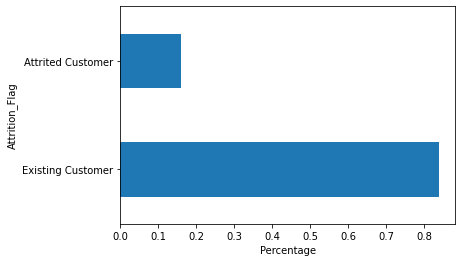

In [236]:
pd.value_counts(data['Attrition_Flag'],normalize=True).plot.barh()
plt.xlabel("Percentage")
plt.ylabel("Attrition_Flag")
plt.savefig(root_dir+"/figures/Attrition_Flag.png",transparent = True,bbox_inches='tight',dpi = 300)
plt.show()
#Attrited customer is the "churned" customer and the its proportion is about 16.07%. So it is an imbalanced dataset.
#It is a typical classification task.

**3. Why is it interesting/important? and where does it come from?**

Predicting churn is very important especially when clear customer feedback is absent. Retaining existing customers and thereby increasing their lifetime value is something everyone acknowledges as being important, however there is little the bank managers can do about customer churn if they don't see it coming in the first place.So this is where predicting churn has its value. Early and accurate churn prediction empowers CRM and customer experience teams to be creative and proactive in their engagement with the customer. In fact, by simply reaching out to the customer early enough, 11% of the churn can be avoided.
#link: https://www.tigeranalytics.com/blog/addressing-customer-churn-in-banking/

The data come from LEAPS and the link is https://leapsapp.analyttica.com/cases/11

**4. Size of the data? Is it i.i,d.?**

In [17]:
data.shape

(10127, 21)

There are 20 features and 10127 data points since it is mentioned that the last two columns should be dropped

**5. What are the columns?**

'CLIENTNUM' is the client number, a unique identifier for the customer holding the account.It is a continous numerical feature,and one data point only has one client number which means that every data point represents the data of one unique customer.

<AxesSubplot:>

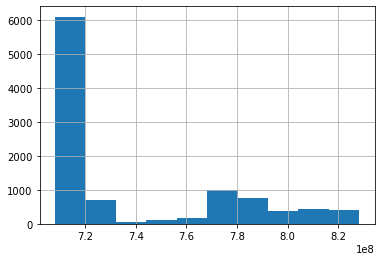

In [18]:
data['CLIENTNUM'].hist()

In [21]:
len(data['CLIENTNUM'].unique())

10127

### Demographic variables

'Customer_Age' is a demographic variable and measures the customer's age in years.It is a continuous numerical feature too and nearly normally distributed.

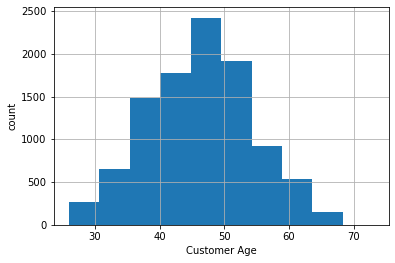

In [43]:
data['Customer_Age'].hist()
plt.xlabel("Customer Age")
plt.ylabel('count')
plt.show()

'Gender' is also a demographic variable with F representing female and M representing male. It is a categorical feature without order and it distributed rather fairly.

In [30]:
data['Gender'].value_counts()/data.shape[0]

F    0.529081
M    0.470919
Name: Gender, dtype: float64

'Dependent_count' represents the number of dependents one customer has. It is a discrete numerical feature.

Text(0, 0.5, 'percentage')

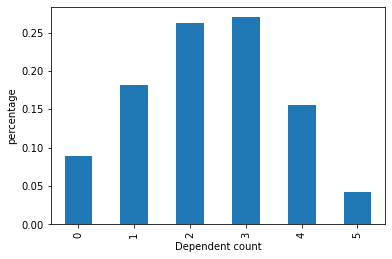

In [76]:
(data['Dependent_count'].value_counts()/data.shape[0]).sort_index().plot(kind = 'bar')
plt.xlabel("Dependent count")
plt.ylabel('percentage')

'Education_level' is the educational qualification of the account holder. It is a categorical feature with orders and its categories are ['Uneducated','High School','College','Graduate','Doctorate','Post-Graduate','Unknown']. And in this column, large percent of customers are graduates and only a few are post-graduate or doctorate. Also, it worths notice that there is a value called 'Unknown' which is the missing value in educational level and needed to be dealt with in data preprocessing.

In [36]:
data['Education_Level'].value_counts()/data.shape[0]

Graduate         0.308877
High School      0.198776
Unknown          0.149995
Uneducated       0.146835
College          0.100030
Post-Graduate    0.050953
Doctorate        0.044534
Name: Education_Level, dtype: float64

'Marital_status' is an orderless categorical feature with ['Married','Single','Divorced' and 'Unknown'] as its catogories. And most customers are married or single. There are also unknown values in this column which are also needed to be treated in data preprocessing.

In [37]:
data['Marital_Status'].value_counts()/data.shape[0]

Married     0.462822
Single      0.389355
Unknown     0.073961
Divorced    0.073862
Name: Marital_Status, dtype: float64

'Income_Category' is an ordered categorical feature with ['Less than $40K', '$40K - $60K','$60K - $80K','$80K - $120K','$120K +','Unknown'] as its categories. 

In [38]:
data['Income_Category'].value_counts()/data.shape[0]

Less than $40K    0.351634
$40K - $60K       0.176755
$80K - $120K      0.151575
$60K - $80K       0.138442
Unknown           0.109805
$120K +           0.071788
Name: Income_Category, dtype: float64

### Product Variable

'Card_Category' describes the cards that customers have. It is a ordered categorcial deature with ['Blue','Silver','Gold','Platinum'] as its categories.

In [39]:
data['Card_Category'].value_counts()/data.shape[0]

Blue        0.931767
Silver      0.054804
Gold        0.011455
Platinum    0.001975
Name: Card_Category, dtype: float64

'Months_on_book' describes the period of the customer' relationship with bank. It is a continuous numerical feature and it is also nearly normally distributed.

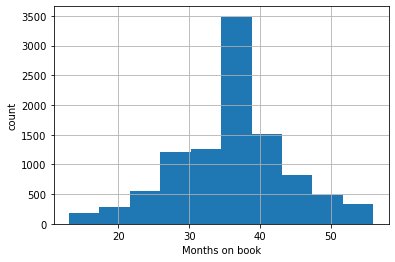

In [41]:
data['Months_on_book'].hist()
plt.xlabel('Months on book')
plt.ylabel('count')
plt.show()

'Total_Relationship_Count' describes the number of products held by the customer. It is a discrete numerical feature

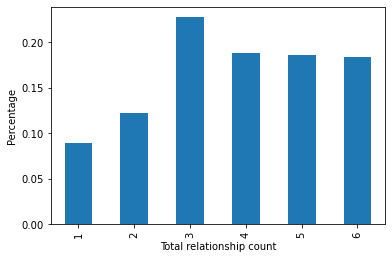

In [77]:
(data['Total_Relationship_Count'].value_counts()/data.shape[0]).sort_index().plot(kind = 'bar')
plt.xlabel("Total relationship count")
plt.ylabel("Percentage")
plt.show()

'Months_Inactive_12_mon' is the number of months inactive in the last 12 months. It is a discrete numerical feature

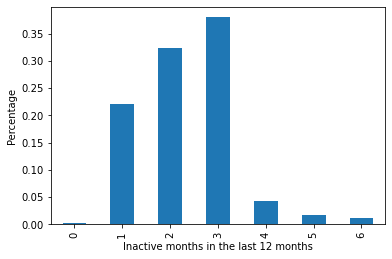

In [78]:
(data['Months_Inactive_12_mon'].value_counts()/data.shape[0]).sort_index().plot(kind = 'bar')
plt.xlabel("Inactive months in the last 12 months")
plt.ylabel("Percentage")
plt.show()

'Contacts_Count_12_mon' is the number of contacts between the customer and the bank manager in the last 12 months. It is also a discrete numerical feature

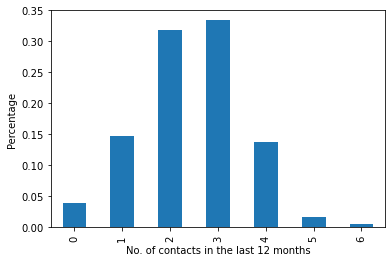

In [79]:
(data['Contacts_Count_12_mon'].value_counts()/data.shape[0]).sort_index().plot(kind = 'bar')
plt.xlabel("No. of contacts in the last 12 months")
plt.ylabel("Percentage")
plt.show()

'Credit_Limit' is the limit on the credit card. It is a continuous numerical feature.

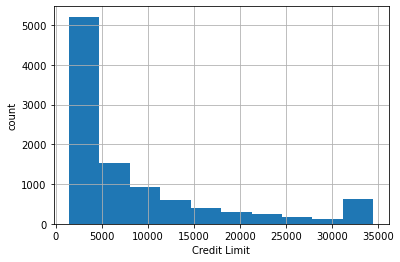

In [81]:
data['Credit_Limit'].hist()
plt.xlabel("Credit Limit")
plt.ylabel("count")
plt.show()

'Total_Revolving_Bal' is the total revolving balance on the credit card and it is a continuous numerical feature

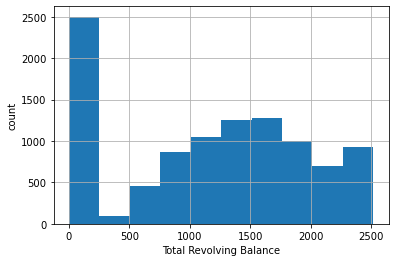

In [83]:
data['Total_Revolving_Bal'].hist()
plt.xlabel("Total Revolving Balance")
plt.ylabel("count")
plt.show()

 'Avg_Open_To_Buy' is the average amount left in the customer's credit card to use and is a continuous numerical feature

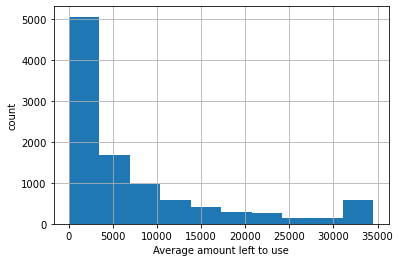

In [95]:
data['Avg_Open_To_Buy'].hist()
plt.xlabel("Average amount left to use")
plt.ylabel("count")
plt.show()

'Total_Amt_Chng_Q4_Q1' measures the change of the transaction amount of Q4 over Q1 and is a continuous numerical feature

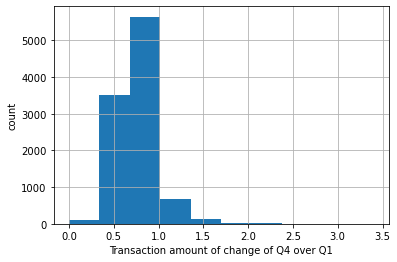

In [86]:
data['Total_Amt_Chng_Q4_Q1'].hist()
plt.xlabel("Transaction amount of change of Q4 over Q1")
plt.ylabel("count")
plt.show()

'Total_Trans_Amt' describes the total transaction amount over the last 12 months and is a continuous numerical feature

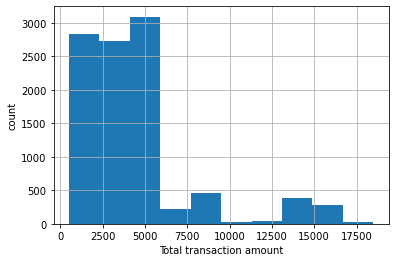

In [87]:
data['Total_Trans_Amt'].hist()
plt.xlabel("Total transaction amount")
plt.ylabel("count")
plt.show()

'Total_Trans_Ct' measures the total transaction count over the last 12 months and is a continuous numerical feature

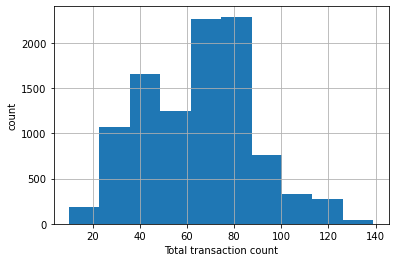

In [90]:
data['Total_Trans_Ct'].hist()
plt.xlabel("Total transaction count")
plt.ylabel("count")
plt.show()

'Total_Ct_Chng_Q4_Q1' measures the change in transaction count of Q4 over Q1 and is a continuous numerical feature

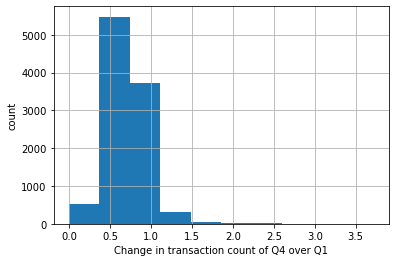

In [92]:
data['Total_Ct_Chng_Q4_Q1'].hist()
plt.xlabel("Change in transaction count of Q4 over Q1")
plt.ylabel("count")
plt.show()

'Avg_Utilization_Ratio' measures the average card utilization ratio which equals to (credit card spent + money withdrawal)/(Total available limit for credit card spends + Total money withdrawal limit) and is a continuous numerical feature

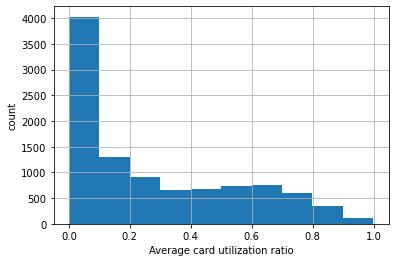

In [93]:
data['Avg_Utilization_Ratio'].hist()
plt.xlabel("Average card utilization ratio")
plt.ylabel("count")
plt.show()

**6.Write a short description about 2-3 public projects or publications where the data has been used, what did the authors find, what ML question did they solve and how successful they were.**

For this data, there are two main tasks, one is to improve the performance of predicting churned customers while the other is to find the most influential factors that make the customers "churn". However finding the factors that matter most is a common strategy when enhancing the model performance so I rather treat them as a same task. And there are several projects that have already been done to solve this problem and achieve good results.
Thomas used SMOTE which is an approach to address imbalanced datasets by oversampling the minority class and found great improvement when processing the data generated by this strategy. The result showed that compared to the raw data, this new data could improve the F1 score from average 0.6 to average 0.9. Thomas also made a model comparison among Random Forest, Adaboost and SVM and found that Random Forest model with SMOTE has the best F-1 score(0.91).
https://www.kaggle.com/thomaskonstantin/bank-churn-data-exploration-and-churn-prediction
Andi looked into the details about the raw data and made five interesting assumptions about the relationship of the features with the target variable. he found that the likelihood of the customers' leaving is related to the money they spend annually, the months of inactivity in their bank account and their credit limit.The result also showed that age seemed of no use in predicting and almost all churned customers used their cards below 100 times.As for the classification models, Andi used Random Forest and SVM as well but replaced Adaboost with Gradient boosting and achieved 95% accuracy and 85% recall rate.
https://www.kaggle.com/paotografi/customer-churn-eda-95-acc-and-85-recall
Joseph used Random Forest and LightGBM to predict with 97% recall and 95% accuracy and plotted the importance of these features. The result showed that both transaction amount and transaction count ranked top. So we need to look these features thoroughly when doing exploratory data analysis.
https://www.kaggle.com/josephchan524/bankchurnersclassifier-recall-97-accuracy-95



# EDA

### The relationship of each feature with target variable

In [4]:
con_fea = ['CLIENTNUM','Customer_Age','Months_on_book','Credit_Limit','Total_Revolving_Bal','Avg_Open_To_Buy','Total_Amt_Chng_Q4_Q1',
           'Total_Trans_Amt','Total_Trans_Ct','Total_Ct_Chng_Q4_Q1','Avg_Utilization_Ratio']
dis_fea = ['Dependent_count','Total_Relationship_Count','Months_Inactive_12_mon','Contacts_Count_12_mon',]
cat_fea = ['Gender','Marital_Status']
ord_fea = ['Education_Level','Income_Category','Card_Category']
categories = data['Attrition_Flag'].unique()

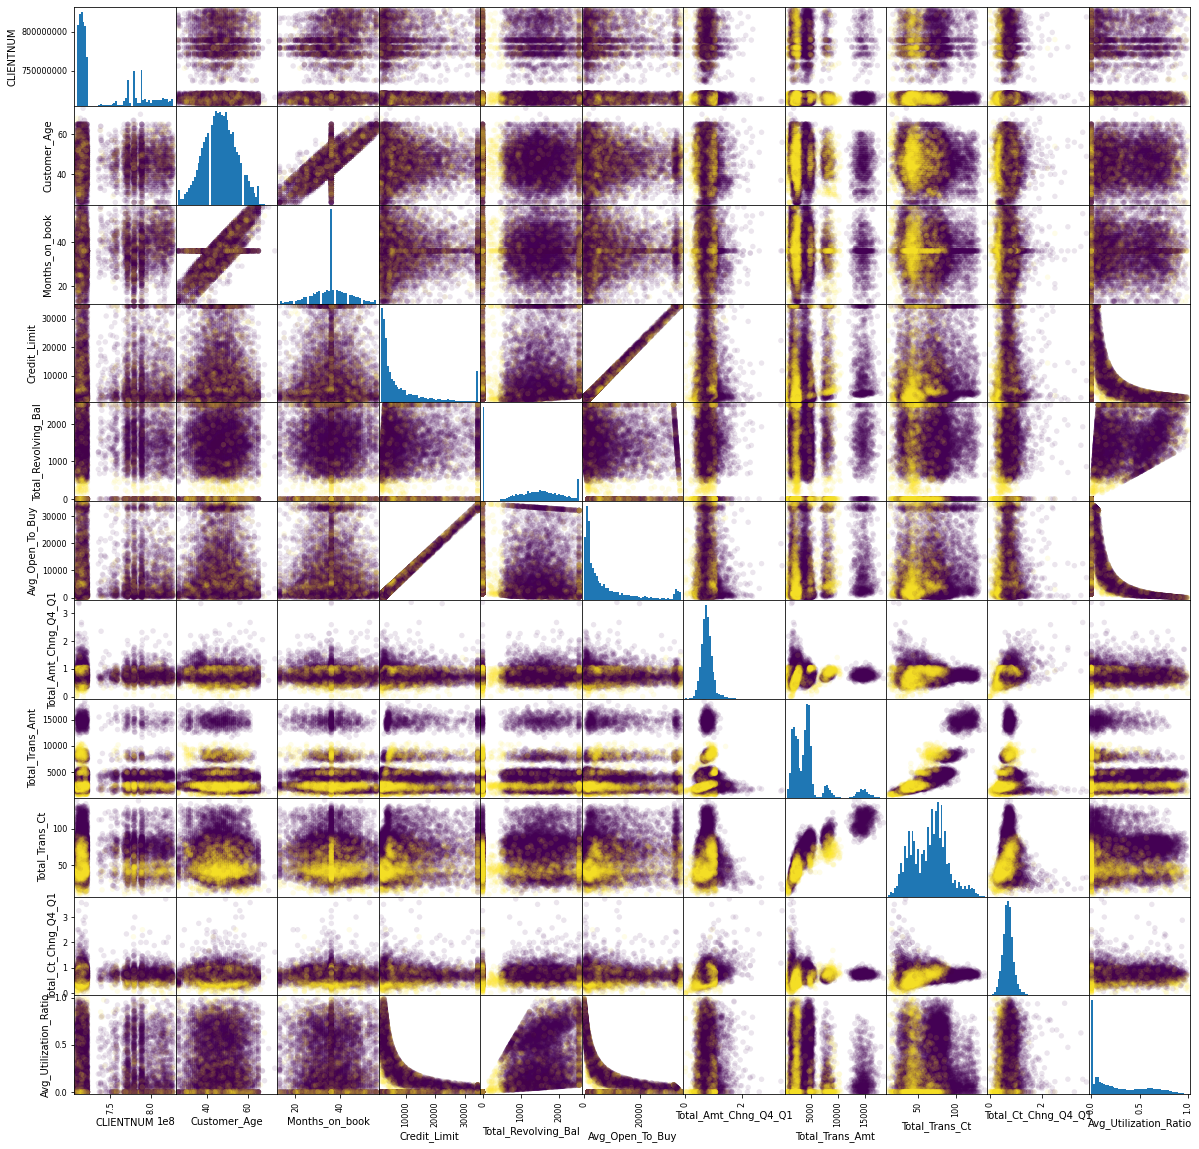

In [9]:
pd.plotting.scatter_matrix(data[con_fea], figsize=(20, 20), marker='o',hist_kwds={'bins': 50}, 
                           c = pd.get_dummies(data['Attrition_Flag']).iloc[:,0],s=30, alpha=.1)
plt.savefig(root_dir+"\\figures\\scatterplot.png",transparent = True,bbox_inches='tight',dpi=300)
plt.show()

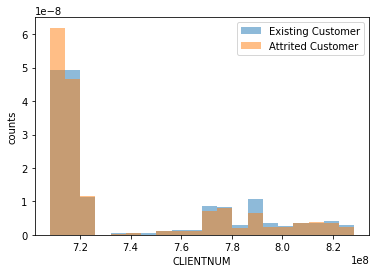

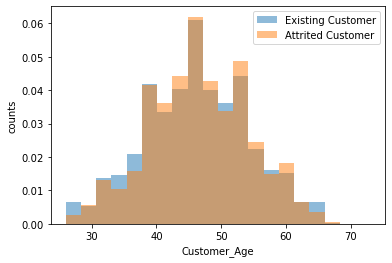

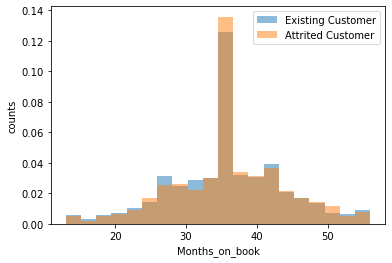

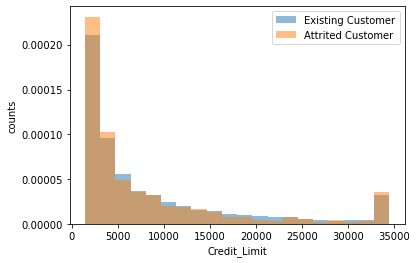

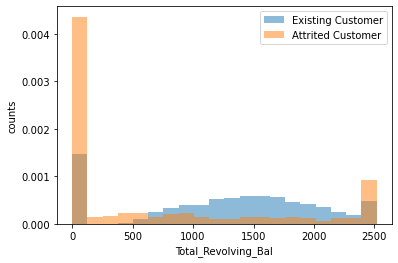

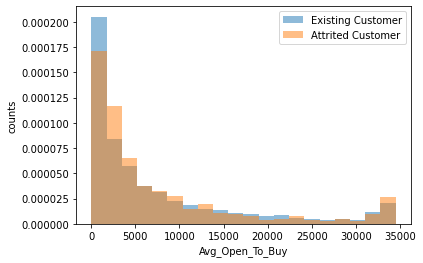

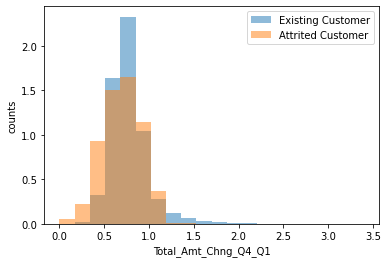

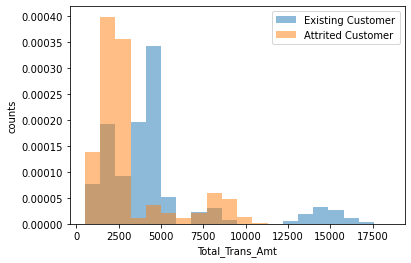

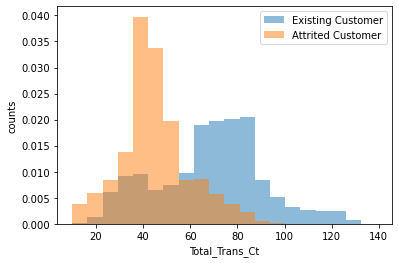

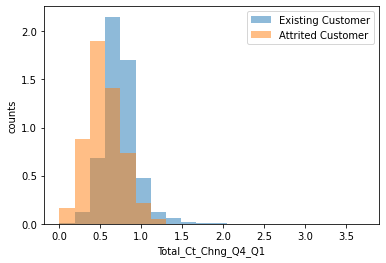

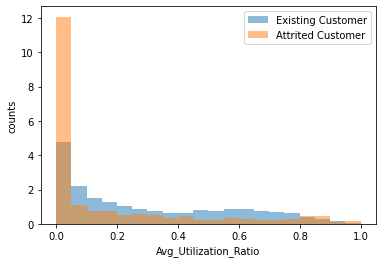

In [10]:

for feature in con_fea:
    bin_range = (data[feature].min(),data[feature].max())
    for c in categories:
        plt.hist(data[data['Attrition_Flag']==c][feature],alpha=0.5,label=c,range=bin_range,bins=20,density=True)
    plt.legend()
    plt.ylabel('counts')
    plt.xlabel(feature)
    plt.savefig(root_dir+"\\figures\\feature_and_target_variable\\{}_and_Attrition_Flag.png".format(feature),transparent = True,
                dpi = 300,bbox_inches='tight')
    plt.show()


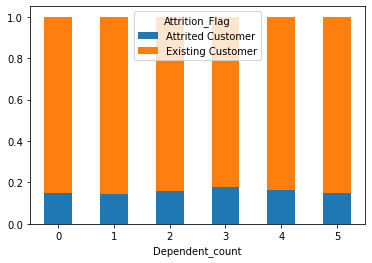

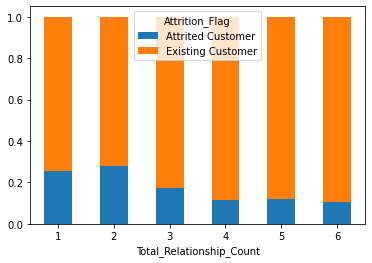

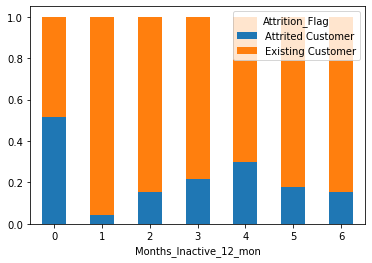

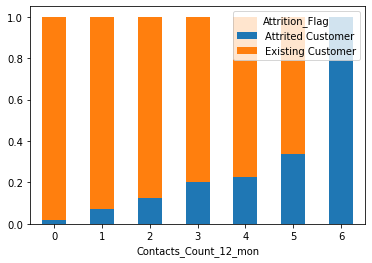

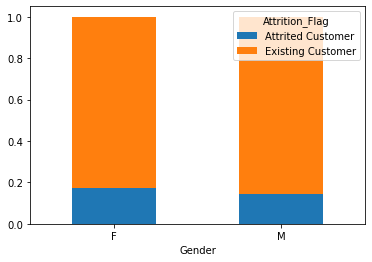

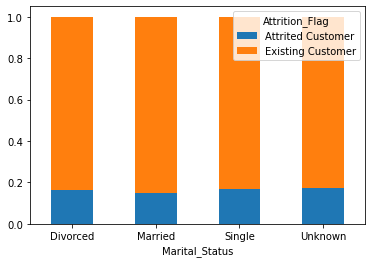

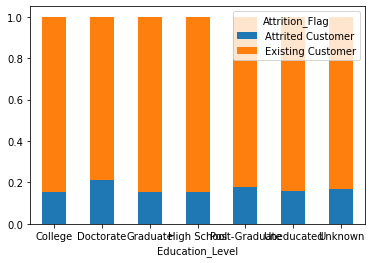

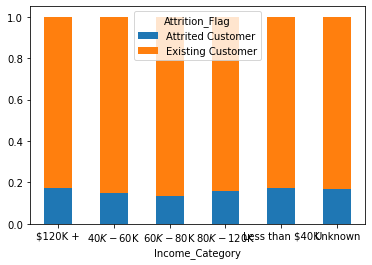

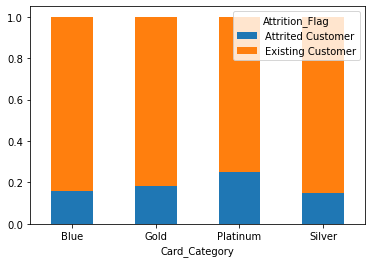

In [242]:
for feature in dis_fea+cat_fea+ord_fea:
    count_matrix = data.groupby([feature, 'Attrition_Flag']).size().unstack()
    count_matrix_norm = count_matrix.div(count_matrix.sum(axis=1),axis=0)
    count_matrix_norm.plot(kind='bar', stacked=True)
    plt.xticks(rotation=0)
    plt.savefig(root_dir+"/figures/feature_and_target_variable/{} and Attrition_Flag.png".format(feature),transparent = True,
                dpi = 300,bbox_inches='tight')
    plt.show()

### The distribution of every features

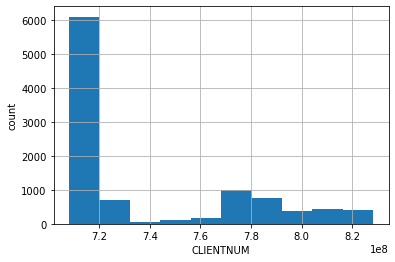

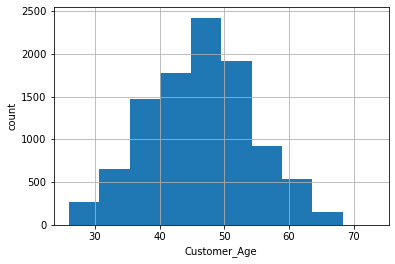

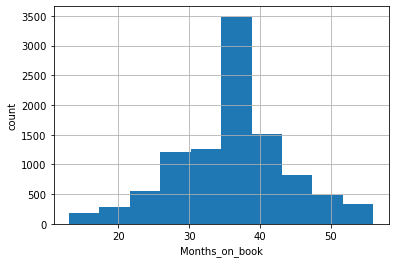

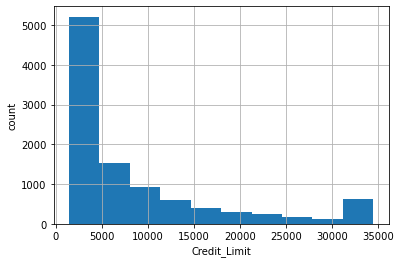

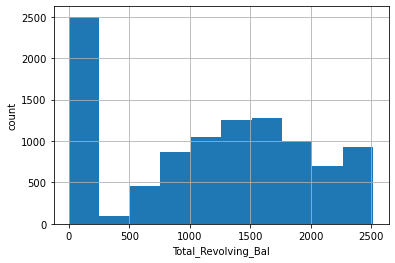

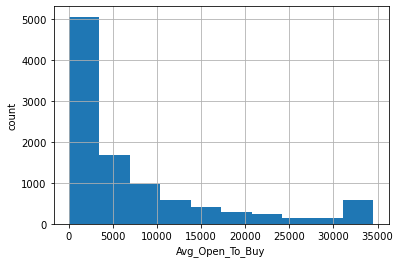

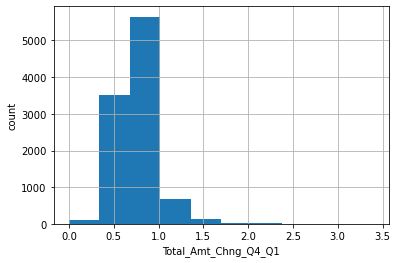

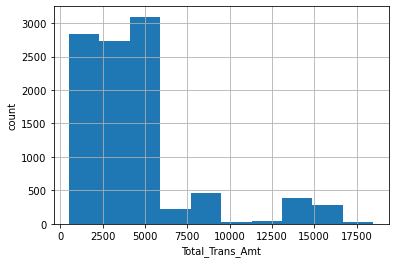

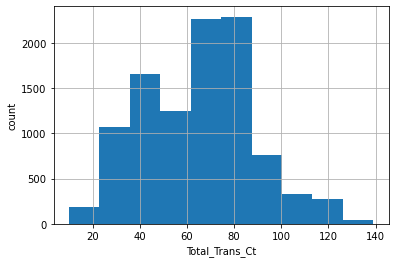

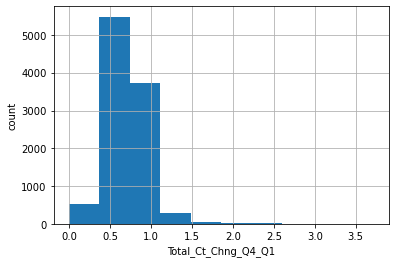

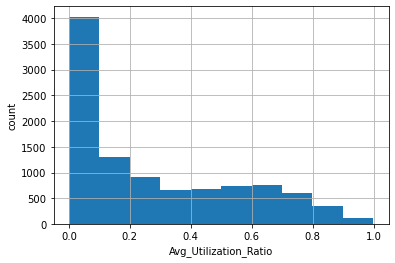

In [19]:
for feature in con_fea:
    data[feature].hist()
    plt.xlabel(feature)
    plt.ylabel('count')
    plt.savefig(root_dir+"/figures/feature_distribution/{}.png".format(feature),transparent = True,dpi = 300)
    plt.show()

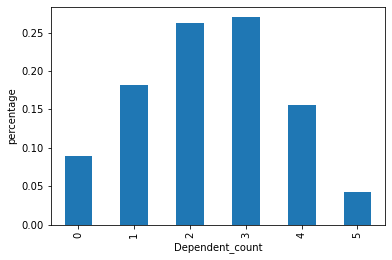

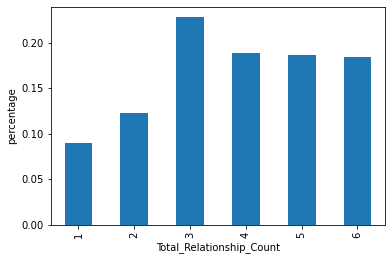

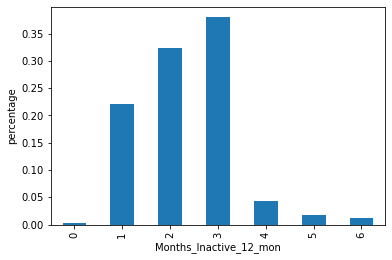

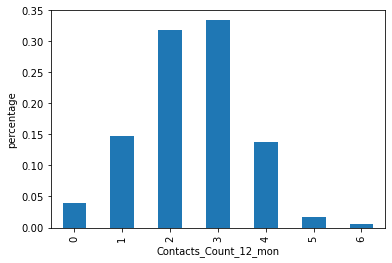

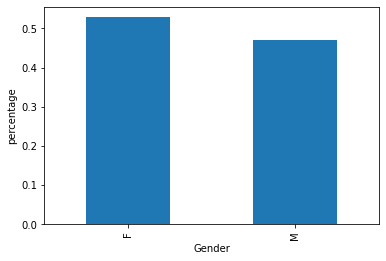

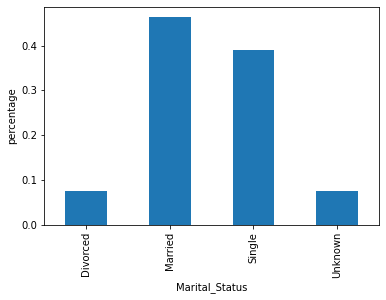

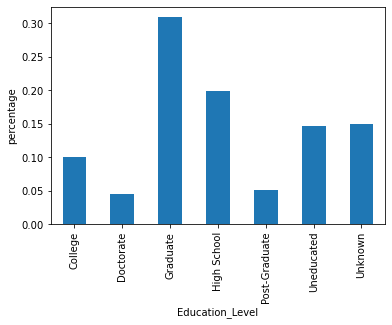

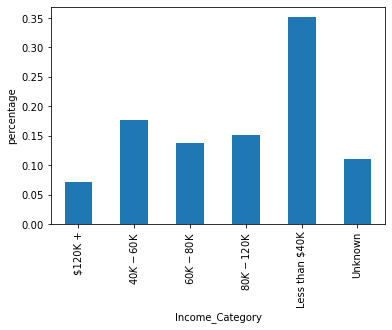

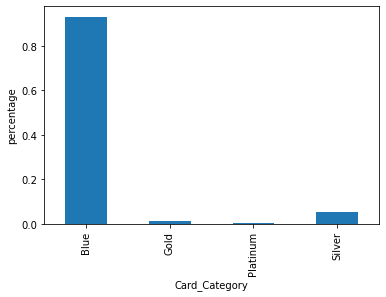

In [12]:
for feature in dis_fea+cat_fea+ord_fea:
    (data[feature].value_counts()/data.shape[0]).sort_index().plot(kind = 'bar')
    plt.xlabel(feature)
    plt.ylabel('percentage')
    plt.savefig(root_dir+"/figures/feature_distribution/{}.png".format(feature),transparent = True,bbox_inches='tight',dpi = 300)
    plt.show()

# Method

**In this section, please explain your splitting strategy, the data preprocessing, and ML pipeline you developed. In general, explain what considerations went into each step of the pipeline.**

 - This dataset is not IID since all features are not identically distributed. It does not have a group structure, nor does it have time-series data. But it is imbalanced, so it is better to use stratify method when splitting. The train size is set as 0.6 and the validation size as well as the test size both as 0.2 because it is how people normally split their data when they have lots of data points.
 - I treated discrete numerical features (dis_fea) as ordinal features and put them directly into the model since they are already in numerical form. Categorical features (cat_fea) need to be treated with OneHotEncoder because it is not sensible if we put gender and marital status in order. For ordinal features(ord_fea), OrdinalEncoder is the best fit because there is ordinal information contained in educational level, income category, and card category. For continuous numerical feature(con_fea), I chose StandardScaler. Since in these columns, 'Customer_Age', 'Monts_on_book', and 'Total_Trans_Ct' are nearly normally distributed though some are skewed while other features have long tails which are not suitable to use MinMaxScaler. 
 - In this case, I also transform the target varible by setting all "Existing Customer" to 1 and all "Attrited Customer" to 0 to make it machine-comprehensible because it is a binary classification problem and the type of the values in the target variable is ‘string'. And the reason why I choose manually trandformation rather than the LabelEncoder is because it is necessary to make sure that the "Attrited Customer" is the positive label which, in sklearn, corresponds to 1. Otherwise, the evaluation metric will be wrong. 
 - There are some missing values in some demographic variables like educational level, income category, and marital status and we can treat them as one special category since they are all categorical features.
 - The ML pipiline that I use is quite simple. For each random state, I first split and preprocess the data as the description above and then run all parameters combinations on the training data and validation data to find the best model in each random state, and calculate the test score based on the best model. In the end, we will have 10 test scores with 10 random states for each model. 

**Try at least four different ML algorithms on your dataset, describe what parameters you tune and the values you try. What metric do you use to evaluate your models’ performance and why**

In this project, I've tried six different models including three logistic models with different regularization methods and svm, random forest, and XGBoost.The parameters of each model are as the following table.

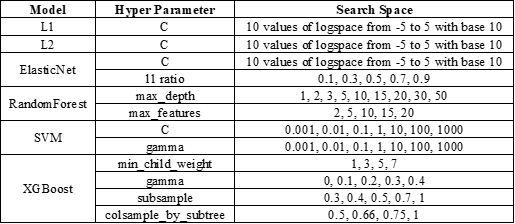

The metric that I use is f2 score because the loss of treating an attrited customer as the existing customer is far greater than that of predicting an existing customer as an attrited customer. Therefore, we need to pay more attention to recall, and thus I choose the f beta score as metric with more emphasis on the recall score.


In [4]:
X = data[[column for column in data.columns if column != 'Attrition_Flag']]
y = np.where(data['Attrition_Flag'] == "Existing Customer", 0, 1)  #label encoding

###Preprocessor

con_fea = ['CLIENTNUM','Customer_Age','Months_on_book','Credit_Limit','Total_Revolving_Bal','Avg_Open_To_Buy','Total_Amt_Chng_Q4_Q1',
           'Total_Trans_Amt','Total_Trans_Ct','Total_Ct_Chng_Q4_Q1','Avg_Utilization_Ratio']
dis_fea = ['Dependent_count','Total_Relationship_Count','Months_Inactive_12_mon','Contacts_Count_12_mon',]
cat_fea = ['Gender','Marital_Status']
ord_fea = ['Education_Level','Income_Category','Card_Category']
#ordinal encoder
ord_cats =[['Uneducated','High School','College','Graduate','Doctorate','Post-Graduate','Unknown'],
           ['Less than $40K', '$40K - $60K','$60K - $80K','$80K - $120K','$120K +','Unknown'], 
           ['Blue','Silver','Gold','Platinum']
          ]

ordinal_transformer = Pipeline(steps=[('ordinal', OrdinalEncoder(categories = ord_cats))])
onehot_transformer = Pipeline(steps = [('onehot', OneHotEncoder(sparse=False,handle_unknown='ignore'))])
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
def fun(x):
    return x   
no_transformer = FunctionTransformer(fun)

# collect the transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('ord', ordinal_transformer, ord_fea),
        ('cat', onehot_transformer, cat_fea),
        ('num', numeric_transformer, con_fea),
        ('dis',no_transformer,dis_fea)
        ]
)

X_prep = preprocessor.fit_transform(X)

**XGBoost**

In [12]:
final_model_xgboost = []
n_state = 10

test_scores_xgboost = np.zeros(n_state)
    
for i in range(n_state):
    state = 42*i
    print("random_states = %i"%(state))
    
    #split the data to 60-20-20
    X_train,X_other,y_train,y_other = train_test_split(X,y,train_size = 0.6,random_state = state,stratify=y)
    X_test, X_val, y_test, y_val = train_test_split(X_other,y_other,train_size = 0.5,random_state=state,stratify=y_other)
    
    # preprocess the sets
    X_train_prep = preprocessor.fit_transform(X_train)
    X_val_prep = preprocessor.transform(X_val)
    X_test_prep = preprocessor.transform(X_test)
    
    
    # find the best parameter set
    param_grid = {"learning_rate": [0.03],
                    "n_estimators": [10000],
#                     "seed": [0],
                    "min_child_weight": [1,3,5,7],
                    "gamma": [0,0.1,0.2,0.3,0.4],
#                       "missing": [np.nan], 
                    "max_depth":  [2],
                    "colsample_bytree": [0.3,0.4,0.5,0.7,1],              
                    "subsample": [0.5,0.66,0.75,1]
                 }

    pg = ParameterGrid(param_grid)
    train_score = np.zeros(len(pg))
    val_score = np.zeros(len(pg))
    models = []

    for j in range(len(pg)):
        params = ParameterGrid(param_grid)[j]
        print('   ',params) 
        eval_set = [(X_val_prep, y_val)]
        clf = xgboost.XGBClassifier(**params,random_state=state,use_label_encoder=False,eval_metric = "logloss")
        clf.fit(X_train_prep,y_train,early_stopping_rounds=50,verbose = False, eval_set=eval_set)
        models.append(clf)

        y_train_pred = clf.predict(X_train_prep)
        y_val_pred = clf.predict(X_val_prep)
        train_score[j] = fbeta_score(y_train,y_train_pred,beta = 2.0)
        val_score[j] = fbeta_score(y_val,y_val_pred,beta = 2.0)
        #Print out the train and validation scores for each alpha in linreg_model
        print("   the traning score is {} and the validation score: {}".format(train_score[j], val_score[j]))
       
        

        
    best_params = np.array(pg)[val_score == np.max(val_score)]
    best_model = models[np.argmax(val_score)]
    final_model_xgboost.append(best_model)
    # test the model on the test set with best parameter set
    y_test_pred = best_model.predict(X_test_prep)
    test_scores_xgboost[i] = fbeta_score(y_test,y_test_pred,beta = 2.0)

    print('The best params are {}, and the test score is {} \n '.format(best_params,test_scores_xgboost[i]))

    
for i,model in enumerate(final_model_xgboost):
    dump(model, root_dir+'/results/xgboost/xgboost{}.joblib'.format(i+1)) 

random_states = 0
    {'subsample': 0.5, 'n_estimators': 10000, 'min_child_weight': 1, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0, 'colsample_bytree': 0.3}
   the traning score is 0.9391124871001032 and the validation score: 0.8702432938240799
    {'subsample': 0.66, 'n_estimators': 10000, 'min_child_weight': 1, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0, 'colsample_bytree': 0.3}
   the traning score is 0.9436299814164775 and the validation score: 0.8753894080996885
    {'subsample': 0.75, 'n_estimators': 10000, 'min_child_weight': 1, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0, 'colsample_bytree': 0.3}
   the traning score is 0.9621321259518419 and the validation score: 0.8799751243781094
    {'subsample': 1, 'n_estimators': 10000, 'min_child_weight': 1, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0, 'colsample_bytree': 0.3}
   the traning score is 0.948258091115234 and the validation score: 0.8750000000000001
    {'subsample': 0.5, 'n_estimators': 10000, 'min_

   the traning score is 0.9492888064316636 and the validation score: 0.8739076154806491
    {'subsample': 0.5, 'n_estimators': 10000, 'min_child_weight': 3, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.2, 'colsample_bytree': 0.3}
   the traning score is 0.9302805280528053 and the validation score: 0.8588382261086821
    {'subsample': 0.66, 'n_estimators': 10000, 'min_child_weight': 3, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.2, 'colsample_bytree': 0.3}
   the traning score is 0.9380804953560372 and the validation score: 0.8625
    {'subsample': 0.75, 'n_estimators': 10000, 'min_child_weight': 3, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.2, 'colsample_bytree': 0.3}
   the traning score is 0.9322033898305083 and the validation score: 0.8583959899749374
    {'subsample': 1, 'n_estimators': 10000, 'min_child_weight': 3, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.2, 'colsample_bytree': 0.3}
   the traning score is 0.9519884607459305 and the validation score: 0.8

   the traning score is 0.9530187512878632 and the validation score: 0.8687499999999999
    {'subsample': 0.5, 'n_estimators': 10000, 'min_child_weight': 5, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.4, 'colsample_bytree': 0.3}
   the traning score is 0.9248554913294796 and the validation score: 0.8541927409261578
    {'subsample': 0.66, 'n_estimators': 10000, 'min_child_weight': 5, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.4, 'colsample_bytree': 0.3}
   the traning score is 0.9362755207259228 and the validation score: 0.8552631578947368
    {'subsample': 0.75, 'n_estimators': 10000, 'min_child_weight': 5, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.4, 'colsample_bytree': 0.3}
   the traning score is 0.9449143800288837 and the validation score: 0.8702432938240799
    {'subsample': 1, 'n_estimators': 10000, 'min_child_weight': 5, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.4, 'colsample_bytree': 0.3}
   the traning score is 0.9540963359407162 and the validatio

   the traning score is 0.9573810994441012 and the validation score: 0.868207370393504
    {'subsample': 0.5, 'n_estimators': 10000, 'min_child_weight': 7, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.1, 'colsample_bytree': 0.4}
   the traning score is 0.92588769611891 and the validation score: 0.8469259723964868
    {'subsample': 0.66, 'n_estimators': 10000, 'min_child_weight': 7, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.1, 'colsample_bytree': 0.4}
   the traning score is 0.9302085484204005 and the validation score: 0.8608858390517778
    {'subsample': 0.75, 'n_estimators': 10000, 'min_child_weight': 7, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.1, 'colsample_bytree': 0.4}
   the traning score is 0.9278776606736931 and the validation score: 0.8625
    {'subsample': 1, 'n_estimators': 10000, 'min_child_weight': 7, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.1, 'colsample_bytree': 0.4}
   the traning score is 0.9411764705882353 and the validation score: 0.8578

   the traning score is 0.9358233594717293 and the validation score: 0.8589341692789969
    {'subsample': 0.5, 'n_estimators': 10000, 'min_child_weight': 1, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.4, 'colsample_bytree': 0.4}
   the traning score is 0.9376934186094491 and the validation score: 0.8655043586550436
    {'subsample': 0.66, 'n_estimators': 10000, 'min_child_weight': 1, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.4, 'colsample_bytree': 0.4}
   the traning score is 0.9519389438943896 and the validation score: 0.8717310087173101
    {'subsample': 0.75, 'n_estimators': 10000, 'min_child_weight': 1, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.4, 'colsample_bytree': 0.4}
   the traning score is 0.9600329625051505 and the validation score: 0.8774113254511512
    {'subsample': 1, 'n_estimators': 10000, 'min_child_weight': 1, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.4, 'colsample_bytree': 0.4}
   the traning score is 0.9614988676137532 and the validatio

   the traning score is 0.970164609053498 and the validation score: 0.8907510862818124
    {'subsample': 0.5, 'n_estimators': 10000, 'min_child_weight': 3, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.1, 'colsample_bytree': 0.5}
   the traning score is 0.9368551382583574 and the validation score: 0.8614232209737827
    {'subsample': 0.66, 'n_estimators': 10000, 'min_child_weight': 3, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.1, 'colsample_bytree': 0.5}
   the traning score is 0.9492364836978953 and the validation score: 0.8695652173913044
    {'subsample': 0.75, 'n_estimators': 10000, 'min_child_weight': 3, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.1, 'colsample_bytree': 0.5}
   the traning score is 0.9380804953560372 and the validation score: 0.8650843222985635
    {'subsample': 1, 'n_estimators': 10000, 'min_child_weight': 3, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.1, 'colsample_bytree': 0.5}
   the traning score is 0.9683388157894738 and the validation

   the traning score is 0.9563066776586976 and the validation score: 0.8753894080996885
    {'subsample': 0.5, 'n_estimators': 10000, 'min_child_weight': 5, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.3, 'colsample_bytree': 0.5}
   the traning score is 0.9148232375439324 and the validation score: 0.8453802639849151
    {'subsample': 0.66, 'n_estimators': 10000, 'min_child_weight': 5, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.3, 'colsample_bytree': 0.5}
   the traning score is 0.9365964477488642 and the validation score: 0.8572319201995012
    {'subsample': 0.75, 'n_estimators': 10000, 'min_child_weight': 5, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.3, 'colsample_bytree': 0.5}
   the traning score is 0.9355638166047088 and the validation score: 0.8614232209737827
    {'subsample': 1, 'n_estimators': 10000, 'min_child_weight': 5, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.3, 'colsample_bytree': 0.5}
   the traning score is 0.9575782537067544 and the validatio

   the traning score is 0.9451093685513826 and the validation score: 0.8671241422333125
    {'subsample': 0.5, 'n_estimators': 10000, 'min_child_weight': 7, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0, 'colsample_bytree': 0.7}
   the traning score is 0.9260788767292999 and the validation score: 0.8515967438948028
    {'subsample': 0.66, 'n_estimators': 10000, 'min_child_weight': 7, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0, 'colsample_bytree': 0.7}
   the traning score is 0.9397565504435735 and the validation score: 0.866043613707165
    {'subsample': 0.75, 'n_estimators': 10000, 'min_child_weight': 7, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0, 'colsample_bytree': 0.7}
   the traning score is 0.9340772886960116 and the validation score: 0.8697007481296759
    {'subsample': 1, 'n_estimators': 10000, 'min_child_weight': 7, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0, 'colsample_bytree': 0.7}
   the traning score is 0.947618065580532 and the validation score: 0

   the traning score is 0.9372419488026424 and the validation score: 0.8634663341645885
    {'subsample': 1, 'n_estimators': 10000, 'min_child_weight': 7, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.2, 'colsample_bytree': 0.7}
   the traning score is 0.9440775897647544 and the validation score: 0.8630393996247654
    {'subsample': 0.5, 'n_estimators': 10000, 'min_child_weight': 1, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.3, 'colsample_bytree': 0.7}
   the traning score is 0.9438828141118217 and the validation score: 0.8728179551122194
    {'subsample': 0.66, 'n_estimators': 10000, 'min_child_weight': 1, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.3, 'colsample_bytree': 0.7}
   the traning score is 0.9500722096141943 and the validation score: 0.879428216283406
    {'subsample': 0.75, 'n_estimators': 10000, 'min_child_weight': 1, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.3, 'colsample_bytree': 0.7}
   the traning score is 0.9475639966969446 and the validation

   the traning score is 0.9505154639175257 and the validation score: 0.8748443337484435
    {'subsample': 0.75, 'n_estimators': 10000, 'min_child_weight': 1, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0, 'colsample_bytree': 1}
   the traning score is 0.9367899194381327 and the validation score: 0.8739076154806491
    {'subsample': 1, 'n_estimators': 10000, 'min_child_weight': 1, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0, 'colsample_bytree': 1}
   the traning score is 0.9693352541675241 and the validation score: 0.8779576587795764
    {'subsample': 0.5, 'n_estimators': 10000, 'min_child_weight': 3, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0, 'colsample_bytree': 1}
   the traning score is 0.9347242305308818 and the validation score: 0.860349127182045
    {'subsample': 0.66, 'n_estimators': 10000, 'min_child_weight': 3, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0, 'colsample_bytree': 1}
   the traning score is 0.94098225340487 and the validation score: 0.86712414

   the traning score is 0.9380165289256197 and the validation score: 0.8711885500933417
    {'subsample': 0.75, 'n_estimators': 10000, 'min_child_weight': 3, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.2, 'colsample_bytree': 1}
   the traning score is 0.9353706380342763 and the validation score: 0.8650843222985635
    {'subsample': 1, 'n_estimators': 10000, 'min_child_weight': 3, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.2, 'colsample_bytree': 1}
   the traning score is 0.9519884607459305 and the validation score: 0.8779576587795764
    {'subsample': 0.5, 'n_estimators': 10000, 'min_child_weight': 5, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.2, 'colsample_bytree': 1}
   the traning score is 0.9328512396694216 and the validation score: 0.8634663341645885
    {'subsample': 0.66, 'n_estimators': 10000, 'min_child_weight': 5, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.2, 'colsample_bytree': 1}
   the traning score is 0.9318181818181818 and the validation score:

   the traning score is 0.9336913860772569 and the validation score: 0.8748443337484435
    {'subsample': 0.75, 'n_estimators': 10000, 'min_child_weight': 5, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.4, 'colsample_bytree': 1}
   the traning score is 0.94800907778007 and the validation score: 0.8722741433021808
    {'subsample': 1, 'n_estimators': 10000, 'min_child_weight': 5, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.4, 'colsample_bytree': 1}
   the traning score is 0.9496803464631883 and the validation score: 0.8671241422333125
    {'subsample': 0.5, 'n_estimators': 10000, 'min_child_weight': 7, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.4, 'colsample_bytree': 1}
   the traning score is 0.9262701363073109 and the validation score: 0.8645443196004994
    {'subsample': 0.66, 'n_estimators': 10000, 'min_child_weight': 7, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.4, 'colsample_bytree': 1}
   the traning score is 0.932465923172243 and the validation score: 0.

   the traning score is 0.9318181818181818 and the validation score: 0.8619612742036226
    {'subsample': 0.66, 'n_estimators': 10000, 'min_child_weight': 7, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.1, 'colsample_bytree': 0.3}
   the traning score is 0.9347242305308818 and the validation score: 0.867665418227216
    {'subsample': 0.75, 'n_estimators': 10000, 'min_child_weight': 7, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.1, 'colsample_bytree': 0.3}
   the traning score is 0.9355638166047088 and the validation score: 0.8630393996247654
    {'subsample': 1, 'n_estimators': 10000, 'min_child_weight': 7, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.1, 'colsample_bytree': 0.3}
   the traning score is 0.948258091115234 and the validation score: 0.8744534665833854
    {'subsample': 0.5, 'n_estimators': 10000, 'min_child_weight': 1, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.2, 'colsample_bytree': 0.3}
   the traning score is 0.9468370080362661 and the validation 

   the traning score is 0.9470321516900247 and the validation score: 0.8687499999999999
    {'subsample': 0.5, 'n_estimators': 10000, 'min_child_weight': 1, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.4, 'colsample_bytree': 0.3}
   the traning score is 0.9492888064316636 and the validation score: 0.8827199001871492
    {'subsample': 0.66, 'n_estimators': 10000, 'min_child_weight': 1, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.4, 'colsample_bytree': 0.3}
   the traning score is 0.9442724458204335 and the validation score: 0.8827199001871492
    {'subsample': 0.75, 'n_estimators': 10000, 'min_child_weight': 1, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.4, 'colsample_bytree': 0.3}
   the traning score is 0.9469775118630082 and the validation score: 0.883270911360799
    {'subsample': 1, 'n_estimators': 10000, 'min_child_weight': 1, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.4, 'colsample_bytree': 0.3}
   the traning score is 0.9647858319604612 and the validation

   the traning score is 0.9608650875386199 and the validation score: 0.8889582033686837
    {'subsample': 0.5, 'n_estimators': 10000, 'min_child_weight': 3, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.1, 'colsample_bytree': 0.4}
   the traning score is 0.948204704911267 and the validation score: 0.8713304184884448
    {'subsample': 0.66, 'n_estimators': 10000, 'min_child_weight': 3, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.1, 'colsample_bytree': 0.4}
   the traning score is 0.948258091115234 and the validation score: 0.8744534665833854
    {'subsample': 0.75, 'n_estimators': 10000, 'min_child_weight': 3, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.1, 'colsample_bytree': 0.4}
   the traning score is 0.9494845360824743 and the validation score: 0.8852867830423939
    {'subsample': 1, 'n_estimators': 10000, 'min_child_weight': 3, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.1, 'colsample_bytree': 0.4}
   the traning score is 0.9554730983302412 and the validation 

   the traning score is 0.9451093685513826 and the validation score: 0.8801498127340823
    {'subsample': 1, 'n_estimators': 10000, 'min_child_weight': 3, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.3, 'colsample_bytree': 0.4}
   the traning score is 0.9554730983302412 and the validation score: 0.8863920099875154
    {'subsample': 0.5, 'n_estimators': 10000, 'min_child_weight': 5, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.3, 'colsample_bytree': 0.4}
   the traning score is 0.9276859504132231 and the validation score: 0.8650843222985635
    {'subsample': 0.66, 'n_estimators': 10000, 'min_child_weight': 5, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.3, 'colsample_bytree': 0.4}
   the traning score is 0.9447764269524006 and the validation score: 0.8733624454148471
    {'subsample': 0.75, 'n_estimators': 10000, 'min_child_weight': 5, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.3, 'colsample_bytree': 0.4}
   the traning score is 0.9416254125412542 and the validatio

   the traning score is 0.9515962924819773 and the validation score: 0.8841843088418431
    {'subsample': 1, 'n_estimators': 10000, 'min_child_weight': 5, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0, 'colsample_bytree': 0.5}
   the traning score is 0.9544892915980231 and the validation score: 0.8821695760598505
    {'subsample': 0.5, 'n_estimators': 10000, 'min_child_weight': 7, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0, 'colsample_bytree': 0.5}
   the traning score is 0.9269199009083402 and the validation score: 0.8609893550407015
    {'subsample': 0.66, 'n_estimators': 10000, 'min_child_weight': 7, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0, 'colsample_bytree': 0.5}
   the traning score is 0.9484536082474226 and the validation score: 0.8739076154806491
    {'subsample': 0.75, 'n_estimators': 10000, 'min_child_weight': 7, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0, 'colsample_bytree': 0.5}
   the traning score is 0.9384678918026016 and the validation score:

   the traning score is 0.9418196822776975 and the validation score: 0.8764815970056145
    {'subsample': 0.75, 'n_estimators': 10000, 'min_child_weight': 7, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.2, 'colsample_bytree': 0.5}
   the traning score is 0.9389186958316136 and the validation score: 0.8764815970056145
    {'subsample': 1, 'n_estimators': 10000, 'min_child_weight': 7, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.2, 'colsample_bytree': 0.5}
   the traning score is 0.9538524927894518 and the validation score: 0.8750000000000001
    {'subsample': 0.5, 'n_estimators': 10000, 'min_child_weight': 1, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.3, 'colsample_bytree': 0.5}
   the traning score is 0.9519389438943896 and the validation score: 0.883270911360799
    {'subsample': 0.66, 'n_estimators': 10000, 'min_child_weight': 1, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.3, 'colsample_bytree': 0.5}
   the traning score is 0.9525773195876288 and the validation

   the traning score is 0.9521846661170652 and the validation score: 0.883270911360799
    {'subsample': 0.66, 'n_estimators': 10000, 'min_child_weight': 1, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0, 'colsample_bytree': 0.7}
   the traning score is 0.9544423830138116 and the validation score: 0.8940809968847353
    {'subsample': 0.75, 'n_estimators': 10000, 'min_child_weight': 1, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0, 'colsample_bytree': 0.7}
   the traning score is 0.9428512481947596 and the validation score: 0.8858390517779164
    {'subsample': 1, 'n_estimators': 10000, 'min_child_weight': 1, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0, 'colsample_bytree': 0.7}
   the traning score is 0.9666803784450845 and the validation score: 0.8980733374766935
    {'subsample': 0.5, 'n_estimators': 10000, 'min_child_weight': 3, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0, 'colsample_bytree': 0.7}
   the traning score is 0.9405940594059404 and the validation score: 

   the traning score is 0.9418196822776975 and the validation score: 0.8750000000000001
    {'subsample': 0.66, 'n_estimators': 10000, 'min_child_weight': 3, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.2, 'colsample_bytree': 0.7}
   the traning score is 0.9523809523809524 and the validation score: 0.8884039900249376
    {'subsample': 0.75, 'n_estimators': 10000, 'min_child_weight': 3, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.2, 'colsample_bytree': 0.7}
   the traning score is 0.9532151690024733 and the validation score: 0.8863920099875154
    {'subsample': 1, 'n_estimators': 10000, 'min_child_weight': 3, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.2, 'colsample_bytree': 0.7}
   the traning score is 0.969566111453835 and the validation score: 0.8915211970074813
    {'subsample': 0.5, 'n_estimators': 10000, 'min_child_weight': 5, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.2, 'colsample_bytree': 0.7}
   the traning score is 0.9227113039884273 and the validation

   the traning score is 0.9552761747732893 and the validation score: 0.8858390517779164
    {'subsample': 0.5, 'n_estimators': 10000, 'min_child_weight': 5, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.4, 'colsample_bytree': 0.7}
   the traning score is 0.9314332920280876 and the validation score: 0.8718750000000002
    {'subsample': 0.66, 'n_estimators': 10000, 'min_child_weight': 5, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.4, 'colsample_bytree': 0.7}
   the traning score is 0.9480626545754328 and the validation score: 0.8841843088418431
    {'subsample': 0.75, 'n_estimators': 10000, 'min_child_weight': 5, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.4, 'colsample_bytree': 0.7}
   the traning score is 0.9509581702039974 and the validation score: 0.8852867830423939
    {'subsample': 1, 'n_estimators': 10000, 'min_child_weight': 5, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.4, 'colsample_bytree': 0.7}
   the traning score is 0.9588477366255145 and the validatio

   the traning score is 0.9582132564841499 and the validation score: 0.883270911360799
    {'subsample': 0.5, 'n_estimators': 10000, 'min_child_weight': 7, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.1, 'colsample_bytree': 1}
   the traning score is 0.9256965944272445 and the validation score: 0.8698372966207759
    {'subsample': 0.66, 'n_estimators': 10000, 'min_child_weight': 7, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.1, 'colsample_bytree': 1}
   the traning score is 0.9403385631709333 and the validation score: 0.8816199376947041
    {'subsample': 0.75, 'n_estimators': 10000, 'min_child_weight': 7, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.1, 'colsample_bytree': 1}
   the traning score is 0.9380804953560372 and the validation score: 0.8821695760598505
    {'subsample': 1, 'n_estimators': 10000, 'min_child_weight': 7, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.1, 'colsample_bytree': 1}
   the traning score is 0.9621710526315789 and the validation score: 

   the traning score is 0.9628031237155774 and the validation score: 0.8904109589041097
    {'subsample': 0.5, 'n_estimators': 10000, 'min_child_weight': 1, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.4, 'colsample_bytree': 1}
   the traning score is 0.94800907778007 and the validation score: 0.8863920099875154
    {'subsample': 0.66, 'n_estimators': 10000, 'min_child_weight': 1, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.4, 'colsample_bytree': 1}
   the traning score is 0.9600329625051505 and the validation score: 0.8960796515245798
    {'subsample': 0.75, 'n_estimators': 10000, 'min_child_weight': 1, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.4, 'colsample_bytree': 1}
   the traning score is 0.9618949536560246 and the validation score: 0.896637608966376
    {'subsample': 1, 'n_estimators': 10000, 'min_child_weight': 1, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.4, 'colsample_bytree': 1}
   the traning score is 0.9633594071634418 and the validation score: 0.

   the traning score is 0.9501236603462487 and the validation score: 0.893077873918418
    {'subsample': 1, 'n_estimators': 10000, 'min_child_weight': 1, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.1, 'colsample_bytree': 0.3}
   the traning score is 0.9486492060218601 and the validation score: 0.8956145768993204
    {'subsample': 0.5, 'n_estimators': 10000, 'min_child_weight': 3, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.1, 'colsample_bytree': 0.3}
   the traning score is 0.9403385631709333 and the validation score: 0.8798017348203222
    {'subsample': 0.66, 'n_estimators': 10000, 'min_child_weight': 3, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.1, 'colsample_bytree': 0.3}
   the traning score is 0.9454995871180842 and the validation score: 0.8916408668730651
    {'subsample': 0.75, 'n_estimators': 10000, 'min_child_weight': 3, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.1, 'colsample_bytree': 0.3}
   the traning score is 0.9391124871001032 and the validation

   the traning score is 0.9461411473380107 and the validation score: 0.8910891089108911
    {'subsample': 0.75, 'n_estimators': 10000, 'min_child_weight': 3, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.3, 'colsample_bytree': 0.3}
   the traning score is 0.9389186958316136 and the validation score: 0.8879950495049506
    {'subsample': 1, 'n_estimators': 10000, 'min_child_weight': 3, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.3, 'colsample_bytree': 0.3}
   the traning score is 0.9507622579316027 and the validation score: 0.9006785934608266
    {'subsample': 0.5, 'n_estimators': 10000, 'min_child_weight': 5, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.3, 'colsample_bytree': 0.3}
   the traning score is 0.9360165118679051 and the validation score: 0.8808933002481388
    {'subsample': 0.66, 'n_estimators': 10000, 'min_child_weight': 5, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.3, 'colsample_bytree': 0.3}
   the traning score is 0.9411764705882353 and the validatio

   the traning score is 0.9376934186094491 and the validation score: 0.8776266996291717
    {'subsample': 0.66, 'n_estimators': 10000, 'min_child_weight': 5, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0, 'colsample_bytree': 0.4}
   the traning score is 0.9422680412371134 and the validation score: 0.8823529411764706
    {'subsample': 0.75, 'n_estimators': 10000, 'min_child_weight': 5, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0, 'colsample_bytree': 0.4}
   the traning score is 0.939950474618242 and the validation score: 0.8910891089108911
    {'subsample': 1, 'n_estimators': 10000, 'min_child_weight': 5, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0, 'colsample_bytree': 0.4}
   the traning score is 0.9467821782178217 and the validation score: 0.8970406905055486
    {'subsample': 0.5, 'n_estimators': 10000, 'min_child_weight': 7, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0, 'colsample_bytree': 0.4}
   the traning score is 0.927494319355505 and the validation score: 0

   the traning score is 0.950907590759076 and the validation score: 0.8995686999383858
    {'subsample': 0.5, 'n_estimators': 10000, 'min_child_weight': 7, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.2, 'colsample_bytree': 0.4}
   the traning score is 0.9283353985956216 and the validation score: 0.871588089330025
    {'subsample': 0.66, 'n_estimators': 10000, 'min_child_weight': 7, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.2, 'colsample_bytree': 0.4}
   the traning score is 0.9387249845265112 and the validation score: 0.8757763975155279
    {'subsample': 0.75, 'n_estimators': 10000, 'min_child_weight': 7, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.2, 'colsample_bytree': 0.4}
   the traning score is 0.9407881163606356 and the validation score: 0.8777915632754343
    {'subsample': 1, 'n_estimators': 10000, 'min_child_weight': 7, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.2, 'colsample_bytree': 0.4}
   the traning score is 0.9426567656765678 and the validation 

   the traning score is 0.9380804953560372 and the validation score: 0.8788819875776399
    {'subsample': 1, 'n_estimators': 10000, 'min_child_weight': 7, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.4, 'colsample_bytree': 0.4}
   the traning score is 0.9434935038152196 and the validation score: 0.8899876390605684
    {'subsample': 0.5, 'n_estimators': 10000, 'min_child_weight': 1, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0, 'colsample_bytree': 0.5}
   the traning score is 0.9432404540763674 and the validation score: 0.8894379246448425
    {'subsample': 0.66, 'n_estimators': 10000, 'min_child_weight': 1, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0, 'colsample_bytree': 0.5}
   the traning score is 0.9519389438943896 and the validation score: 0.8934072704867528
    {'subsample': 0.75, 'n_estimators': 10000, 'min_child_weight': 1, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0, 'colsample_bytree': 0.5}
   the traning score is 0.9449143800288837 and the validation scor

   the traning score is 0.944467382328654 and the validation score: 0.8919753086419752
    {'subsample': 1, 'n_estimators': 10000, 'min_child_weight': 1, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.2, 'colsample_bytree': 0.5}
   the traning score is 0.9504643962848298 and the validation score: 0.8945095619987661
    {'subsample': 0.5, 'n_estimators': 10000, 'min_child_weight': 3, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.2, 'colsample_bytree': 0.5}
   the traning score is 0.9351775392237819 and the validation score: 0.8803471791692499
    {'subsample': 0.66, 'n_estimators': 10000, 'min_child_weight': 3, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.2, 'colsample_bytree': 0.5}
   the traning score is 0.9336913860772569 and the validation score: 0.8888888888888887
    {'subsample': 0.75, 'n_estimators': 10000, 'min_child_weight': 3, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.2, 'colsample_bytree': 0.5}
   the traning score is 0.9469775118630082 and the validation

   the traning score is 0.9326585416236317 and the validation score: 0.8863495985176034
    {'subsample': 0.75, 'n_estimators': 10000, 'min_child_weight': 3, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.4, 'colsample_bytree': 0.5}
   the traning score is 0.937822763891758 and the validation score: 0.8868974042027195
    {'subsample': 1, 'n_estimators': 10000, 'min_child_weight': 3, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.4, 'colsample_bytree': 0.5}
   the traning score is 0.9538049082285006 and the validation score: 0.8981481481481483
    {'subsample': 0.5, 'n_estimators': 10000, 'min_child_weight': 5, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.4, 'colsample_bytree': 0.5}
   the traning score is 0.9315040231070765 and the validation score: 0.871588089330025
    {'subsample': 0.66, 'n_estimators': 10000, 'min_child_weight': 5, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.4, 'colsample_bytree': 0.5}
   the traning score is 0.945165945165945 and the validation s

   the traning score is 0.9395627062706272 and the validation score: 0.8756188118811882
    {'subsample': 0.75, 'n_estimators': 10000, 'min_child_weight': 5, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.1, 'colsample_bytree': 0.7}
   the traning score is 0.9455557846978757 and the validation score: 0.8838071693448704
    {'subsample': 1, 'n_estimators': 10000, 'min_child_weight': 5, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.1, 'colsample_bytree': 0.7}
   the traning score is 0.9448574969021065 and the validation score: 0.8910891089108911
    {'subsample': 0.5, 'n_estimators': 10000, 'min_child_weight': 7, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.1, 'colsample_bytree': 0.7}
   the traning score is 0.9289843104872006 and the validation score: 0.8725247524752474
    {'subsample': 0.66, 'n_estimators': 10000, 'min_child_weight': 7, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.1, 'colsample_bytree': 0.7}
   the traning score is 0.935630286775325 and the validation

   the traning score is 0.9296326867519603 and the validation score: 0.8719851576994434
    {'subsample': 0.66, 'n_estimators': 10000, 'min_child_weight': 7, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.3, 'colsample_bytree': 0.7}
   the traning score is 0.9364686468646866 and the validation score: 0.8730650154798762
    {'subsample': 0.75, 'n_estimators': 10000, 'min_child_weight': 7, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.3, 'colsample_bytree': 0.7}
   the traning score is 0.9337598018984731 and the validation score: 0.8787128712871286
    {'subsample': 1, 'n_estimators': 10000, 'min_child_weight': 7, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.3, 'colsample_bytree': 0.7}
   the traning score is 0.9453044375644993 and the validation score: 0.8863495985176034
    {'subsample': 0.5, 'n_estimators': 10000, 'min_child_weight': 1, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.4, 'colsample_bytree': 0.7}
   the traning score is 0.9496803464631883 and the validatio

   the traning score is 0.9472273757988044 and the validation score: 0.8945095619987661
    {'subsample': 0.66, 'n_estimators': 10000, 'min_child_weight': 1, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.1, 'colsample_bytree': 1}
   the traning score is 0.9480626545754328 and the validation score: 0.8863495985176034
    {'subsample': 0.75, 'n_estimators': 10000, 'min_child_weight': 1, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.1, 'colsample_bytree': 1}
   the traning score is 0.9457508250825082 and the validation score: 0.8888888888888887
    {'subsample': 1, 'n_estimators': 10000, 'min_child_weight': 1, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.1, 'colsample_bytree': 1}
   the traning score is 0.946922759190417 and the validation score: 0.8923076923076922
    {'subsample': 0.5, 'n_estimators': 10000, 'min_child_weight': 3, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.1, 'colsample_bytree': 1}
   the traning score is 0.9439406430338005 and the validation score: 

   the traning score is 0.9362097440132121 and the validation score: 0.8787128712871286
    {'subsample': 0.66, 'n_estimators': 10000, 'min_child_weight': 3, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.3, 'colsample_bytree': 1}
   the traning score is 0.9463917525773196 and the validation score: 0.8781694495980209
    {'subsample': 0.75, 'n_estimators': 10000, 'min_child_weight': 3, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.3, 'colsample_bytree': 1}
   the traning score is 0.9449143800288837 and the validation score: 0.8888888888888887
    {'subsample': 1, 'n_estimators': 10000, 'min_child_weight': 3, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.3, 'colsample_bytree': 1}
   the traning score is 0.9575345289631004 and the validation score: 0.8888888888888887
    {'subsample': 0.5, 'n_estimators': 10000, 'min_child_weight': 5, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.3, 'colsample_bytree': 1}
   the traning score is 0.9445817882159043 and the validation score:

   the traning score is 0.9623689080814312 and the validation score: 0.8881987577639753
    {'subsample': 0.5, 'n_estimators': 10000, 'min_child_weight': 5, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0, 'colsample_bytree': 0.3}
   the traning score is 0.9385313531353134 and the validation score: 0.8805227131300559
    {'subsample': 0.66, 'n_estimators': 10000, 'min_child_weight': 5, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0, 'colsample_bytree': 0.3}
   the traning score is 0.9391752577319588 and the validation score: 0.8852867830423939
    {'subsample': 0.75, 'n_estimators': 10000, 'min_child_weight': 5, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0, 'colsample_bytree': 0.3}
   the traning score is 0.945165945165945 and the validation score: 0.8805227131300559
    {'subsample': 1, 'n_estimators': 10000, 'min_child_weight': 5, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0, 'colsample_bytree': 0.3}
   the traning score is 0.9559580160526858 and the validation score: 

   the traning score is 0.945165945165945 and the validation score: 0.8805227131300559
    {'subsample': 1, 'n_estimators': 10000, 'min_child_weight': 5, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.2, 'colsample_bytree': 0.3}
   the traning score is 0.9628031237155774 and the validation score: 0.8881987577639753
    {'subsample': 0.5, 'n_estimators': 10000, 'min_child_weight': 7, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.2, 'colsample_bytree': 0.3}
   the traning score is 0.9376934186094491 and the validation score: 0.882535736482287
    {'subsample': 0.66, 'n_estimators': 10000, 'min_child_weight': 7, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.2, 'colsample_bytree': 0.3}
   the traning score is 0.9371134020618556 and the validation score: 0.8810709838107099
    {'subsample': 0.75, 'n_estimators': 10000, 'min_child_weight': 7, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.2, 'colsample_bytree': 0.3}
   the traning score is 0.9395627062706272 and the validation 

   the traning score is 0.9362755207259228 and the validation score: 0.8785046728971961
    {'subsample': 0.75, 'n_estimators': 10000, 'min_child_weight': 7, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.4, 'colsample_bytree': 0.3}
   the traning score is 0.9387249845265112 and the validation score: 0.8836341008089608
    {'subsample': 1, 'n_estimators': 10000, 'min_child_weight': 7, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.4, 'colsample_bytree': 0.3}
   the traning score is 0.9551255660765745 and the validation score: 0.8861940298507462
    {'subsample': 0.5, 'n_estimators': 10000, 'min_child_weight': 1, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0, 'colsample_bytree': 0.4}
   the traning score is 0.9561547962124332 and the validation score: 0.9009287925696593
    {'subsample': 0.66, 'n_estimators': 10000, 'min_child_weight': 1, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0, 'colsample_bytree': 0.4}
   the traning score is 0.9497839061535295 and the validation sc

   the traning score is 0.945165945165945 and the validation score: 0.9062693978895097
    {'subsample': 0.75, 'n_estimators': 10000, 'min_child_weight': 1, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.2, 'colsample_bytree': 0.4}
   the traning score is 0.9510086455331412 and the validation score: 0.8969584109248914
    {'subsample': 1, 'n_estimators': 10000, 'min_child_weight': 1, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.2, 'colsample_bytree': 0.4}
   the traning score is 0.9710531718332992 and the validation score: 0.9059987631416202
    {'subsample': 0.5, 'n_estimators': 10000, 'min_child_weight': 3, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.2, 'colsample_bytree': 0.4}
   the traning score is 0.9476720230737535 and the validation score: 0.891304347826087
    {'subsample': 0.66, 'n_estimators': 10000, 'min_child_weight': 3, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.2, 'colsample_bytree': 0.4}
   the traning score is 0.945417095777549 and the validation s

   the traning score is 0.949732179645653 and the validation score: 0.891858297078931
    {'subsample': 0.66, 'n_estimators': 10000, 'min_child_weight': 3, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.4, 'colsample_bytree': 0.4}
   the traning score is 0.9458067174943334 and the validation score: 0.8964019851116627
    {'subsample': 0.75, 'n_estimators': 10000, 'min_child_weight': 3, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.4, 'colsample_bytree': 0.4}
   the traning score is 0.9478672985781992 and the validation score: 0.8898568761667704
    {'subsample': 1, 'n_estimators': 10000, 'min_child_weight': 3, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.4, 'colsample_bytree': 0.4}
   the traning score is 0.9660842754367933 and the validation score: 0.8944099378881988
    {'subsample': 0.5, 'n_estimators': 10000, 'min_child_weight': 5, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.4, 'colsample_bytree': 0.4}
   the traning score is 0.9339525283797729 and the validation 

   the traning score is 0.937950937950938 and the validation score: 0.8799751243781094
    {'subsample': 0.66, 'n_estimators': 10000, 'min_child_weight': 5, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.1, 'colsample_bytree': 0.5}
   the traning score is 0.9389816532673676 and the validation score: 0.8940809968847353
    {'subsample': 0.75, 'n_estimators': 10000, 'min_child_weight': 5, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.1, 'colsample_bytree': 0.5}
   the traning score is 0.9474768280123584 and the validation score: 0.891858297078931
    {'subsample': 1, 'n_estimators': 10000, 'min_child_weight': 5, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.1, 'colsample_bytree': 0.5}
   the traning score is 0.9565932935609957 and the validation score: 0.9051456912585246
    {'subsample': 0.5, 'n_estimators': 10000, 'min_child_weight': 7, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.1, 'colsample_bytree': 0.5}
   the traning score is 0.9196114899772682 and the validation 

   the traning score is 0.9603125642607442 and the validation score: 0.9020458772473652
    {'subsample': 0.5, 'n_estimators': 10000, 'min_child_weight': 7, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.3, 'colsample_bytree': 0.5}
   the traning score is 0.9225206611570249 and the validation score: 0.8742999377722465
    {'subsample': 0.66, 'n_estimators': 10000, 'min_child_weight': 7, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.3, 'colsample_bytree': 0.5}
   the traning score is 0.9368551382583574 and the validation score: 0.8841843088418431
    {'subsample': 0.75, 'n_estimators': 10000, 'min_child_weight': 7, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.3, 'colsample_bytree': 0.5}
   the traning score is 0.9398186314921682 and the validation score: 0.8872976338729761
    {'subsample': 1, 'n_estimators': 10000, 'min_child_weight': 7, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.3, 'colsample_bytree': 0.5}
   the traning score is 0.9603125642607442 and the validatio

   the traning score is 0.9601151315789472 and the validation score: 0.891304347826087
    {'subsample': 0.5, 'n_estimators': 10000, 'min_child_weight': 1, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.1, 'colsample_bytree': 0.7}
   the traning score is 0.9584105414865143 and the validation score: 0.8964019851116627
    {'subsample': 0.66, 'n_estimators': 10000, 'min_child_weight': 1, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.1, 'colsample_bytree': 0.7}
   the traning score is 0.9538999794196336 and the validation score: 0.9051456912585246
    {'subsample': 0.75, 'n_estimators': 10000, 'min_child_weight': 1, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.1, 'colsample_bytree': 0.7}
   the traning score is 0.9609455292908531 and the validation score: 0.9071207430340557
    {'subsample': 1, 'n_estimators': 10000, 'min_child_weight': 1, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.1, 'colsample_bytree': 0.7}
   the traning score is 0.9650924024640658 and the validation

   the traning score is 0.9690002052966533 and the validation score: 0.9045848822800496
    {'subsample': 1, 'n_estimators': 10000, 'min_child_weight': 1, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.3, 'colsample_bytree': 0.7}
   the traning score is 0.9677750410509032 and the validation score: 0.9096534653465348
    {'subsample': 0.5, 'n_estimators': 10000, 'min_child_weight': 3, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.3, 'colsample_bytree': 0.7}
   the traning score is 0.9477258695204774 and the validation score: 0.8958462492250466
    {'subsample': 0.66, 'n_estimators': 10000, 'min_child_weight': 3, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.3, 'colsample_bytree': 0.7}
   the traning score is 0.9493410214168039 and the validation score: 0.8949658172778122
    {'subsample': 0.75, 'n_estimators': 10000, 'min_child_weight': 3, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.3, 'colsample_bytree': 0.7}
   the traning score is 0.9603125642607442 and the validatio

   the traning score is 0.9508129244700555 and the validation score: 0.9045848822800496
    {'subsample': 0.75, 'n_estimators': 10000, 'min_child_weight': 3, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0, 'colsample_bytree': 1}
   the traning score is 0.9524299835255353 and the validation score: 0.891858297078931
    {'subsample': 1, 'n_estimators': 10000, 'min_child_weight': 3, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0, 'colsample_bytree': 1}
   the traning score is 0.9703947368421052 and the validation score: 0.9110562075355156
    {'subsample': 0.5, 'n_estimators': 10000, 'min_child_weight': 5, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0, 'colsample_bytree': 1}
   the traning score is 0.9423274974253348 and the validation score: 0.893854748603352
    {'subsample': 0.66, 'n_estimators': 10000, 'min_child_weight': 5, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0, 'colsample_bytree': 1}
   the traning score is 0.9347915806851013 and the validation score: 0.8924129

   the traning score is 0.9504217239251181 and the validation score: 0.892746435213887
    {'subsample': 0.75, 'n_estimators': 10000, 'min_child_weight': 5, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.2, 'colsample_bytree': 1}
   the traning score is 0.9551717047090275 and the validation score: 0.8989460632362059
    {'subsample': 1, 'n_estimators': 10000, 'min_child_weight': 5, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.2, 'colsample_bytree': 1}
   the traning score is 0.9630390143737168 and the validation score: 0.906559405940594
    {'subsample': 0.5, 'n_estimators': 10000, 'min_child_weight': 7, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.2, 'colsample_bytree': 1}
   the traning score is 0.937757625721352 and the validation score: 0.8779576587795764
    {'subsample': 0.66, 'n_estimators': 10000, 'min_child_weight': 7, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.2, 'colsample_bytree': 1}
   the traning score is 0.9429101401483925 and the validation score: 0.

   the traning score is 0.9443872296601442 and the validation score: 0.8983890954151176
    {'subsample': 0.75, 'n_estimators': 10000, 'min_child_weight': 7, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.4, 'colsample_bytree': 1}
   the traning score is 0.9495884773662551 and the validation score: 0.8972772277227723
    {'subsample': 1, 'n_estimators': 10000, 'min_child_weight': 7, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.4, 'colsample_bytree': 1}
   the traning score is 0.9528709611031075 and the validation score: 0.9090909090909091
The best params are [{'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.03, 'max_depth': 2, 'min_child_weight': 1, 'n_estimators': 10000, 'subsample': 1}], and the test score is 0.8896466212027279 
 
random_states = 168
    {'subsample': 0.5, 'n_estimators': 10000, 'min_child_weight': 1, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0, 'colsample_bytree': 0.3}
   the traning score is 0.9465317919075144 and the validation score: 0.8739076

   the traning score is 0.9375646061608435 and the validation score: 0.8744534665833854
    {'subsample': 0.66, 'n_estimators': 10000, 'min_child_weight': 1, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.2, 'colsample_bytree': 0.3}
   the traning score is 0.9413707679603632 and the validation score: 0.8764815970056145
    {'subsample': 0.75, 'n_estimators': 10000, 'min_child_weight': 1, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.2, 'colsample_bytree': 0.3}
   the traning score is 0.9438248657579513 and the validation score: 0.8785046728971961
    {'subsample': 1, 'n_estimators': 10000, 'min_child_weight': 1, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.2, 'colsample_bytree': 0.3}
   the traning score is 0.9436299814164775 and the validation score: 0.8867454884878656
    {'subsample': 0.5, 'n_estimators': 10000, 'min_child_weight': 3, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.2, 'colsample_bytree': 0.3}
   the traning score is 0.9380804953560372 and the validatio

   the traning score is 0.9550330033003301 and the validation score: 0.891304347826087
    {'subsample': 0.5, 'n_estimators': 10000, 'min_child_weight': 3, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.4, 'colsample_bytree': 0.3}
   the traning score is 0.9368551382583574 and the validation score: 0.8604505632040051
    {'subsample': 0.66, 'n_estimators': 10000, 'min_child_weight': 3, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.4, 'colsample_bytree': 0.3}
   the traning score is 0.9389186958316136 and the validation score: 0.8770287141073657
    {'subsample': 0.75, 'n_estimators': 10000, 'min_child_weight': 3, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.4, 'colsample_bytree': 0.3}
   the traning score is 0.9434351775392239 and the validation score: 0.8744534665833854
    {'subsample': 1, 'n_estimators': 10000, 'min_child_weight': 3, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.4, 'colsample_bytree': 0.3}
   the traning score is 0.9513000412711514 and the validation

   the traning score is 0.9492364836978953 and the validation score: 0.8867454884878656
    {'subsample': 0.5, 'n_estimators': 10000, 'min_child_weight': 5, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.1, 'colsample_bytree': 0.4}
   the traning score is 0.9362097440132121 and the validation score: 0.8542713567839196
    {'subsample': 0.66, 'n_estimators': 10000, 'min_child_weight': 5, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.1, 'colsample_bytree': 0.4}
   the traning score is 0.9343382201115012 and the validation score: 0.8718750000000002
    {'subsample': 0.75, 'n_estimators': 10000, 'min_child_weight': 5, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.1, 'colsample_bytree': 0.4}
   the traning score is 0.9436881188118811 and the validation score: 0.8713304184884448
    {'subsample': 1, 'n_estimators': 10000, 'min_child_weight': 5, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.1, 'colsample_bytree': 0.4}
   the traning score is 0.9425975634937022 and the validatio

   the traning score is 0.9401444788441693 and the validation score: 0.8698372966207759
    {'subsample': 1, 'n_estimators': 10000, 'min_child_weight': 5, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.3, 'colsample_bytree': 0.4}
   the traning score is 0.954639175257732 and the validation score: 0.8827199001871492
    {'subsample': 0.5, 'n_estimators': 10000, 'min_child_weight': 7, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.3, 'colsample_bytree': 0.4}
   the traning score is 0.9291029350971477 and the validation score: 0.8620689655172415
    {'subsample': 0.66, 'n_estimators': 10000, 'min_child_weight': 7, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.3, 'colsample_bytree': 0.4}
   the traning score is 0.9367899194381327 and the validation score: 0.8574120603015075
    {'subsample': 0.75, 'n_estimators': 10000, 'min_child_weight': 7, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.3, 'colsample_bytree': 0.4}
   the traning score is 0.9370485036119713 and the validation

   the traning score is 0.9413707679603632 and the validation score: 0.8672510958046336
    {'subsample': 1, 'n_estimators': 10000, 'min_child_weight': 7, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0, 'colsample_bytree': 0.5}
   the traning score is 0.9515463917525772 and the validation score: 0.8801498127340823
    {'subsample': 0.5, 'n_estimators': 10000, 'min_child_weight': 1, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.1, 'colsample_bytree': 0.5}
   the traning score is 0.9315550041356493 and the validation score: 0.8692933083176985
    {'subsample': 0.66, 'n_estimators': 10000, 'min_child_weight': 1, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.1, 'colsample_bytree': 0.5}
   the traning score is 0.9469775118630082 and the validation score: 0.8707865168539326
    {'subsample': 0.75, 'n_estimators': 10000, 'min_child_weight': 1, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.1, 'colsample_bytree': 0.5}
   the traning score is 0.945945945945946 and the validation s

   the traning score is 0.9478135313531354 and the validation score: 0.8764815970056145
    {'subsample': 0.75, 'n_estimators': 10000, 'min_child_weight': 1, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.3, 'colsample_bytree': 0.5}
   the traning score is 0.9496284062758051 and the validation score: 0.8796007485963818
    {'subsample': 1, 'n_estimators': 10000, 'min_child_weight': 1, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.3, 'colsample_bytree': 0.5}
   the traning score is 0.9668451400329491 and the validation score: 0.8836341008089608
    {'subsample': 0.5, 'n_estimators': 10000, 'min_child_weight': 3, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.3, 'colsample_bytree': 0.5}
   the traning score is 0.9353706380342763 and the validation score: 0.8667083854818523
    {'subsample': 0.66, 'n_estimators': 10000, 'min_child_weight': 3, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.3, 'colsample_bytree': 0.5}
   the traning score is 0.9380165289256197 and the validatio

   the traning score is 0.9361438313701178 and the validation score: 0.8583959899749374
    {'subsample': 0.66, 'n_estimators': 10000, 'min_child_weight': 3, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0, 'colsample_bytree': 0.7}
   the traning score is 0.9438828141118217 and the validation score: 0.8728179551122194
    {'subsample': 0.75, 'n_estimators': 10000, 'min_child_weight': 3, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0, 'colsample_bytree': 0.7}
   the traning score is 0.9471729261246388 and the validation score: 0.8770287141073657
    {'subsample': 1, 'n_estimators': 10000, 'min_child_weight': 3, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0, 'colsample_bytree': 0.7}
   the traning score is 0.9436299814164775 and the validation score: 0.8790523690773066
    {'subsample': 0.5, 'n_estimators': 10000, 'min_child_weight': 5, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0, 'colsample_bytree': 0.7}
   the traning score is 0.9249689954526665 and the validation score:

   the traning score is 0.9554730983302412 and the validation score: 0.8810709838107099
    {'subsample': 0.5, 'n_estimators': 10000, 'min_child_weight': 5, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.2, 'colsample_bytree': 0.7}
   the traning score is 0.9241265247053958 and the validation score: 0.8583959899749374
    {'subsample': 0.66, 'n_estimators': 10000, 'min_child_weight': 5, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.2, 'colsample_bytree': 0.7}
   the traning score is 0.9427922346137959 and the validation score: 0.8692933083176985
    {'subsample': 0.75, 'n_estimators': 10000, 'min_child_weight': 5, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.2, 'colsample_bytree': 0.7}
   the traning score is 0.9455557846978757 and the validation score: 0.8718750000000002
    {'subsample': 1, 'n_estimators': 10000, 'min_child_weight': 5, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.2, 'colsample_bytree': 0.7}
   the traning score is 0.9606266749123892 and the validatio

   the traning score is 0.9438828141118217 and the validation score: 0.8724202626641653
    {'subsample': 1, 'n_estimators': 10000, 'min_child_weight': 5, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.4, 'colsample_bytree': 0.7}
   the traning score is 0.952970297029703 and the validation score: 0.8770287141073657
    {'subsample': 0.5, 'n_estimators': 10000, 'min_child_weight': 7, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.4, 'colsample_bytree': 0.7}
   the traning score is 0.9313624147198676 and the validation score: 0.8547276142767691
    {'subsample': 0.66, 'n_estimators': 10000, 'min_child_weight': 7, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.4, 'colsample_bytree': 0.7}
   the traning score is 0.9407269723254853 and the validation score: 0.8609893550407015
    {'subsample': 0.75, 'n_estimators': 10000, 'min_child_weight': 7, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.4, 'colsample_bytree': 0.7}
   the traning score is 0.9434351775392239 and the validation

   the traning score is 0.9473684210526317 and the validation score: 0.8724202626641653
    {'subsample': 1, 'n_estimators': 10000, 'min_child_weight': 7, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.1, 'colsample_bytree': 1}
   the traning score is 0.950907590759076 and the validation score: 0.8790523690773066
    {'subsample': 0.5, 'n_estimators': 10000, 'min_child_weight': 1, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.2, 'colsample_bytree': 1}
   the traning score is 0.939306358381503 and the validation score: 0.8718750000000002
    {'subsample': 0.66, 'n_estimators': 10000, 'min_child_weight': 1, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.2, 'colsample_bytree': 1}
   the traning score is 0.9389186958316136 and the validation score: 0.8739076154806491
    {'subsample': 0.75, 'n_estimators': 10000, 'min_child_weight': 1, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.2, 'colsample_bytree': 1}
   the traning score is 0.939306358381503 and the validation score: 0.

   the traning score is 0.952970297029703 and the validation score: 0.8821695760598505
    {'subsample': 1, 'n_estimators': 10000, 'min_child_weight': 1, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.4, 'colsample_bytree': 1}
   the traning score is 0.9543953776310358 and the validation score: 0.8861940298507462
    {'subsample': 0.5, 'n_estimators': 10000, 'min_child_weight': 3, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.4, 'colsample_bytree': 1}
   the traning score is 0.9362097440132121 and the validation score: 0.8667083854818523
    {'subsample': 0.66, 'n_estimators': 10000, 'min_child_weight': 3, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.4, 'colsample_bytree': 1}
   the traning score is 0.94098225340487 and the validation score: 0.8739076154806491
    {'subsample': 0.75, 'n_estimators': 10000, 'min_child_weight': 3, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.4, 'colsample_bytree': 1}
   the traning score is 0.9494845360824743 and the validation score: 0.

   the traning score is 0.9348587920016491 and the validation score: 0.8870967741935485
    {'subsample': 0.75, 'n_estimators': 10000, 'min_child_weight': 3, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.1, 'colsample_bytree': 0.3}
   the traning score is 0.9549753289473686 and the validation score: 0.892746435213887
    {'subsample': 1, 'n_estimators': 10000, 'min_child_weight': 3, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.1, 'colsample_bytree': 0.3}
   the traning score is 0.9660842754367933 and the validation score: 0.8870967741935485
    {'subsample': 0.5, 'n_estimators': 10000, 'min_child_weight': 5, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.1, 'colsample_bytree': 0.3}
   the traning score is 0.9335117332235486 and the validation score: 0.8865468071915686
    {'subsample': 0.66, 'n_estimators': 10000, 'min_child_weight': 5, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.1, 'colsample_bytree': 0.3}
   the traning score is 0.9533593589480172 and the validation

   the traning score is 0.9324825030876903 and the validation score: 0.8865468071915686
    {'subsample': 0.66, 'n_estimators': 10000, 'min_child_weight': 5, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.3, 'colsample_bytree': 0.3}
   the traning score is 0.9490026732469669 and the validation score: 0.8850931677018634
    {'subsample': 0.75, 'n_estimators': 10000, 'min_child_weight': 5, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.3, 'colsample_bytree': 0.3}
   the traning score is 0.9543866858434353 and the validation score: 0.8933002481389578
    {'subsample': 1, 'n_estimators': 10000, 'min_child_weight': 5, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.3, 'colsample_bytree': 0.3}
   the traning score is 0.9609455292908531 and the validation score: 0.888544891640867
    {'subsample': 0.5, 'n_estimators': 10000, 'min_child_weight': 7, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.3, 'colsample_bytree': 0.3}
   the traning score is 0.941358024691358 and the validation 

   the traning score is 0.9551717047090275 and the validation score: 0.8905380333951761
    {'subsample': 0.5, 'n_estimators': 10000, 'min_child_weight': 7, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0, 'colsample_bytree': 0.4}
   the traning score is 0.9418796372629843 and the validation score: 0.8876474239602731
    {'subsample': 0.66, 'n_estimators': 10000, 'min_child_weight': 7, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0, 'colsample_bytree': 0.4}
   the traning score is 0.9498355263157895 and the validation score: 0.9003712871287126
    {'subsample': 0.75, 'n_estimators': 10000, 'min_child_weight': 7, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0, 'colsample_bytree': 0.4}
   the traning score is 0.9500308451573103 and the validation score: 0.8958462492250466
    {'subsample': 1, 'n_estimators': 10000, 'min_child_weight': 7, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0, 'colsample_bytree': 0.4}
   the traning score is 0.9558067831449125 and the validation score:

   the traning score is 0.9508634868421053 and the validation score: 0.8958462492250466
    {'subsample': 1, 'n_estimators': 10000, 'min_child_weight': 7, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.2, 'colsample_bytree': 0.4}
   the traning score is 0.9574686665296898 and the validation score: 0.8936301793444652
    {'subsample': 0.5, 'n_estimators': 10000, 'min_child_weight': 1, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.3, 'colsample_bytree': 0.4}
   the traning score is 0.9551717047090275 and the validation score: 0.8941831683168316
    {'subsample': 0.66, 'n_estimators': 10000, 'min_child_weight': 1, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.3, 'colsample_bytree': 0.4}
   the traning score is 0.9603125642607442 and the validation score: 0.8969584109248914
    {'subsample': 0.75, 'n_estimators': 10000, 'min_child_weight': 1, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.3, 'colsample_bytree': 0.4}
   the traning score is 0.9597205096588574 and the validatio

   the traning score is 0.9644252519021181 and the validation score: 0.8969584109248914
    {'subsample': 0.75, 'n_estimators': 10000, 'min_child_weight': 1, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0, 'colsample_bytree': 0.5}
   the traning score is 0.9617755856966708 and the validation score: 0.8964019851116627
    {'subsample': 1, 'n_estimators': 10000, 'min_child_weight': 1, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0, 'colsample_bytree': 0.5}
   the traning score is 0.962764863196873 and the validation score: 0.8814400993171942
    {'subsample': 0.5, 'n_estimators': 10000, 'min_child_weight': 3, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0, 'colsample_bytree': 0.5}
   the traning score is 0.9545828195643239 and the validation score: 0.8933002481389578
    {'subsample': 0.66, 'n_estimators': 10000, 'min_child_weight': 3, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0, 'colsample_bytree': 0.5}
   the traning score is 0.9613407361710877 and the validation score: 

   the traning score is 0.9609455292908531 and the validation score: 0.8964019851116627
    {'subsample': 0.75, 'n_estimators': 10000, 'min_child_weight': 3, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.2, 'colsample_bytree': 0.5}
   the traning score is 0.961577974111362 and the validation score: 0.8972772277227723
    {'subsample': 1, 'n_estimators': 10000, 'min_child_weight': 3, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.2, 'colsample_bytree': 0.5}
   the traning score is 0.9664815957228049 and the validation score: 0.8972772277227723
    {'subsample': 0.5, 'n_estimators': 10000, 'min_child_weight': 5, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.2, 'colsample_bytree': 0.5}
   the traning score is 0.9496402877697842 and the validation score: 0.8850931677018634
    {'subsample': 0.66, 'n_estimators': 10000, 'min_child_weight': 5, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.2, 'colsample_bytree': 0.5}
   the traning score is 0.9407163441745575 and the validation

   the traning score is 0.9455292908530321 and the validation score: 0.8910891089108911
    {'subsample': 0.66, 'n_estimators': 10000, 'min_child_weight': 5, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.4, 'colsample_bytree': 0.5}
   the traning score is 0.9405227413047953 and the validation score: 0.891304347826087
    {'subsample': 0.75, 'n_estimators': 10000, 'min_child_weight': 5, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.4, 'colsample_bytree': 0.5}
   the traning score is 0.9543397778691897 and the validation score: 0.893854748603352
    {'subsample': 1, 'n_estimators': 10000, 'min_child_weight': 5, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.4, 'colsample_bytree': 0.5}
   the traning score is 0.9570312500000001 and the validation score: 0.8925262507720816
    {'subsample': 0.5, 'n_estimators': 10000, 'min_child_weight': 7, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.4, 'colsample_bytree': 0.5}
   the traning score is 0.9446388145708994 and the validation 

   the traning score is 0.9376927822331893 and the validation score: 0.8936301793444652
    {'subsample': 0.66, 'n_estimators': 10000, 'min_child_weight': 7, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.1, 'colsample_bytree': 0.7}
   the traning score is 0.9508634868421053 and the validation score: 0.892193308550186
    {'subsample': 0.75, 'n_estimators': 10000, 'min_child_weight': 7, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.1, 'colsample_bytree': 0.7}
   the traning score is 0.9539473684210524 and the validation score: 0.893854748603352
    {'subsample': 1, 'n_estimators': 10000, 'min_child_weight': 7, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.1, 'colsample_bytree': 0.7}
   the traning score is 0.9607076733182471 and the validation score: 0.8901985111662531
    {'subsample': 0.5, 'n_estimators': 10000, 'min_child_weight': 1, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.2, 'colsample_bytree': 0.7}
   the traning score is 0.9466968512039514 and the validation 

   the traning score is 0.9588477366255145 and the validation score: 0.8941831683168316
    {'subsample': 0.5, 'n_estimators': 10000, 'min_child_weight': 1, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.4, 'colsample_bytree': 0.7}
   the traning score is 0.9456678328874253 and the validation score: 0.8861940298507462
    {'subsample': 0.66, 'n_estimators': 10000, 'min_child_weight': 1, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.4, 'colsample_bytree': 0.7}
   the traning score is 0.961973278520041 and the validation score: 0.8995037220843672
    {'subsample': 0.75, 'n_estimators': 10000, 'min_child_weight': 1, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.4, 'colsample_bytree': 0.7}
   the traning score is 0.9623689080814312 and the validation score: 0.893854748603352
    {'subsample': 1, 'n_estimators': 10000, 'min_child_weight': 1, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.4, 'colsample_bytree': 0.7}
   the traning score is 0.9629629629629631 and the validation 

   the traning score is 0.9615384615384613 and the validation score: 0.8887507768800499
    {'subsample': 0.5, 'n_estimators': 10000, 'min_child_weight': 3, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.1, 'colsample_bytree': 1}
   the traning score is 0.941358024691358 and the validation score: 0.8933002481389578
    {'subsample': 0.66, 'n_estimators': 10000, 'min_child_weight': 3, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.1, 'colsample_bytree': 1}
   the traning score is 0.9474768280123584 and the validation score: 0.893854748603352
    {'subsample': 0.75, 'n_estimators': 10000, 'min_child_weight': 3, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.1, 'colsample_bytree': 1}
   the traning score is 0.9644252519021181 and the validation score: 0.8972772277227723
    {'subsample': 1, 'n_estimators': 10000, 'min_child_weight': 3, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.1, 'colsample_bytree': 1}
   the traning score is 0.9571840263482915 and the validation score: 0

   the traning score is 0.9631990131578948 and the validation score: 0.8887507768800499
    {'subsample': 0.5, 'n_estimators': 10000, 'min_child_weight': 5, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.3, 'colsample_bytree': 1}
   the traning score is 0.9502262443438915 and the validation score: 0.8865468071915686
    {'subsample': 0.66, 'n_estimators': 10000, 'min_child_weight': 5, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.3, 'colsample_bytree': 1}
   the traning score is 0.9570753748202916 and the validation score: 0.8995037220843672
    {'subsample': 0.75, 'n_estimators': 10000, 'min_child_weight': 5, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.3, 'colsample_bytree': 1}
   the traning score is 0.9582562204400575 and the validation score: 0.8964019851116627
    {'subsample': 1, 'n_estimators': 10000, 'min_child_weight': 5, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.3, 'colsample_bytree': 1}
   the traning score is 0.9532633312744494 and the validation score:

   the traning score is 0.9362755207259228 and the validation score: 0.9113453192808434
    {'subsample': 1, 'n_estimators': 10000, 'min_child_weight': 5, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0, 'colsample_bytree': 0.3}
   the traning score is 0.9478135313531354 and the validation score: 0.9121830550401979
    {'subsample': 0.5, 'n_estimators': 10000, 'min_child_weight': 7, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0, 'colsample_bytree': 0.3}
   the traning score is 0.9221396117306897 and the validation score: 0.8980733374766935
    {'subsample': 0.66, 'n_estimators': 10000, 'min_child_weight': 7, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0, 'colsample_bytree': 0.3}
   the traning score is 0.9316962443252167 and the validation score: 0.9045848822800496
    {'subsample': 0.75, 'n_estimators': 10000, 'min_child_weight': 7, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0, 'colsample_bytree': 0.3}
   the traning score is 0.9450277949351451 and the validation score:

   the traning score is 0.9364686468646866 and the validation score: 0.9076827757125154
    {'subsample': 0.75, 'n_estimators': 10000, 'min_child_weight': 7, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.2, 'colsample_bytree': 0.3}
   the traning score is 0.9450277949351451 and the validation score: 0.9152752009894869
    {'subsample': 1, 'n_estimators': 10000, 'min_child_weight': 7, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.2, 'colsample_bytree': 0.3}
   the traning score is 0.9458067174943334 and the validation score: 0.9107806691449815
    {'subsample': 0.5, 'n_estimators': 10000, 'min_child_weight': 1, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.3, 'colsample_bytree': 0.3}
   the traning score is 0.9428512481947596 and the validation score: 0.9152752009894869
    {'subsample': 0.66, 'n_estimators': 10000, 'min_child_weight': 1, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.3, 'colsample_bytree': 0.3}
   the traning score is 0.9511541632316571 and the validatio

   the traning score is 0.943104514533086 and the validation score: 0.9203211859172328
    {'subsample': 0.66, 'n_estimators': 10000, 'min_child_weight': 1, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0, 'colsample_bytree': 0.4}
   the traning score is 0.9501236603462487 and the validation score: 0.9164086687306502
    {'subsample': 0.75, 'n_estimators': 10000, 'min_child_weight': 1, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0, 'colsample_bytree': 0.4}
   the traning score is 0.9511541632316571 and the validation score: 0.9164086687306502
    {'subsample': 1, 'n_estimators': 10000, 'min_child_weight': 1, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0, 'colsample_bytree': 0.4}
   the traning score is 0.9668792429541248 and the validation score: 0.9158415841584158
    {'subsample': 0.5, 'n_estimators': 10000, 'min_child_weight': 3, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0, 'colsample_bytree': 0.4}
   the traning score is 0.9445246442565477 and the validation score: 

   the traning score is 0.9420140321914983 and the validation score: 0.9166666666666665
    {'subsample': 0.66, 'n_estimators': 10000, 'min_child_weight': 3, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.2, 'colsample_bytree': 0.4}
   the traning score is 0.9432989690721649 and the validation score: 0.9127475247524751
    {'subsample': 0.75, 'n_estimators': 10000, 'min_child_weight': 3, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.2, 'colsample_bytree': 0.4}
   the traning score is 0.9484536082474226 and the validation score: 0.9222702035780384
    {'subsample': 1, 'n_estimators': 10000, 'min_child_weight': 3, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.2, 'colsample_bytree': 0.4}
   the traning score is 0.9559126493613513 and the validation score: 0.9208899876390606
    {'subsample': 0.5, 'n_estimators': 10000, 'min_child_weight': 5, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.2, 'colsample_bytree': 0.4}
   the traning score is 0.9394313967861558 and the validatio

   the traning score is 0.9561096229136617 and the validation score: 0.9177997527812112
    {'subsample': 0.5, 'n_estimators': 10000, 'min_child_weight': 5, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.4, 'colsample_bytree': 0.4}
   the traning score is 0.9310487200660611 and the validation score: 0.9088089330024814
    {'subsample': 0.66, 'n_estimators': 10000, 'min_child_weight': 5, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.4, 'colsample_bytree': 0.4}
   the traning score is 0.9406552647846691 and the validation score: 0.9121830550401979
    {'subsample': 0.75, 'n_estimators': 10000, 'min_child_weight': 5, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.4, 'colsample_bytree': 0.4}
   the traning score is 0.9360165118679051 and the validation score: 0.9119106699751863
    {'subsample': 1, 'n_estimators': 10000, 'min_child_weight': 5, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.4, 'colsample_bytree': 0.4}
   the traning score is 0.9461966604823747 and the validatio

   the traning score is 0.9534596375617791 and the validation score: 0.9127475247524751
    {'subsample': 0.5, 'n_estimators': 10000, 'min_child_weight': 7, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.1, 'colsample_bytree': 0.5}
   the traning score is 0.9267285861713106 and the validation score: 0.909373060211049
    {'subsample': 0.66, 'n_estimators': 10000, 'min_child_weight': 7, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.1, 'colsample_bytree': 0.5}
   the traning score is 0.9333745874587458 and the validation score: 0.9127475247524751
    {'subsample': 0.75, 'n_estimators': 10000, 'min_child_weight': 7, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.1, 'colsample_bytree': 0.5}
   the traning score is 0.9474768280123584 and the validation score: 0.9208899876390606
    {'subsample': 1, 'n_estimators': 10000, 'min_child_weight': 7, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.1, 'colsample_bytree': 0.5}
   the traning score is 0.9406552647846691 and the validation

   the traning score is 0.9343382201115012 and the validation score: 0.9228395061728395
    {'subsample': 1, 'n_estimators': 10000, 'min_child_weight': 7, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.3, 'colsample_bytree': 0.5}
   the traning score is 0.9537037037037037 and the validation score: 0.913312693498452
    {'subsample': 0.5, 'n_estimators': 10000, 'min_child_weight': 1, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.4, 'colsample_bytree': 0.5}
   the traning score is 0.9320107460219055 and the validation score: 0.9138785625774472
    {'subsample': 0.66, 'n_estimators': 10000, 'min_child_weight': 1, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.4, 'colsample_bytree': 0.5}
   the traning score is 0.9527737677871726 and the validation score: 0.9222702035780384
    {'subsample': 0.75, 'n_estimators': 10000, 'min_child_weight': 1, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.4, 'colsample_bytree': 0.5}
   the traning score is 0.9577754891864056 and the validation

   the traning score is 0.9581702039975273 and the validation score: 0.9272951324707333
    {'subsample': 1, 'n_estimators': 10000, 'min_child_weight': 1, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.1, 'colsample_bytree': 0.7}
   the traning score is 0.9705942833641784 and the validation score: 0.9247842170160296
    {'subsample': 0.5, 'n_estimators': 10000, 'min_child_weight': 3, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.1, 'colsample_bytree': 0.7}
   the traning score is 0.9331131296449218 and the validation score: 0.9110562075355156
    {'subsample': 0.66, 'n_estimators': 10000, 'min_child_weight': 3, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.1, 'colsample_bytree': 0.7}
   the traning score is 0.9460016488046166 and the validation score: 0.9189356435643564
    {'subsample': 0.75, 'n_estimators': 10000, 'min_child_weight': 3, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.1, 'colsample_bytree': 0.7}
   the traning score is 0.9474226804123709 and the validatio

   the traning score is 0.9464469618949537 and the validation score: 0.9214594928880644
    {'subsample': 0.75, 'n_estimators': 10000, 'min_child_weight': 3, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.3, 'colsample_bytree': 0.7}
   the traning score is 0.9455557846978757 and the validation score: 0.9183673469387756
    {'subsample': 1, 'n_estimators': 10000, 'min_child_weight': 3, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.3, 'colsample_bytree': 0.7}
   the traning score is 0.9656519950637598 and the validation score: 0.9267241379310345
    {'subsample': 0.5, 'n_estimators': 10000, 'min_child_weight': 5, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.3, 'colsample_bytree': 0.7}
   the traning score is 0.9250464588065249 and the validation score: 0.9096534653465348
    {'subsample': 0.66, 'n_estimators': 10000, 'min_child_weight': 5, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.3, 'colsample_bytree': 0.7}
   the traning score is 0.9420737992166565 and the validatio

   the traning score is 0.946586925139204 and the validation score: 0.9259259259259259
    {'subsample': 0.75, 'n_estimators': 10000, 'min_child_weight': 5, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0, 'colsample_bytree': 1}
   the traning score is 0.9437461364104676 and the validation score: 0.9214594928880644
    {'subsample': 1, 'n_estimators': 10000, 'min_child_weight': 5, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0, 'colsample_bytree': 1}
   the traning score is 0.9512044471896232 and the validation score: 0.906559405940594
    {'subsample': 0.5, 'n_estimators': 10000, 'min_child_weight': 7, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0, 'colsample_bytree': 1}
   the traning score is 0.935437293729373 and the validation score: 0.9144451332920025
    {'subsample': 0.66, 'n_estimators': 10000, 'min_child_weight': 7, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0, 'colsample_bytree': 1}
   the traning score is 0.9460016488046166 and the validation score: 0.92202970

   the traning score is 0.9449711459192085 and the validation score: 0.9231722428748452
    {'subsample': 0.75, 'n_estimators': 10000, 'min_child_weight': 7, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.2, 'colsample_bytree': 1}
   the traning score is 0.9439406430338005 and the validation score: 0.9169764560099132
    {'subsample': 1, 'n_estimators': 10000, 'min_child_weight': 7, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.2, 'colsample_bytree': 1}
   the traning score is 0.9572280485297142 and the validation score: 0.9121830550401979
    {'subsample': 0.5, 'n_estimators': 10000, 'min_child_weight': 1, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.3, 'colsample_bytree': 1}
   the traning score is 0.9499278796620646 and the validation score: 0.9259259259259259
    {'subsample': 0.66, 'n_estimators': 10000, 'min_child_weight': 1, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.3, 'colsample_bytree': 1}
   the traning score is 0.9492888064316636 and the validation score:

    {'subsample': 0.5, 'n_estimators': 10000, 'min_child_weight': 1, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0, 'colsample_bytree': 0.3}
   the traning score is 0.933305802188726 and the validation score: 0.8934072704867528
    {'subsample': 0.66, 'n_estimators': 10000, 'min_child_weight': 1, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0, 'colsample_bytree': 0.3}
   the traning score is 0.9358233594717293 and the validation score: 0.9032059186189887
    {'subsample': 0.75, 'n_estimators': 10000, 'min_child_weight': 1, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0, 'colsample_bytree': 0.3}
   the traning score is 0.9397565504435735 and the validation score: 0.9015384615384614
    {'subsample': 1, 'n_estimators': 10000, 'min_child_weight': 1, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0, 'colsample_bytree': 0.3}
   the traning score is 0.9547325102880658 and the validation score: 0.9093692590324556
    {'subsample': 0.5, 'n_estimators': 10000, 'min_child_weight': 3, 

   the traning score is 0.9522338892320364 and the validation score: 0.9168704156479218
    {'subsample': 0.5, 'n_estimators': 10000, 'min_child_weight': 3, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.2, 'colsample_bytree': 0.3}
   the traning score is 0.9337039324686021 and the validation score: 0.8990147783251233
    {'subsample': 0.66, 'n_estimators': 10000, 'min_child_weight': 3, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.2, 'colsample_bytree': 0.3}
   the traning score is 0.9437461364104676 and the validation score: 0.9004302397049785
    {'subsample': 0.75, 'n_estimators': 10000, 'min_child_weight': 3, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.2, 'colsample_bytree': 0.3}
   the traning score is 0.939368942049907 and the validation score: 0.9065765212046712
    {'subsample': 1, 'n_estimators': 10000, 'min_child_weight': 3, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.2, 'colsample_bytree': 0.3}
   the traning score is 0.9447194719471946 and the validation

   the traning score is 0.9389186958316136 and the validation score: 0.9023941068139963
    {'subsample': 1, 'n_estimators': 10000, 'min_child_weight': 3, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.4, 'colsample_bytree': 0.3}
   the traning score is 0.9436881188118811 and the validation score: 0.9029484029484031
    {'subsample': 0.5, 'n_estimators': 10000, 'min_child_weight': 5, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.4, 'colsample_bytree': 0.3}
   the traning score is 0.9284093253558902 and the validation score: 0.8959359605911329
    {'subsample': 0.66, 'n_estimators': 10000, 'min_child_weight': 5, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.4, 'colsample_bytree': 0.3}
   the traning score is 0.9446388145708994 and the validation score: 0.9015384615384614
    {'subsample': 0.75, 'n_estimators': 10000, 'min_child_weight': 5, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.4, 'colsample_bytree': 0.3}
   the traning score is 0.9358895073180787 and the validatio

   the traning score is 0.9373712402142563 and the validation score: 0.9040590405904059
    {'subsample': 1, 'n_estimators': 10000, 'min_child_weight': 5, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.1, 'colsample_bytree': 0.4}
   the traning score is 0.9391124871001032 and the validation score: 0.9029484029484031
    {'subsample': 0.5, 'n_estimators': 10000, 'min_child_weight': 7, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.1, 'colsample_bytree': 0.4}
   the traning score is 0.9176300578034681 and the validation score: 0.8950617283950618
    {'subsample': 0.66, 'n_estimators': 10000, 'min_child_weight': 7, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.1, 'colsample_bytree': 0.4}
   the traning score is 0.9328665568369029 and the validation score: 0.8995686999383858
    {'subsample': 0.75, 'n_estimators': 10000, 'min_child_weight': 7, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.1, 'colsample_bytree': 0.4}
   the traning score is 0.9398805847230801 and the validatio

   the traning score is 0.9322208487845076 and the validation score: 0.9015384615384614
    {'subsample': 0.75, 'n_estimators': 10000, 'min_child_weight': 7, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.3, 'colsample_bytree': 0.4}
   the traning score is 0.9260788767292999 and the validation score: 0.8945095619987661
    {'subsample': 1, 'n_estimators': 10000, 'min_child_weight': 7, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.3, 'colsample_bytree': 0.4}
   the traning score is 0.941939468807906 and the validation score: 0.9079754601226995
    {'subsample': 0.5, 'n_estimators': 10000, 'min_child_weight': 1, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.4, 'colsample_bytree': 0.4}
   the traning score is 0.9389816532673676 and the validation score: 0.8975940777297964
    {'subsample': 0.66, 'n_estimators': 10000, 'min_child_weight': 1, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.4, 'colsample_bytree': 0.4}
   the traning score is 0.9404000824912352 and the validation

   the traning score is 0.9426567656765678 and the validation score: 0.9057301293900185
    {'subsample': 0.75, 'n_estimators': 10000, 'min_child_weight': 1, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.1, 'colsample_bytree': 0.5}
   the traning score is 0.945417095777549 and the validation score: 0.9006785934608266
    {'subsample': 1, 'n_estimators': 10000, 'min_child_weight': 1, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.1, 'colsample_bytree': 0.5}
   the traning score is 0.9493410214168039 and the validation score: 0.9071340713407134
    {'subsample': 0.5, 'n_estimators': 10000, 'min_child_weight': 3, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.1, 'colsample_bytree': 0.5}
   the traning score is 0.9306156063413631 and the validation score: 0.908810844115835
    {'subsample': 0.66, 'n_estimators': 10000, 'min_child_weight': 3, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.1, 'colsample_bytree': 0.5}
   the traning score is 0.9368551382583574 and the validation 

   the traning score is 0.9327973613687899 and the validation score: 0.9068476249228872
    {'subsample': 0.66, 'n_estimators': 10000, 'min_child_weight': 3, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.3, 'colsample_bytree': 0.5}
   the traning score is 0.9366618526923869 and the validation score: 0.9040590405904059
    {'subsample': 0.75, 'n_estimators': 10000, 'min_child_weight': 3, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.3, 'colsample_bytree': 0.5}
   the traning score is 0.9460016488046166 and the validation score: 0.9071340713407134
    {'subsample': 1, 'n_estimators': 10000, 'min_child_weight': 3, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.3, 'colsample_bytree': 0.5}
   the traning score is 0.9483113673805602 and the validation score: 0.9029484029484031
    {'subsample': 0.5, 'n_estimators': 10000, 'min_child_weight': 5, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.3, 'colsample_bytree': 0.5}
   the traning score is 0.9213784564589351 and the validatio

   the traning score is 0.9470321516900247 and the validation score: 0.9141104294478528
    {'subsample': 0.5, 'n_estimators': 10000, 'min_child_weight': 5, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0, 'colsample_bytree': 0.7}
   the traning score is 0.9299691040164779 and the validation score: 0.9037631091918569
    {'subsample': 0.66, 'n_estimators': 10000, 'min_child_weight': 5, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0, 'colsample_bytree': 0.7}
   the traning score is 0.9386578839028407 and the validation score: 0.897908979089791
    {'subsample': 0.75, 'n_estimators': 10000, 'min_child_weight': 5, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0, 'colsample_bytree': 0.7}
   the traning score is 0.936985172981878 and the validation score: 0.900123304562269
    {'subsample': 1, 'n_estimators': 10000, 'min_child_weight': 5, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0, 'colsample_bytree': 0.7}
   the traning score is 0.9435517099299546 and the validation score: 0.

   the traning score is 0.936985172981878 and the validation score: 0.900123304562269
    {'subsample': 1, 'n_estimators': 10000, 'min_child_weight': 5, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.2, 'colsample_bytree': 0.7}
   the traning score is 0.9458067174943334 and the validation score: 0.9079754601226995
    {'subsample': 0.5, 'n_estimators': 10000, 'min_child_weight': 7, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.2, 'colsample_bytree': 0.7}
   the traning score is 0.9224902082044939 and the validation score: 0.8970406905055486
    {'subsample': 0.66, 'n_estimators': 10000, 'min_child_weight': 7, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.2, 'colsample_bytree': 0.7}
   the traning score is 0.9365994236311239 and the validation score: 0.8984615384615385
    {'subsample': 0.75, 'n_estimators': 10000, 'min_child_weight': 7, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.2, 'colsample_bytree': 0.7}
   the traning score is 0.9300886780779541 and the validation 

   the traning score is 0.936406668038691 and the validation score: 0.8984615384615385
    {'subsample': 0.75, 'n_estimators': 10000, 'min_child_weight': 7, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.4, 'colsample_bytree': 0.7}
   the traning score is 0.9363411619283066 and the validation score: 0.9054634745242479
    {'subsample': 1, 'n_estimators': 10000, 'min_child_weight': 7, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.4, 'colsample_bytree': 0.7}
   the traning score is 0.9435517099299546 and the validation score: 0.9118727050183598
    {'subsample': 0.5, 'n_estimators': 10000, 'min_child_weight': 1, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0, 'colsample_bytree': 1}
   the traning score is 0.9398186314921682 and the validation score: 0.9062885326757092
    {'subsample': 0.66, 'n_estimators': 10000, 'min_child_weight': 1, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0, 'colsample_bytree': 1}
   the traning score is 0.9472273757988044 and the validation score: 

   the traning score is 0.9378869170449855 and the validation score: 0.9074074074074073
    {'subsample': 0.75, 'n_estimators': 10000, 'min_child_weight': 1, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.2, 'colsample_bytree': 1}
   the traning score is 0.9418796372629843 and the validation score: 0.9113300492610836
    {'subsample': 1, 'n_estimators': 10000, 'min_child_weight': 1, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.2, 'colsample_bytree': 1}
   the traning score is 0.9511541632316571 and the validation score: 0.9135499693439608
    {'subsample': 0.5, 'n_estimators': 10000, 'min_child_weight': 3, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.2, 'colsample_bytree': 1}
   the traning score is 0.9332509270704572 and the validation score: 0.9046153846153845
    {'subsample': 0.66, 'n_estimators': 10000, 'min_child_weight': 3, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.2, 'colsample_bytree': 1}
   the traning score is 0.9400123685837971 and the validation score:

   the traning score is 0.939368942049907 and the validation score: 0.9060196560196558
    {'subsample': 0.75, 'n_estimators': 10000, 'min_child_weight': 3, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.4, 'colsample_bytree': 1}
   the traning score is 0.9394313967861558 and the validation score: 0.9020935960591132
    {'subsample': 1, 'n_estimators': 10000, 'min_child_weight': 3, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.4, 'colsample_bytree': 1}
   the traning score is 0.9514003294892917 and the validation score: 0.9043531575720416
    {'subsample': 0.5, 'n_estimators': 10000, 'min_child_weight': 5, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.4, 'colsample_bytree': 1}
   the traning score is 0.9305441055234955 and the validation score: 0.9035033804548249
    {'subsample': 0.66, 'n_estimators': 10000, 'min_child_weight': 5, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.4, 'colsample_bytree': 1}
   the traning score is 0.9355038120750053 and the validation score: 

   the traning score is 0.935437293729373 and the validation score: 0.8516656191074797
    {'subsample': 0.66, 'n_estimators': 10000, 'min_child_weight': 5, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.1, 'colsample_bytree': 0.3}
   the traning score is 0.9325355890241389 and the validation score: 0.8490566037735848
    {'subsample': 0.75, 'n_estimators': 10000, 'min_child_weight': 5, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.1, 'colsample_bytree': 0.3}
   the traning score is 0.9339525283797729 and the validation score: 0.8495909376966646
    {'subsample': 1, 'n_estimators': 10000, 'min_child_weight': 5, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.1, 'colsample_bytree': 0.3}
   the traning score is 0.9504217239251181 and the validation score: 0.8531994981179422
    {'subsample': 0.5, 'n_estimators': 10000, 'min_child_weight': 7, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.1, 'colsample_bytree': 0.3}
   the traning score is 0.9277605779153768 and the validation

   the traning score is 0.9425216316440049 and the validation score: 0.8542713567839196
    {'subsample': 0.5, 'n_estimators': 10000, 'min_child_weight': 7, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.3, 'colsample_bytree': 0.3}
   the traning score is 0.9231722428748451 and the validation score: 0.8485229415461973
    {'subsample': 0.66, 'n_estimators': 10000, 'min_child_weight': 7, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.3, 'colsample_bytree': 0.3}
   the traning score is 0.9256198347107437 and the validation score: 0.8495909376966646
    {'subsample': 0.75, 'n_estimators': 10000, 'min_child_weight': 7, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.3, 'colsample_bytree': 0.3}
   the traning score is 0.9427158458685349 and the validation score: 0.85633626097867
    {'subsample': 1, 'n_estimators': 10000, 'min_child_weight': 7, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.3, 'colsample_bytree': 0.3}
   the traning score is 0.9427158458685349 and the validation 

   the traning score is 0.9460572369775582 and the validation score: 0.8667083854818523
    {'subsample': 0.5, 'n_estimators': 10000, 'min_child_weight': 1, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.1, 'colsample_bytree': 0.4}
   the traning score is 0.9468917249897078 and the validation score: 0.8537350910232266
    {'subsample': 0.66, 'n_estimators': 10000, 'min_child_weight': 1, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.1, 'colsample_bytree': 0.4}
   the traning score is 0.9470866790199712 and the validation score: 0.8626097867001256
    {'subsample': 0.75, 'n_estimators': 10000, 'min_child_weight': 1, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.1, 'colsample_bytree': 0.4}
   the traning score is 0.9495884773662551 and the validation score: 0.8626097867001256
    {'subsample': 1, 'n_estimators': 10000, 'min_child_weight': 1, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.1, 'colsample_bytree': 0.4}
   the traning score is 0.9565932935609957 and the validatio

   the traning score is 0.9514503188644311 and the validation score: 0.8594730238393979
    {'subsample': 1, 'n_estimators': 10000, 'min_child_weight': 1, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.3, 'colsample_bytree': 0.4}
   the traning score is 0.9596790783789344 and the validation score: 0.8668341708542713
    {'subsample': 0.5, 'n_estimators': 10000, 'min_child_weight': 3, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.3, 'colsample_bytree': 0.4}
   the traning score is 0.9297520661157024 and the validation score: 0.8485229415461973
    {'subsample': 0.66, 'n_estimators': 10000, 'min_child_weight': 3, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.3, 'colsample_bytree': 0.4}
   the traning score is 0.9464469618949537 and the validation score: 0.8548082966687618
    {'subsample': 0.75, 'n_estimators': 10000, 'min_child_weight': 3, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.3, 'colsample_bytree': 0.4}
   the traning score is 0.9351775392237819 and the validatio

   the traning score is 0.9439406430338005 and the validation score: 0.8537350910232266
    {'subsample': 0.75, 'n_estimators': 10000, 'min_child_weight': 3, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0, 'colsample_bytree': 0.5}
   the traning score is 0.9487548878370035 and the validation score: 0.8548082966687618
    {'subsample': 1, 'n_estimators': 10000, 'min_child_weight': 3, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0, 'colsample_bytree': 0.5}
   the traning score is 0.9628031237155774 and the validation score: 0.8694287507846831
    {'subsample': 0.5, 'n_estimators': 10000, 'min_child_weight': 5, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0, 'colsample_bytree': 0.5}
   the traning score is 0.934666117065128 and the validation score: 0.8485229415461973
    {'subsample': 0.66, 'n_estimators': 10000, 'min_child_weight': 5, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0, 'colsample_bytree': 0.5}
   the traning score is 0.9418796372629843 and the validation score: 

   the traning score is 0.9333745874587458 and the validation score: 0.8511306532663315
    {'subsample': 0.66, 'n_estimators': 10000, 'min_child_weight': 5, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.2, 'colsample_bytree': 0.5}
   the traning score is 0.9458067174943334 and the validation score: 0.8500627352572145
    {'subsample': 0.75, 'n_estimators': 10000, 'min_child_weight': 5, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.2, 'colsample_bytree': 0.5}
   the traning score is 0.9427158458685349 and the validation score: 0.8485229415461973
    {'subsample': 1, 'n_estimators': 10000, 'min_child_weight': 5, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.2, 'colsample_bytree': 0.5}
   the traning score is 0.953311394487865 and the validation score: 0.8589341692789969
    {'subsample': 0.5, 'n_estimators': 10000, 'min_child_weight': 7, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.2, 'colsample_bytree': 0.5}
   the traning score is 0.9404614750721056 and the validation

   the traning score is 0.9468917249897078 and the validation score: 0.8522012578616353
    {'subsample': 0.5, 'n_estimators': 10000, 'min_child_weight': 7, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.4, 'colsample_bytree': 0.5}
   the traning score is 0.9355038120750053 and the validation score: 0.8521303258145364
    {'subsample': 0.66, 'n_estimators': 10000, 'min_child_weight': 7, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.4, 'colsample_bytree': 0.5}
   the traning score is 0.9398186314921682 and the validation score: 0.8568738229755178
    {'subsample': 0.75, 'n_estimators': 10000, 'min_child_weight': 7, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.4, 'colsample_bytree': 0.5}
   the traning score is 0.9418796372629843 and the validation score: 0.8516656191074797
    {'subsample': 1, 'n_estimators': 10000, 'min_child_weight': 7, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.4, 'colsample_bytree': 0.5}
   the traning score is 0.9541435327986839 and the validatio

   the traning score is 0.943104514533086 and the validation score: 0.8568738229755178
    {'subsample': 0.5, 'n_estimators': 10000, 'min_child_weight': 1, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.2, 'colsample_bytree': 0.7}
   the traning score is 0.9443872296601442 and the validation score: 0.8537350910232266
    {'subsample': 0.66, 'n_estimators': 10000, 'min_child_weight': 1, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.2, 'colsample_bytree': 0.7}
   the traning score is 0.9538999794196336 and the validation score: 0.8553459119496856
    {'subsample': 0.75, 'n_estimators': 10000, 'min_child_weight': 1, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.2, 'colsample_bytree': 0.7}
   the traning score is 0.9516957862281603 and the validation score: 0.8631512868801005
    {'subsample': 1, 'n_estimators': 10000, 'min_child_weight': 1, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.2, 'colsample_bytree': 0.7}
   the traning score is 0.9561547962124332 and the validation

   the traning score is 0.9570312500000001 and the validation score: 0.8662900188323917
    {'subsample': 1, 'n_estimators': 10000, 'min_child_weight': 1, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.4, 'colsample_bytree': 0.7}
   the traning score is 0.9702258726899383 and the validation score: 0.8720200752823085
    {'subsample': 0.5, 'n_estimators': 10000, 'min_child_weight': 3, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.4, 'colsample_bytree': 0.7}
   the traning score is 0.9374999999999999 and the validation score: 0.8490566037735848
    {'subsample': 0.66, 'n_estimators': 10000, 'min_child_weight': 3, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.4, 'colsample_bytree': 0.7}
   the traning score is 0.9503706754530477 and the validation score: 0.857950974230044
    {'subsample': 0.75, 'n_estimators': 10000, 'min_child_weight': 3, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.4, 'colsample_bytree': 0.7}
   the traning score is 0.95453610368237 and the validation s

   the traning score is 0.9435517099299546 and the validation score: 0.850125944584383
    {'subsample': 1, 'n_estimators': 10000, 'min_child_weight': 3, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.1, 'colsample_bytree': 1}
   the traning score is 0.958453311394488 and the validation score: 0.8709273182957392
    {'subsample': 0.5, 'n_estimators': 10000, 'min_child_weight': 5, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.1, 'colsample_bytree': 1}
   the traning score is 0.9433573635427395 and the validation score: 0.8511306532663315
    {'subsample': 0.66, 'n_estimators': 10000, 'min_child_weight': 5, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.1, 'colsample_bytree': 1}
   the traning score is 0.9429689108503192 and the validation score: 0.8464443045940843
    {'subsample': 0.75, 'n_estimators': 10000, 'min_child_weight': 5, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.1, 'colsample_bytree': 1}
   the traning score is 0.9597205096588574 and the validation score: 0

   the traning score is 0.9493931289858055 and the validation score: 0.8574120603015075
    {'subsample': 1, 'n_estimators': 10000, 'min_child_weight': 5, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.3, 'colsample_bytree': 1}
   the traning score is 0.9507622579316027 and the validation score: 0.8646616541353382
    {'subsample': 0.5, 'n_estimators': 10000, 'min_child_weight': 7, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.3, 'colsample_bytree': 1}
   the traning score is 0.9402061855670104 and the validation score: 0.8490566037735848
    {'subsample': 0.66, 'n_estimators': 10000, 'min_child_weight': 7, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.3, 'colsample_bytree': 1}
   the traning score is 0.9489501852614245 and the validation score: 0.8583959899749374
    {'subsample': 0.75, 'n_estimators': 10000, 'min_child_weight': 7, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.3, 'colsample_bytree': 1}
   the traning score is 0.9416855553266021 and the validation score:

   the traning score is 0.9365994236311239 and the validation score: 0.8849009900990099
    {'subsample': 0.75, 'n_estimators': 10000, 'min_child_weight': 7, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0, 'colsample_bytree': 0.3}
   the traning score is 0.9407772979642196 and the validation score: 0.8879950495049506
    {'subsample': 1, 'n_estimators': 10000, 'min_child_weight': 7, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0, 'colsample_bytree': 0.3}
   the traning score is 0.9513047051571809 and the validation score: 0.8956145768993204
    {'subsample': 0.5, 'n_estimators': 10000, 'min_child_weight': 1, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.1, 'colsample_bytree': 0.3}
   the traning score is 0.9362755207259228 and the validation score: 0.8845437616387336
    {'subsample': 0.66, 'n_estimators': 10000, 'min_child_weight': 1, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.1, 'colsample_bytree': 0.3}
   the traning score is 0.9477258695204774 and the validation sc

   the traning score is 0.9352443802845949 and the validation score: 0.8865468071915686
    {'subsample': 0.66, 'n_estimators': 10000, 'min_child_weight': 1, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.3, 'colsample_bytree': 0.3}
   the traning score is 0.9512546277252161 and the validation score: 0.8987029030265595
    {'subsample': 0.75, 'n_estimators': 10000, 'min_child_weight': 1, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.3, 'colsample_bytree': 0.3}
   the traning score is 0.952332032052599 and the validation score: 0.8936301793444652
    {'subsample': 1, 'n_estimators': 10000, 'min_child_weight': 1, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.3, 'colsample_bytree': 0.3}
   the traning score is 0.962209899363319 and the validation score: 0.9006785934608266
    {'subsample': 0.5, 'n_estimators': 10000, 'min_child_weight': 3, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.3, 'colsample_bytree': 0.3}
   the traning score is 0.9333745874587458 and the validation 

   the traning score is 0.9581022797288972 and the validation score: 0.8933002481389578
    {'subsample': 0.5, 'n_estimators': 10000, 'min_child_weight': 3, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0, 'colsample_bytree': 0.4}
   the traning score is 0.9348587920016491 and the validation score: 0.891304347826087
    {'subsample': 0.66, 'n_estimators': 10000, 'min_child_weight': 3, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0, 'colsample_bytree': 0.4}
   the traning score is 0.9414915533580551 and the validation score: 0.8901985111662531
    {'subsample': 0.75, 'n_estimators': 10000, 'min_child_weight': 3, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0, 'colsample_bytree': 0.4}
   the traning score is 0.9432215593499279 and the validation score: 0.8901985111662531
    {'subsample': 1, 'n_estimators': 10000, 'min_child_weight': 3, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0, 'colsample_bytree': 0.4}
   the traning score is 0.9545828195643239 and the validation score: 

   the traning score is 0.9654889071487264 and the validation score: 0.8941831683168316
    {'subsample': 0.5, 'n_estimators': 10000, 'min_child_weight': 5, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.2, 'colsample_bytree': 0.4}
   the traning score is 0.9294408912729523 and the validation score: 0.8706467661691542
    {'subsample': 0.66, 'n_estimators': 10000, 'min_child_weight': 5, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.2, 'colsample_bytree': 0.4}
   the traning score is 0.938208032955716 and the validation score: 0.8854489164086686
    {'subsample': 0.75, 'n_estimators': 10000, 'min_child_weight': 5, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.2, 'colsample_bytree': 0.4}
   the traning score is 0.944250154289241 and the validation score: 0.8850931677018634
    {'subsample': 1, 'n_estimators': 10000, 'min_child_weight': 5, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.2, 'colsample_bytree': 0.4}
   the traning score is 0.9513047051571809 and the validation 

   the traning score is 0.9450843274372687 and the validation score: 0.892193308550186
    {'subsample': 1, 'n_estimators': 10000, 'min_child_weight': 5, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.4, 'colsample_bytree': 0.4}
   the traning score is 0.9513047051571809 and the validation score: 0.879428216283406
    {'subsample': 0.5, 'n_estimators': 10000, 'min_child_weight': 7, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.4, 'colsample_bytree': 0.4}
   the traning score is 0.9247422680412369 and the validation score: 0.8686176836861768
    {'subsample': 0.66, 'n_estimators': 10000, 'min_child_weight': 7, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.4, 'colsample_bytree': 0.4}
   the traning score is 0.9361483007209064 and the validation score: 0.8828996282527881
    {'subsample': 0.75, 'n_estimators': 10000, 'min_child_weight': 7, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.4, 'colsample_bytree': 0.4}
   the traning score is 0.9423868312757202 and the validation 

   the traning score is 0.9393004115226337 and the validation score: 0.8805227131300559
    {'subsample': 1, 'n_estimators': 10000, 'min_child_weight': 7, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.1, 'colsample_bytree': 0.5}
   the traning score is 0.9624075595727196 and the validation score: 0.8899876390605684
    {'subsample': 0.5, 'n_estimators': 10000, 'min_child_weight': 1, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.2, 'colsample_bytree': 0.5}
   the traning score is 0.9468917249897078 and the validation score: 0.8859975216852541
    {'subsample': 0.66, 'n_estimators': 10000, 'min_child_weight': 1, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.2, 'colsample_bytree': 0.5}
   the traning score is 0.9582990961380444 and the validation score: 0.8936301793444652
    {'subsample': 0.75, 'n_estimators': 10000, 'min_child_weight': 1, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.2, 'colsample_bytree': 0.5}
   the traning score is 0.9581022797288972 and the validatio

   the traning score is 0.9547790339157245 and the validation score: 0.8916408668730651
    {'subsample': 0.75, 'n_estimators': 10000, 'min_child_weight': 1, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.4, 'colsample_bytree': 0.5}
   the traning score is 0.9628413056867173 and the validation score: 0.8941831683168316
    {'subsample': 1, 'n_estimators': 10000, 'min_child_weight': 1, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.4, 'colsample_bytree': 0.5}
   the traning score is 0.962209899363319 and the validation score: 0.8850931677018634
    {'subsample': 0.5, 'n_estimators': 10000, 'min_child_weight': 3, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.4, 'colsample_bytree': 0.5}
   the traning score is 0.9405227413047953 and the validation score: 0.8839950372208436
    {'subsample': 0.66, 'n_estimators': 10000, 'min_child_weight': 3, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.4, 'colsample_bytree': 0.5}
   the traning score is 0.9529194078947367 and the validation

   the traning score is 0.9273777594388282 and the validation score: 0.8779576587795764
    {'subsample': 0.75, 'n_estimators': 10000, 'min_child_weight': 3, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.1, 'colsample_bytree': 0.7}
   the traning score is 0.9539473684210524 and the validation score: 0.8839950372208436
    {'subsample': 1, 'n_estimators': 10000, 'min_child_weight': 3, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.1, 'colsample_bytree': 0.7}
   the traning score is 0.9669472387600084 and the validation score: 0.8896466212027279
    {'subsample': 0.5, 'n_estimators': 10000, 'min_child_weight': 5, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.1, 'colsample_bytree': 0.7}
   the traning score is 0.9236326109391125 and the validation score: 0.8701056556867619
    {'subsample': 0.66, 'n_estimators': 10000, 'min_child_weight': 5, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.1, 'colsample_bytree': 0.7}
   the traning score is 0.9398805847230801 and the validatio

   the traning score is 0.9394313967861558 and the validation score: 0.8772473651580905
    {'subsample': 0.66, 'n_estimators': 10000, 'min_child_weight': 5, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.3, 'colsample_bytree': 0.7}
   the traning score is 0.9398805847230801 and the validation score: 0.879428216283406
    {'subsample': 0.75, 'n_estimators': 10000, 'min_child_weight': 5, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.3, 'colsample_bytree': 0.7}
   the traning score is 0.9597618558817491 and the validation score: 0.8865468071915686
    {'subsample': 1, 'n_estimators': 10000, 'min_child_weight': 5, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.3, 'colsample_bytree': 0.7}
   the traning score is 0.9475308641975307 and the validation score: 0.8870967741935485
    {'subsample': 0.5, 'n_estimators': 10000, 'min_child_weight': 7, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.3, 'colsample_bytree': 0.7}
   the traning score is 0.929057537636626 and the validation 

   the traning score is 0.9197772736646731 and the validation score: 0.8726708074534162
    {'subsample': 0.66, 'n_estimators': 10000, 'min_child_weight': 7, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0, 'colsample_bytree': 1}
   the traning score is 0.9396871140386989 and the validation score: 0.8859975216852541
    {'subsample': 0.75, 'n_estimators': 10000, 'min_child_weight': 7, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0, 'colsample_bytree': 1}
   the traning score is 0.9432215593499279 and the validation score: 0.8830845771144279
    {'subsample': 1, 'n_estimators': 10000, 'min_child_weight': 7, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0, 'colsample_bytree': 1}
   the traning score is 0.9512546277252161 and the validation score: 0.8941831683168316
    {'subsample': 0.5, 'n_estimators': 10000, 'min_child_weight': 1, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.1, 'colsample_bytree': 1}
   the traning score is 0.9529194078947367 and the validation score: 0.882

   the traning score is 0.952332032052599 and the validation score: 0.8803471791692499
    {'subsample': 0.66, 'n_estimators': 10000, 'min_child_weight': 1, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.3, 'colsample_bytree': 1}
   the traning score is 0.958495993425108 and the validation score: 0.8952912019826519
    {'subsample': 0.75, 'n_estimators': 10000, 'min_child_weight': 1, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.3, 'colsample_bytree': 1}
   the traning score is 0.9618148224183947 and the validation score: 0.8896466212027279
    {'subsample': 1, 'n_estimators': 10000, 'min_child_weight': 1, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.3, 'colsample_bytree': 1}
   the traning score is 0.967543138866064 and the validation score: 0.892193308550186
    {'subsample': 0.5, 'n_estimators': 10000, 'min_child_weight': 3, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0.3, 'colsample_bytree': 1}
   the traning score is 0.941358024691358 and the validation score: 0.88

**SVM**

In [11]:
final_models_svm = []

n_state = 10

test_scores_svm = np.zeros(n_state)

    
for i in range(n_state):
    state = 42*i
    print("random_states = %i"%(state))
    
    #split the data to 60-20-20
    X_train,X_other,y_train,y_other = train_test_split(X,y,train_size = 0.6,random_state = state,stratify=y)
    X_test, X_val, y_test, y_val = train_test_split(X_other,y_other,train_size = 0.5,random_state=state,stratify=y_other)
    
    # preprocess the sets
    X_train_prep = preprocessor.fit_transform(X_train)
    X_val_prep = preprocessor.transform(X_val)
    X_test_prep = preprocessor.transform(X_test)
    
    
    C_list = [0.001,0.01,0.1,1,10,100,1000]
    gamma_list = [0.001,0.01,0.1,1,10,100,1000]
    # find the best parameter set
    param_grid = {"C":C_list,"gamma":gamma_list}

    pg = ParameterGrid(param_grid)
    train_score = np.zeros(len(pg))
    val_score = np.zeros(len(pg))
    models = []

    for j in range(len(pg)):
        params = ParameterGrid(param_grid)[j]
        print('   ',params) 
        
        clf = SVC(**params,random_state=state)
        clf.fit(X_train_prep,y_train)
        models.append(clf)

        y_train_pred = clf.predict(X_train_prep)
        y_val_pred = clf.predict(X_val_prep)
        train_score[j] = fbeta_score(y_train,y_train_pred,beta = 2.0)
        val_score[j] = fbeta_score(y_val,y_val_pred,beta = 2.0)
        #Print out the train and validation scores for each alpha in linreg_model
        print("   the traning score is {} and the validation score: {}".format(train_score[j], val_score[j]))
       
        
            
    best_params = np.array(pg)[val_score == np.max(val_score)]
    best_model = models[np.argmax(val_score)]
    final_models_svm.append(best_model)
    # test the model on the test set with best parameter set
    y_test_pred = best_model.predict(X_test_prep)
    test_scores_svm[i] = fbeta_score(y_test,y_test_pred,beta = 2.0)

    print('The best params are {}, and the test score is {} \n '.format(best_params,test_scores_svm[i]))

#save the model
for i,model in enumerate(final_models_svm):
    dump(model, root_dir+'/results/svm/svm{}.joblib'.format(i+1)) 


random_states = 0
    {'gamma': 0.001, 'C': 0.001}
   the traning score is 0.0 and the validation score: 0.0
    {'gamma': 0.01, 'C': 0.001}
   the traning score is 0.0 and the validation score: 0.0
    {'gamma': 0.1, 'C': 0.001}
   the traning score is 0.0 and the validation score: 0.0
    {'gamma': 1, 'C': 0.001}
   the traning score is 0.0 and the validation score: 0.0
    {'gamma': 10, 'C': 0.001}
   the traning score is 0.0 and the validation score: 0.0
    {'gamma': 100, 'C': 0.001}
   the traning score is 0.0 and the validation score: 0.0
    {'gamma': 1000, 'C': 0.001}
   the traning score is 0.0 and the validation score: 0.0
    {'gamma': 0.001, 'C': 0.01}
   the traning score is 0.0 and the validation score: 0.0
    {'gamma': 0.01, 'C': 0.01}
   the traning score is 0.0 and the validation score: 0.0
    {'gamma': 0.1, 'C': 0.01}
   the traning score is 0.0 and the validation score: 0.0
    {'gamma': 1, 'C': 0.01}
   the traning score is 0.0 and the validation score: 0.0
    {

   the traning score is 0.8731312292358804 and the validation score: 0.7269279393173199
    {'gamma': 0.1, 'C': 100}
   the traning score is 1.0 and the validation score: 0.6535737282678686
    {'gamma': 1, 'C': 100}
   the traning score is 1.0 and the validation score: 0.0
    {'gamma': 10, 'C': 100}
   the traning score is 1.0 and the validation score: 0.0
    {'gamma': 100, 'C': 100}
   the traning score is 1.0 and the validation score: 0.0
    {'gamma': 1000, 'C': 100}
   the traning score is 1.0 and the validation score: 0.0
    {'gamma': 0.001, 'C': 1000}
   the traning score is 0.7654138513513512 and the validation score: 0.699614890885751
    {'gamma': 0.01, 'C': 1000}
   the traning score is 0.9718801313628899 and the validation score: 0.7341147439851943
    {'gamma': 0.1, 'C': 1000}
   the traning score is 1.0 and the validation score: 0.6535737282678686
    {'gamma': 1, 'C': 1000}
   the traning score is 1.0 and the validation score: 0.0
    {'gamma': 10, 'C': 1000}
   the t

   the traning score is 0.6478658536585366 and the validation score: 0.6151315789473684
    {'gamma': 0.1, 'C': 1}
   the traning score is 0.8733487104214721 and the validation score: 0.6117724867724869
    {'gamma': 1, 'C': 1}
   the traning score is 1.0 and the validation score: 0.0
    {'gamma': 10, 'C': 1}
   the traning score is 1.0 and the validation score: 0.0
    {'gamma': 100, 'C': 1}
   the traning score is 1.0 and the validation score: 0.0
    {'gamma': 1000, 'C': 1}
   the traning score is 1.0 and the validation score: 0.0
    {'gamma': 0.001, 'C': 10}
   the traning score is 0.6094364351245085 and the validation score: 0.5790866975512906
    {'gamma': 0.01, 'C': 10}
   the traning score is 0.7789317507418397 and the validation score: 0.7215836526181354
    {'gamma': 0.1, 'C': 10}
   the traning score is 0.9997951239500101 and the validation score: 0.6626120358514724
    {'gamma': 1, 'C': 10}
   the traning score is 1.0 and the validation score: 0.0
    {'gamma': 10, 'C': 1

   the traning score is 0.0 and the validation score: 0.0
    {'gamma': 0.1, 'C': 0.01}
   the traning score is 0.0 and the validation score: 0.0
    {'gamma': 1, 'C': 0.01}
   the traning score is 0.0 and the validation score: 0.0
    {'gamma': 10, 'C': 0.01}
   the traning score is 0.0 and the validation score: 0.0
    {'gamma': 100, 'C': 0.01}
   the traning score is 0.0 and the validation score: 0.0
    {'gamma': 1000, 'C': 0.01}
   the traning score is 0.0 and the validation score: 0.0
    {'gamma': 0.001, 'C': 0.1}
   the traning score is 0.0 and the validation score: 0.0
    {'gamma': 0.01, 'C': 0.1}
   the traning score is 0.3852478271082922 and the validation score: 0.3568904593639576
    {'gamma': 0.1, 'C': 0.1}
   the traning score is 0.2544837615123606 and the validation score: 0.20512820512820512
    {'gamma': 1, 'C': 0.1}
   the traning score is 0.0 and the validation score: 0.0
    {'gamma': 10, 'C': 0.1}
   the traning score is 0.0 and the validation score: 0.0
    {'ga

   the traning score is 1.0 and the validation score: 0.6928480204342273
    {'gamma': 1, 'C': 1000}
   the traning score is 1.0 and the validation score: 0.003831417624521073
    {'gamma': 10, 'C': 1000}
   the traning score is 1.0 and the validation score: 0.0
    {'gamma': 100, 'C': 1000}
   the traning score is 1.0 and the validation score: 0.0
    {'gamma': 1000, 'C': 1000}
   the traning score is 1.0 and the validation score: 0.0
The best params are [{'C': 100, 'gamma': 0.01}], and the test score is 0.7544191919191918 
 
random_states = 294
    {'gamma': 0.001, 'C': 0.001}
   the traning score is 0.0 and the validation score: 0.0
    {'gamma': 0.01, 'C': 0.001}
   the traning score is 0.0 and the validation score: 0.0
    {'gamma': 0.1, 'C': 0.001}
   the traning score is 0.0 and the validation score: 0.0
    {'gamma': 1, 'C': 0.001}
   the traning score is 0.0 and the validation score: 0.0
    {'gamma': 10, 'C': 0.001}
   the traning score is 0.0 and the validation score: 0.0
  

   the traning score is 0.9991801598688257 and the validation score: 0.6577266922094508
    {'gamma': 1, 'C': 10}
   the traning score is 1.0 and the validation score: 0.0
    {'gamma': 10, 'C': 10}
   the traning score is 1.0 and the validation score: 0.0
    {'gamma': 100, 'C': 10}
   the traning score is 1.0 and the validation score: 0.0
    {'gamma': 1000, 'C': 10}
   the traning score is 1.0 and the validation score: 0.0
    {'gamma': 0.001, 'C': 100}
   the traning score is 0.676521363832542 and the validation score: 0.6802063185041909
    {'gamma': 0.01, 'C': 100}
   the traning score is 0.8665276329509907 and the validation score: 0.7448145820238843
    {'gamma': 0.1, 'C': 100}
   the traning score is 1.0 and the validation score: 0.663265306122449
    {'gamma': 1, 'C': 100}
   the traning score is 1.0 and the validation score: 0.0
    {'gamma': 10, 'C': 100}
   the traning score is 1.0 and the validation score: 0.0
    {'gamma': 100, 'C': 100}
   the traning score is 1.0 and t

**RandomForest**

In [10]:
final_model_rf = []

n_state = 10

test_scores_rf = np.zeros(n_state)

    
for i in range(n_state):
    state = 42*i
    print("random_states = %i"%(state))
    
    #split the data to 60-20-20
    X_train,X_other,y_train,y_other = train_test_split(X,y,train_size = 0.6,random_state = state,stratify=y)
    X_test, X_val, y_test, y_val = train_test_split(X_other,y_other,train_size = 0.5,random_state=state,stratify=y_other)
    
    # preprocess the sets
    X_train_prep = preprocessor.fit_transform(X_train)
    X_val_prep = preprocessor.transform(X_val)
    X_test_prep = preprocessor.transform(X_test)
    
    
    
    max_depth_list = [1,2,3,5,10,15,20,30,50]
    max_features_list = [2,5,10,15,20]
    # find the best parameter set
    param_grid = {"max_depth":max_depth_list,"max_features":max_features_list}

    pg = ParameterGrid(param_grid)
    train_score = np.zeros(len(pg))
    val_score = np.zeros(len(pg))
    models = []

    for j in range(len(pg)):
        params = ParameterGrid(param_grid)[j]
        print('   ',params) 
        
        clf = RandomForestClassifier(**params,random_state=state)
        clf.fit(X_train_prep,y_train)
        models.append(clf)

        y_train_pred = clf.predict(X_train_prep)
        y_val_pred = clf.predict(X_val_prep)
        train_score[j] = fbeta_score(y_train,y_train_pred,beta = 2.0)
        val_score[j] = fbeta_score(y_val,y_val_pred,beta = 2.0)
        #Print out the train and validation scores for each alpha in linreg_model
        print("   the traning score is {} and the validation score: {}".format(train_score[j], val_score[j]))
       
        
    best_params = np.array(pg)[val_score == np.max(val_score)]
    best_model = models[np.argmax(val_score)]
    final_model_rf.append(best_model)
    
    # test the model on the test set with best parameter set
    y_test_pred = best_model.predict(X_test_prep)
    test_scores_rf[i] = fbeta_score(y_test,y_test_pred,beta = 2.0)

    print('The best params are {}, and the test score is {} \n '.format(best_params,test_scores_rf[i]))

#save the model
for i,model in enumerate(final_model_rf):
    dump(model, root_dir+'/results/randomforest/rf{}.joblib'.format(i+1)) 

random_states = 0
    {'max_features': 2, 'max_depth': 1}
   the traning score is 0.0 and the validation score: 0.0
    {'max_features': 5, 'max_depth': 1}
   the traning score is 0.0 and the validation score: 0.0
    {'max_features': 10, 'max_depth': 1}
   the traning score is 0.0 and the validation score: 0.0
    {'max_features': 15, 'max_depth': 1}
   the traning score is 0.0 and the validation score: 0.0
    {'max_features': 20, 'max_depth': 1}
   the traning score is 0.0 and the validation score: 0.0
    {'max_features': 2, 'max_depth': 2}
   the traning score is 0.0 and the validation score: 0.0
    {'max_features': 5, 'max_depth': 2}
   the traning score is 0.13695219123505975 and the validation score: 0.10142749812171299
    {'max_features': 10, 'max_depth': 2}
   the traning score is 0.40735567970204845 and the validation score: 0.3759662684469431
    {'max_features': 15, 'max_depth': 2}
   the traning score is 0.5350877192982456 and the validation score: 0.5123087159015303
  

   the traning score is 0.9636813867106893 and the validation score: 0.8317698561601
    {'max_features': 15, 'max_depth': 10}
   the traning score is 0.9695033999587883 and the validation score: 0.8239348370927319
    {'max_features': 20, 'max_depth': 10}
   the traning score is 0.9691040164778578 and the validation score: 0.8176691729323308
    {'max_features': 2, 'max_depth': 15}
   the traning score is 0.9926093204680764 and the validation score: 0.7138200782268579
    {'max_features': 5, 'max_depth': 15}
   the traning score is 0.9975394709862622 and the validation score: 0.8212255211623499
    {'max_features': 10, 'max_depth': 15}
   the traning score is 0.9975394709862622 and the validation score: 0.8296806512210394
    {'max_features': 15, 'max_depth': 15}
   the traning score is 0.9967186218211649 and the validation score: 0.8260325406758448
    {'max_features': 20, 'max_depth': 15}
   the traning score is 0.9958974358974358 and the validation score: 0.8260325406758448
    {'m

   the traning score is 1.0 and the validation score: 0.8663366336633664
The best params are [{'max_depth': 20, 'max_features': 20}
 {'max_depth': 30, 'max_features': 20}
 {'max_depth': 50, 'max_features': 20}], and the test score is 0.8879363135333743 
 
random_states = 126
    {'max_features': 2, 'max_depth': 1}
   the traning score is 0.0 and the validation score: 0.0
    {'max_features': 5, 'max_depth': 1}
   the traning score is 0.0 and the validation score: 0.0
    {'max_features': 10, 'max_depth': 1}
   the traning score is 0.0 and the validation score: 0.0
    {'max_features': 15, 'max_depth': 1}
   the traning score is 0.0 and the validation score: 0.0
    {'max_features': 20, 'max_depth': 1}
   the traning score is 0.0 and the validation score: 0.0
    {'max_features': 2, 'max_depth': 2}
   the traning score is 0.0 and the validation score: 0.0
    {'max_features': 5, 'max_depth': 2}
   the traning score is 0.2223851417399805 and the validation score: 0.24381368267831147
    

   the traning score is 0.9394442140190793 and the validation score: 0.7719410634208841
    {'max_features': 10, 'max_depth': 10}
   the traning score is 0.9649122807017545 and the validation score: 0.846977329974811
    {'max_features': 15, 'max_depth': 10}
   the traning score is 0.9663431757175305 and the validation score: 0.8521303258145364
    {'max_features': 20, 'max_depth': 10}
   the traning score is 0.9732234809474769 and the validation score: 0.8536585365853661
    {'max_features': 2, 'max_depth': 15}
   the traning score is 0.9893158002876515 and the validation score: 0.6481481481481481
    {'max_features': 5, 'max_depth': 15}
   the traning score is 0.9975394709862622 and the validation score: 0.80470737913486
    {'max_features': 10, 'max_depth': 15}
   the traning score is 1.0 and the validation score: 0.8485229415461973
    {'max_features': 15, 'max_depth': 15}
   the traning score is 0.9991801598688257 and the validation score: 0.8604505632040051
    {'max_features': 2

   the traning score is 1.0 and the validation score: 0.8756188118811882
    {'max_features': 20, 'max_depth': 50}
   the traning score is 1.0 and the validation score: 0.8580246913580247
The best params are [{'max_depth': 20, 'max_features': 15}
 {'max_depth': 30, 'max_features': 15}
 {'max_depth': 50, 'max_features': 15}], and the test score is 0.8640049906425452 
 
random_states = 252
    {'max_features': 2, 'max_depth': 1}
   the traning score is 0.0 and the validation score: 0.0
    {'max_features': 5, 'max_depth': 1}
   the traning score is 0.0 and the validation score: 0.0
    {'max_features': 10, 'max_depth': 1}
   the traning score is 0.0 and the validation score: 0.0
    {'max_features': 15, 'max_depth': 1}
   the traning score is 0.0 and the validation score: 0.0
    {'max_features': 20, 'max_depth': 1}
   the traning score is 0.0 and the validation score: 0.0
    {'max_features': 2, 'max_depth': 2}
   the traning score is 0.0 and the validation score: 0.0
    {'max_features

   the traning score is 0.8176495190296945 and the validation score: 0.7838850718301061
    {'max_features': 2, 'max_depth': 10}
   the traning score is 0.8290707587382778 and the validation score: 0.623342175066313
    {'max_features': 5, 'max_depth': 10}
   the traning score is 0.9435918705931149 and the validation score: 0.7916402786573781
    {'max_features': 10, 'max_depth': 10}
   the traning score is 0.9647131654973174 and the validation score: 0.859277708592777
    {'max_features': 15, 'max_depth': 10}
   the traning score is 0.9663778877887788 and the validation score: 0.8576755748912368
    {'max_features': 20, 'max_depth': 10}
   the traning score is 0.9636813867106893 and the validation score: 0.8570544554455445
    {'max_features': 2, 'max_depth': 15}
   the traning score is 0.9893158002876515 and the validation score: 0.6901041666666667
    {'max_features': 5, 'max_depth': 15}
   the traning score is 0.9975394709862622 and the validation score: 0.8275645059786029
    {'ma

   the traning score is 1.0 and the validation score: 0.8281053952321205
    {'max_features': 15, 'max_depth': 50}
   the traning score is 1.0 and the validation score: 0.8265241986172219
    {'max_features': 20, 'max_depth': 50}
   the traning score is 1.0 and the validation score: 0.8186397984886647
The best params are [{'max_depth': 15, 'max_features': 10}], and the test score is 0.8474046278924328 
 
random_states = 378
    {'max_features': 2, 'max_depth': 1}
   the traning score is 0.0 and the validation score: 0.0
    {'max_features': 5, 'max_depth': 1}
   the traning score is 0.0 and the validation score: 0.0
    {'max_features': 10, 'max_depth': 1}
   the traning score is 0.0 and the validation score: 0.0
    {'max_features': 15, 'max_depth': 1}
   the traning score is 0.0 and the validation score: 0.0
    {'max_features': 20, 'max_depth': 1}
   the traning score is 0.0 and the validation score: 0.0
    {'max_features': 2, 'max_depth': 2}
   the traning score is 0.0 and the val

**ElasticNet**

In [9]:
final_model_elasticnet = []

n_state = 10

test_scores_elasticnet = np.zeros(n_state)

    
for i in range(n_state):
    state = 42*i
    print("random_states = %i"%(state))
    
    #split the data to 60-20-20
    X_train,X_other,y_train,y_other = train_test_split(X,y,train_size = 0.6,random_state = state,stratify=y)
    X_test, X_val, y_test, y_val = train_test_split(X_other,y_other,train_size = 0.5,random_state=state,stratify=y_other)
    
    # preprocess the sets
    X_train_prep = preprocessor.fit_transform(X_train)
    X_val_prep = preprocessor.transform(X_val)
    X_test_prep = preprocessor.transform(X_test)
    
    C_list = np.logspace(-5,5,num = 10)
    l1_ratio_list = [0.1,0.3,0.5,0.7,0.9]
    # find the best parameter set
    param_grid = {"C":C_list,"l1_ratio":l1_ratio_list}

    pg = ParameterGrid(param_grid)
    train_score = np.zeros(len(pg))
    val_score = np.zeros(len(pg))
    models = []

    for j in range(len(pg)):
        params = ParameterGrid(param_grid)[j]
        print('   ',params) 
        
        clf = LogisticRegression(**params,penalty='elasticnet',solver='saga',max_iter=5000,random_state=state)
        clf.fit(X_train_prep,y_train)
        models.append(clf)

        y_train_pred = clf.predict(X_train_prep)
        y_val_pred = clf.predict(X_val_prep)
        train_score[j] = fbeta_score(y_train,y_train_pred,beta = 2.0)
        val_score[j] = fbeta_score(y_val,y_val_pred,beta = 2.0)
        #Print out the train and validation scores for each alpha in linreg_model
        print("   the traning score is {} and the validation score: {}".format(train_score[j], val_score[j]))
       

        
    best_params = np.array(pg)[val_score == np.max(val_score)]
    best_model = models[np.argmax(val_score)]
    final_model_elasticnet.append(best_model)
    # test the model on the test set with best parameter set
    y_test_pred = best_model.predict(X_test_prep)
    test_scores_elasticnet[i] = fbeta_score(y_test,y_test_pred,beta = 2.0)

    print('The best params are {}, and the test score is {} \n '.format(best_params,test_scores_elasticnet[i]))

#save the model
for i,model in enumerate(final_model_elasticnet):
    dump(model, root_dir+'/results/elasticnet/elasticnet{}.joblib'.format(i+1)) 

random_states = 0
    {'l1_ratio': 0.1, 'C': 1e-05}
   the traning score is 0.0 and the validation score: 0.0
    {'l1_ratio': 0.3, 'C': 1e-05}
   the traning score is 0.0 and the validation score: 0.0
    {'l1_ratio': 0.5, 'C': 1e-05}
   the traning score is 0.0 and the validation score: 0.0
    {'l1_ratio': 0.7, 'C': 1e-05}
   the traning score is 0.0 and the validation score: 0.0
    {'l1_ratio': 0.9, 'C': 1e-05}
   the traning score is 0.0 and the validation score: 0.0
    {'l1_ratio': 0.1, 'C': 0.0001291549665014884}
   the traning score is 0.0 and the validation score: 0.0
    {'l1_ratio': 0.3, 'C': 0.0001291549665014884}
   the traning score is 0.0 and the validation score: 0.0
    {'l1_ratio': 0.5, 'C': 0.0001291549665014884}
   the traning score is 0.0 and the validation score: 0.0
    {'l1_ratio': 0.7, 'C': 0.0001291549665014884}
   the traning score is 0.0 and the validation score: 0.0
    {'l1_ratio': 0.9, 'C': 0.0001291549665014884}
   the traning score is 0.0 and the vali

   the traning score is 0.1368840219014435 and the validation score: 0.11967090501121914
    {'l1_ratio': 0.5, 'C': 0.0016681005372000592}
   the traning score is 0.03937007874015748 and the validation score: 0.022900763358778626
    {'l1_ratio': 0.7, 'C': 0.0016681005372000592}
   the traning score is 0.0 and the validation score: 0.0
    {'l1_ratio': 0.9, 'C': 0.0016681005372000592}
   the traning score is 0.0 and the validation score: 0.0
    {'l1_ratio': 0.1, 'C': 0.021544346900318846}
   the traning score is 0.5619215513442045 and the validation score: 0.5341738553417386
    {'l1_ratio': 0.3, 'C': 0.021544346900318846}
   the traning score is 0.557026251930289 and the validation score: 0.5400927766732936
    {'l1_ratio': 0.5, 'C': 0.021544346900318846}
   the traning score is 0.5504081182439886 and the validation score: 0.5341738553417386
    {'l1_ratio': 0.7, 'C': 0.021544346900318846}
   the traning score is 0.5495475612447583 and the validation score: 0.5312084993359893
    {'l

   the traning score is 0.565954635542832 and the validation score: 0.5056553559547571
    {'l1_ratio': 0.9, 'C': 0.021544346900318846}
   the traning score is 0.5671576170586942 and the validation score: 0.504313205043132
    {'l1_ratio': 0.1, 'C': 0.2782559402207126}
   the traning score is 0.615301724137931 and the validation score: 0.5804150453955901
    {'l1_ratio': 0.3, 'C': 0.2782559402207126}
   the traning score is 0.615301724137931 and the validation score: 0.5775470473718365
    {'l1_ratio': 0.5, 'C': 0.2782559402207126}
   the traning score is 0.6159810467370235 and the validation score: 0.5804150453955901
    {'l1_ratio': 0.7, 'C': 0.2782559402207126}
   the traning score is 0.6170579366788713 and the validation score: 0.5807916937053861
    {'l1_ratio': 0.9, 'C': 0.2782559402207126}
   the traning score is 0.6171908660060319 and the validation score: 0.5865197666882697
    {'l1_ratio': 0.1, 'C': 3.593813663804626}
   the traning score is 0.6174698795180723 and the validat

   the traning score is 0.6267439364670531 and the validation score: 0.6136363636363636
    {'l1_ratio': 0.5, 'C': 46.41588833612782}
   the traning score is 0.6267439364670531 and the validation score: 0.6136363636363636
    {'l1_ratio': 0.7, 'C': 46.41588833612782}
   the traning score is 0.6267439364670531 and the validation score: 0.6136363636363636
    {'l1_ratio': 0.9, 'C': 46.41588833612782}
   the traning score is 0.6267439364670531 and the validation score: 0.6136363636363636
    {'l1_ratio': 0.1, 'C': 599.4842503189421}
   the traning score is 0.6267439364670531 and the validation score: 0.6136363636363636
    {'l1_ratio': 0.3, 'C': 599.4842503189421}
   the traning score is 0.6267439364670531 and the validation score: 0.6136363636363636
    {'l1_ratio': 0.5, 'C': 599.4842503189421}
   the traning score is 0.6267439364670531 and the validation score: 0.6136363636363636
    {'l1_ratio': 0.7, 'C': 599.4842503189421}
   the traning score is 0.6267439364670531 and the validation 

   the traning score is 0.6241956241956241 and the validation score: 0.5912930474333983
    {'l1_ratio': 0.9, 'C': 599.4842503189421}
   the traning score is 0.6241956241956241 and the validation score: 0.5912930474333983
    {'l1_ratio': 0.1, 'C': 7742.636826811277}
   the traning score is 0.6241956241956241 and the validation score: 0.5912930474333983
    {'l1_ratio': 0.3, 'C': 7742.636826811277}
   the traning score is 0.6241956241956241 and the validation score: 0.5912930474333983
    {'l1_ratio': 0.5, 'C': 7742.636826811277}
   the traning score is 0.6241956241956241 and the validation score: 0.5912930474333983
    {'l1_ratio': 0.7, 'C': 7742.636826811277}
   the traning score is 0.6241956241956241 and the validation score: 0.5912930474333983
    {'l1_ratio': 0.9, 'C': 7742.636826811277}
   the traning score is 0.6241956241956241 and the validation score: 0.5912930474333983
    {'l1_ratio': 0.1, 'C': 100000.0}
   the traning score is 0.6241956241956241 and the validation score: 0.

   the traning score is 0.0 and the validation score: 0.0
    {'l1_ratio': 0.5, 'C': 0.0001291549665014884}
   the traning score is 0.0 and the validation score: 0.0
    {'l1_ratio': 0.7, 'C': 0.0001291549665014884}
   the traning score is 0.0 and the validation score: 0.0
    {'l1_ratio': 0.9, 'C': 0.0001291549665014884}
   the traning score is 0.0 and the validation score: 0.0
    {'l1_ratio': 0.1, 'C': 0.0016681005372000592}
   the traning score is 0.2535177098495876 and the validation score: 0.28118240807498196
    {'l1_ratio': 0.3, 'C': 0.0016681005372000592}
   the traning score is 0.146583850931677 and the validation score: 0.11593118922961855
    {'l1_ratio': 0.5, 'C': 0.0016681005372000592}
   the traning score is 0.03434240651233783 and the validation score: 0.04179331306990881
    {'l1_ratio': 0.7, 'C': 0.0016681005372000592}
   the traning score is 0.0 and the validation score: 0.0
    {'l1_ratio': 0.9, 'C': 0.0016681005372000592}
   the traning score is 0.0 and the validat

   the traning score is 0.5562913907284769 and the validation score: 0.5489809335963183
    {'l1_ratio': 0.3, 'C': 0.021544346900318846}
   the traning score is 0.5561686161995145 and the validation score: 0.5346534653465348
    {'l1_ratio': 0.5, 'C': 0.021544346900318846}
   the traning score is 0.5495356037151702 and the validation score: 0.5303030303030303
    {'l1_ratio': 0.7, 'C': 0.021544346900318846}
   the traning score is 0.5451127819548873 and the validation score: 0.5296052631578947
    {'l1_ratio': 0.9, 'C': 0.021544346900318846}
   the traning score is 0.5443904593639576 and the validation score: 0.528909329829172
    {'l1_ratio': 0.1, 'C': 0.2782559402207126}
   the traning score is 0.6105467905770477 and the validation score: 0.612635609444799
    {'l1_ratio': 0.3, 'C': 0.2782559402207126}
   the traning score is 0.6076989619377161 and the validation score: 0.6098339719029374
    {'l1_ratio': 0.5, 'C': 0.2782559402207126}
   the traning score is 0.6074362300043232 and th

   the traning score is 0.6061259706643658 and the validation score: 0.6270096463022509
    {'l1_ratio': 0.5, 'C': 0.2782559402207126}
   the traning score is 0.6069426476929711 and the validation score: 0.6270096463022509
    {'l1_ratio': 0.7, 'C': 0.2782559402207126}
   the traning score is 0.6085738905644119 and the validation score: 0.6298200514138818
    {'l1_ratio': 0.9, 'C': 0.2782559402207126}
   the traning score is 0.6095197070859358 and the validation score: 0.6266066838046273
    {'l1_ratio': 0.1, 'C': 3.593813663804626}
   the traning score is 0.6107526881720431 and the validation score: 0.6294155427103404
    {'l1_ratio': 0.3, 'C': 3.593813663804626}
   the traning score is 0.6107526881720431 and the validation score: 0.6294155427103404
    {'l1_ratio': 0.5, 'C': 3.593813663804626}
   the traning score is 0.6107526881720431 and the validation score: 0.6294155427103404
    {'l1_ratio': 0.7, 'C': 3.593813663804626}
   the traning score is 0.6107526881720431 and the validati

   the traning score is 0.6338481338481339 and the validation score: 0.5637411915438821
    {'l1_ratio': 0.3, 'C': 599.4842503189421}
   the traning score is 0.6338481338481339 and the validation score: 0.5637411915438821
    {'l1_ratio': 0.5, 'C': 599.4842503189421}
   the traning score is 0.6338481338481339 and the validation score: 0.5637411915438821
    {'l1_ratio': 0.7, 'C': 599.4842503189421}
   the traning score is 0.6338481338481339 and the validation score: 0.5637411915438821
    {'l1_ratio': 0.9, 'C': 599.4842503189421}
   the traning score is 0.6338481338481339 and the validation score: 0.5637411915438821
    {'l1_ratio': 0.1, 'C': 7742.636826811277}
   the traning score is 0.6338481338481339 and the validation score: 0.5637411915438821
    {'l1_ratio': 0.3, 'C': 7742.636826811277}
   the traning score is 0.6338481338481339 and the validation score: 0.5637411915438821
    {'l1_ratio': 0.5, 'C': 7742.636826811277}
   the traning score is 0.6338481338481339 and the validation 

**Lasso Classifier**

In [8]:
final_model_lasso = []

n_state = 10

test_scores_lasso = np.zeros(n_state)

    
for i in range(n_state):
    state = 42*i
    print("random_states = %i"%(state))
    
    #split the data to 60-20-20
    X_train,X_other,y_train,y_other = train_test_split(X,y,train_size = 0.6,random_state = state,stratify=y)
    X_test, X_val, y_test, y_val = train_test_split(X_other,y_other,train_size = 0.5,random_state=state,stratify=y_other)
    
    # preprocess the sets
    X_train_prep = preprocessor.fit_transform(X_train)
    X_val_prep = preprocessor.transform(X_val)
    X_test_prep = preprocessor.transform(X_test)
    
    
    C_list = np.logspace(-5,5,10)
    # find the best parameter set
    param_grid = {"C":C_list}

    pg = ParameterGrid(param_grid)
    train_score = np.zeros(len(pg))
    val_score = np.zeros(len(pg))
    models = []

    for j in range(len(pg)):
        params = ParameterGrid(param_grid)[j]
        print('   ',params) 
        
        clf = LogisticRegression(**params,penalty='l1',solver='saga',max_iter=5000,random_state=state)
        clf.fit(X_train_prep,y_train)
        models.append(clf)

        y_train_pred = clf.predict(X_train_prep)
        y_val_pred = clf.predict(X_val_prep)
        train_score[j] = fbeta_score(y_train,y_train_pred,beta = 2.0)
        val_score[j] = fbeta_score(y_val,y_val_pred,beta = 2.0)
        #Print out the train and validation scores for each alpha in linreg_model
        print("   the traning score is {} and the validation score: {}".format(train_score[j], val_score[j]))
       
        
    best_params = np.array(pg)[val_score == np.max(val_score)]
    best_model = models[np.argmax(val_score)]
    final_model_lasso.append(best_model)
    # test the model on the test set with best parameter set
    
    y_test_pred = best_model.predict(X_test_prep)
    test_scores_lasso[i] = fbeta_score(y_test,y_test_pred,beta = 2.0)

    print('The best C is {}, and the test score is {} \n '.format(best_params,test_scores_lasso[i]))
    
#save the model
for i,model in enumerate(final_model_lasso):
    dump(model, root_dir+'/results/lasso/lasso{}.joblib'.format(i+1)) 


random_states = 0
    {'C': 1e-05}
   the traning score is 0.0 and the validation score: 0.0
    {'C': 0.0001291549665014884}
   the traning score is 0.0 and the validation score: 0.0
    {'C': 0.0016681005372000592}
   the traning score is 0.0 and the validation score: 0.0
    {'C': 0.021544346900318846}
   the traning score is 0.5486998677831644 and the validation score: 0.5194369973190348
    {'C': 0.2782559402207126}
   the traning score is 0.6154672395273899 and the validation score: 0.5977907732293697
    {'C': 3.593813663804626}
   the traning score is 0.6223221936589546 and the validation score: 0.603112840466926
    {'C': 46.41588833612782}
   the traning score is 0.6221889055472265 and the validation score: 0.603112840466926
    {'C': 599.4842503189421}
   the traning score is 0.6221889055472265 and the validation score: 0.603112840466926
    {'C': 7742.636826811277}
   the traning score is 0.6221889055472265 and the validation score: 0.603112840466926
    {'C': 100000.0}
   

   the traning score is 0.607657560765756 and the validation score: 0.6402831402831404
The best C is [{'C': 3.593813663804626} {'C': 46.41588833612782}
 {'C': 599.4842503189421} {'C': 7742.636826811277} {'C': 100000.0}], and the test score is 0.5878510777269759 
 
random_states = 294
    {'C': 1e-05}
   the traning score is 0.0 and the validation score: 0.0
    {'C': 0.0001291549665014884}
   the traning score is 0.0 and the validation score: 0.0
    {'C': 0.0016681005372000592}
   the traning score is 0.0 and the validation score: 0.0
    {'C': 0.021544346900318846}
   the traning score is 0.5464782512695959 and the validation score: 0.5285620485883125
    {'C': 0.2782559402207126}
   the traning score is 0.6085170773886727 and the validation score: 0.612635609444799
    {'C': 3.593813663804626}
   the traning score is 0.6124649557903817 and the validation score: 0.6182281708094328
    {'C': 46.41588833612782}
   the traning score is 0.6134109529969813 and the validation score: 0.6182

**RidgeClassifier**

In [7]:
final_model_ridge = []

n_state = 10

test_scores_ridge = np.zeros(n_state)

    
for i in range(n_state):
    state = 42*i
    print("random_states = %i"%(state))
    
    #split the data to 60-20-20
    X_train,X_other,y_train,y_other = train_test_split(X,y,train_size = 0.6,random_state = state,stratify=y)
    X_test, X_val, y_test, y_val = train_test_split(X_other,y_other,train_size = 0.5,random_state=state,stratify=y_other)
    
    # preprocess the sets
    X_train_prep = preprocessor.fit_transform(X_train)
    X_val_prep = preprocessor.transform(X_val)
    X_test_prep = preprocessor.transform(X_test)
    
    
    C_list = np.logspace(-5,5,10)
    # find the best parameter set
    param_grid = {"C":C_list}

    pg = ParameterGrid(param_grid)
    train_score = np.zeros(len(pg))
    val_score = np.zeros(len(pg))
    models = []

    for j in range(len(pg)):
        params = ParameterGrid(param_grid)[j]
        print('   ',params) 
        
        clf = LogisticRegression(**params,penalty='l2',solver='saga',max_iter=5000,random_state=state)
        clf.fit(X_train_prep,y_train)
        models.append(clf)

        y_train_pred = clf.predict(X_train_prep)
        y_val_pred = clf.predict(X_val_prep)
        train_score[j] = fbeta_score(y_train,y_train_pred,beta = 2.0)
        val_score[j] = fbeta_score(y_val,y_val_pred,beta = 2.0)
        #Print out the train and validation scores for each alpha in linreg_model
        print("   the traning score is {} and the validation score: {}".format(train_score[j], val_score[j]))

        
    best_params = np.array(pg)[val_score == np.max(val_score)]
    best_model = models[np.argmax(val_score)]
    final_model_ridge.append(best_model)
    # test the model on the test set with best parameter set
    y_test_pred = best_model.predict(X_test_prep)
    test_scores_ridge[i] = fbeta_score(y_test,y_test_pred,beta = 2.0)

    print('The best alpha is {}, and the test score is {} \n '.format(best_params,test_scores_ridge[i]))

#Save the model
for i,model in enumerate(final_model_ridge):
    dump(model, root_dir+'/results/ridge/ridge{}.joblib'.format(i+1)) 

random_states = 0
    {'C': 1e-05}
   the traning score is 0.0 and the validation score: 0.0
    {'C': 0.0001291549665014884}
   the traning score is 0.0 and the validation score: 0.0
    {'C': 0.0016681005372000592}
   the traning score is 0.3484237971083195 and the validation score: 0.3118279569892473
    {'C': 0.021544346900318846}
   the traning score is 0.5605726872246695 and the validation score: 0.5210420841683367
    {'C': 0.2782559402207126}
   the traning score is 0.6098085609808561 and the validation score: 0.5928338762214984
    {'C': 3.593813663804626}
   the traning score is 0.6224555388900793 and the validation score: 0.603112840466926
    {'C': 46.41588833612782}
   the traning score is 0.6221889055472265 and the validation score: 0.603112840466926
    {'C': 599.4842503189421}
   the traning score is 0.6221889055472265 and the validation score: 0.603112840466926
    {'C': 7742.636826811277}
   the traning score is 0.6221889055472265 and the validation score: 0.603112840

   the traning score is 0.6044905008635578 and the validation score: 0.6326662362814719
    {'C': 3.593813663804626}
   the traning score is 0.6080499354283255 and the validation score: 0.6374758531873793
    {'C': 46.41588833612782}
   the traning score is 0.6077882960413081 and the validation score: 0.6402831402831404
    {'C': 599.4842503189421}
   the traning score is 0.607657560765756 and the validation score: 0.6402831402831404
    {'C': 7742.636826811277}
   the traning score is 0.607657560765756 and the validation score: 0.6402831402831404
    {'C': 100000.0}
   the traning score is 0.607657560765756 and the validation score: 0.6402831402831404
The best alpha is [{'C': 46.41588833612782} {'C': 599.4842503189421}
 {'C': 7742.636826811277} {'C': 100000.0}], and the test score is 0.5878510777269759 
 
random_states = 294
    {'C': 1e-05}
   the traning score is 0.0 and the validation score: 0.0
    {'C': 0.0001291549665014884}
   the traning score is 0.0 and the validation score: 

# Results

**Discuss how your scores compare to a baseline score, how many standard deviations above the baseline your model is. Which ML model was the most predictive? Summarize the performance of the ML models in a table or using a figure.Measure uncertainties due to splitting and due to non-deterministic ML methods you use (e.g., random forest)**

From the errorbar plot below, we can see that all six models achieve better f2 scores than the baseline score. Here the baseline is the model whose predictions are all 1 ("Attrited Customer").Among these models, XGBoost has the best performance with the best average test score and the lowest variance.

In [5]:
#baseline:
y_pred = np.ones(len(y))
f2 = fbeta_score(y,y_pred,beta = 2.0)
print(f2)

0.489029155395251


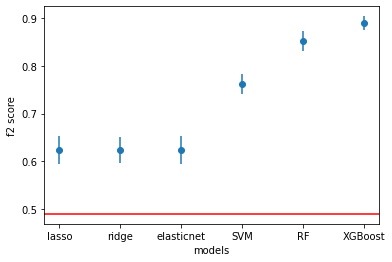

In [18]:
model_name = ["lasso","ridge","elasticnet","SVM", "RF","XGBoost"]

test_scores = [test_scores_lasso,test_scores_ridge,test_scores_elasticnet,test_scores_svm,test_scores_rf,test_scores_xgboost]
mean_list = [np.mean(score) for score in test_scores]
std_list = [np.std(score) for score in test_scores]


plt.errorbar(model_name,mean_list,yerr=std_list,label = "f2 score",fmt = "o")
plt.axhline(y=f2, color='r', linestyle='-')
plt.xlabel("models")
plt.ylabel("f2 score")
plt.savefig(root_dir+"/figures/F2 score for each model.png",transparent = True,bbox_inches='tight',dpi = 300)
plt.show()

In [20]:
(mean_list[-1] - f2)/std_list[-1]

28.81763714595361

In [19]:
#Save the test score:
df_testscore = pd.DataFrame()
for i,model in enumerate(model_name):
    df_testscore[model] = test_scores[i]
df_testscore.to_excel(root_dir+"/results/test_scores.xlsx",index = False)

'ridge'

**Calculate at least three different global feature importances and discuss your findings. Also calculate SHAP values for local feature importance. Discuss the results of model interpretations in the context of the problem. Which features are the most and least important? Did you find something that’s unexpected/surprising/interesting?**

#### Global Feature importances

In [4]:
#Get models from file
models = [load(root_dir+"/results/xgboost/"+file) for file in os.listdir(root_dir+"/results/xgboost")]

In [7]:
#feature_names
feature_names = ord_fea+preprocessor.transformers_[1][1][0].get_feature_names().tolist()+con_fea+dis_fea

#save feature importance to a dataframe
feature_importance = pd.DataFrame()

# for model in final_model_xgboost: 
for model in models:
    model.get_booster().feature_names = feature_names
    feature_importance = feature_importance.append(model.get_booster().get_score(importance_type= "gain"),ignore_index=True)   

#replace nan importance with 0 according to the XGBoost documentation
feature_importance.fillna(0,inplace = True)

In [8]:
#sort the importance in descending orders
importance = feature_importance.mean().sort_values(ascending= False)
features = importance.index.tolist()
error = [np.std(feature_importance[feature]) for feature in features]

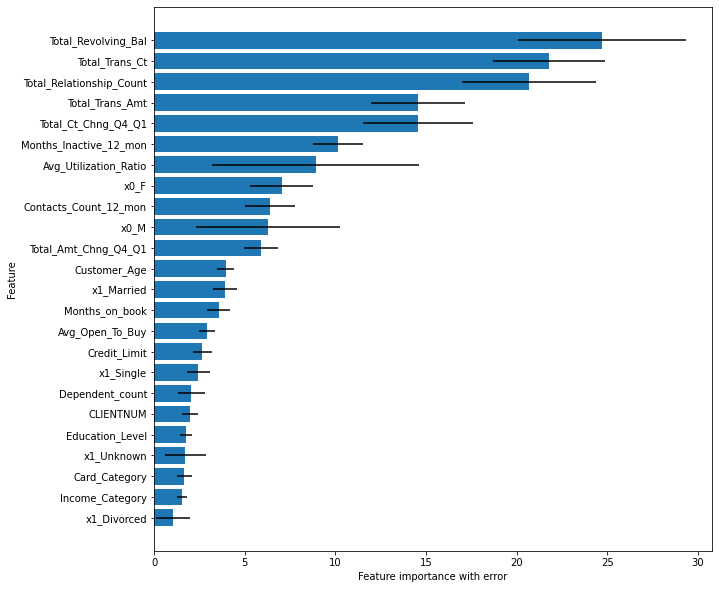

In [9]:
#plot the feature importances with error over 10 random states
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot()
ax.barh(features,importance, xerr=error, align='center')
ax.invert_yaxis() 
ax.set_xlabel('Feature importance with error')
ax.set_ylabel('Feature')
fig.savefig(root_dir+"/figures/Global feature importance.png",transparent = True,bbox_inches='tight',dpi = 300)

The importance measure is "gain" because it is the most relevant attribute to interpret the relative importance of each feature. The figure shows that the average most important feature of XGBoost models are 'Total_Revolving_Bal', 'Total_Trans_Ct' and 'Total_Relationship_Count. The first two feature are related to the customers' activities of bank account while the third one is a demographic feature.And the least important features are ‘x1_Divorced’, ‘Income_Category’ and ‘Card_Category’.

reference : https://towardsdatascience.com/be-careful-when-interpreting-your-features-importance-in-xgboost-6e16132588e7

In [249]:
explainer = shap.TreeExplainer(final_model_xgboost[-1]) #choose the best model when random state is 42*9
shap_values = explainer.shap_values(X_test_prep)  #test data set when random state is 42*9

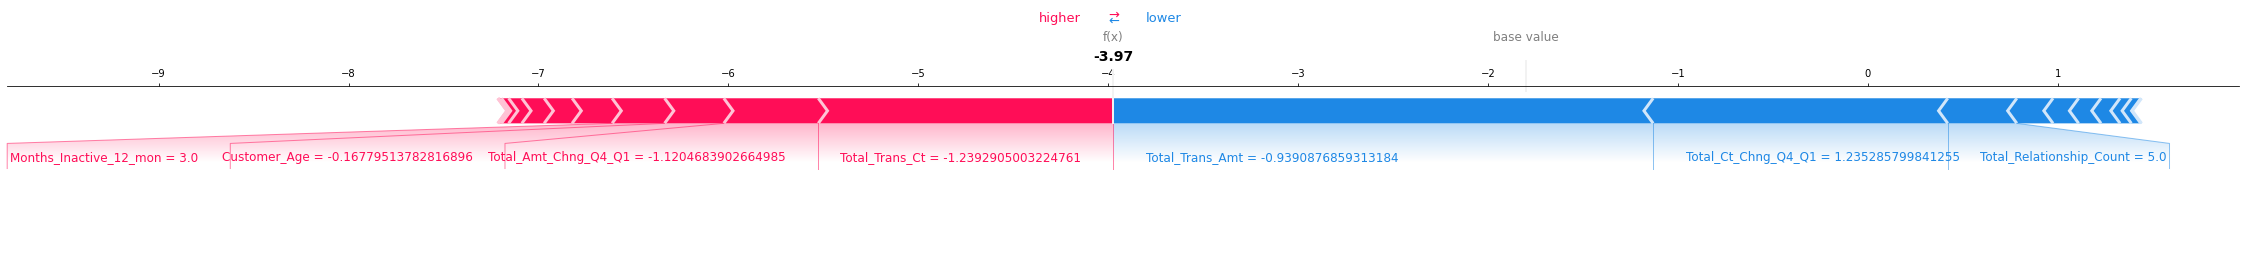

In [231]:
#explain a point
seed(1)
index_neg = sample(np.where(y_test == 0)[0].tolist(),1)

shap.force_plot(explainer.expected_value, shap_values[index_neg,:], features = X_test_prep[index_neg,:],feature_names = feature_names,
                        show = False,matplotlib=True,figsize=(40,3))
fig_neg = plt.gcf()
plt.savefig(root_dir+"/figures/Feature contribution of an existing customer.png",transparent = True,bbox_inches='tight',dpi = 300)

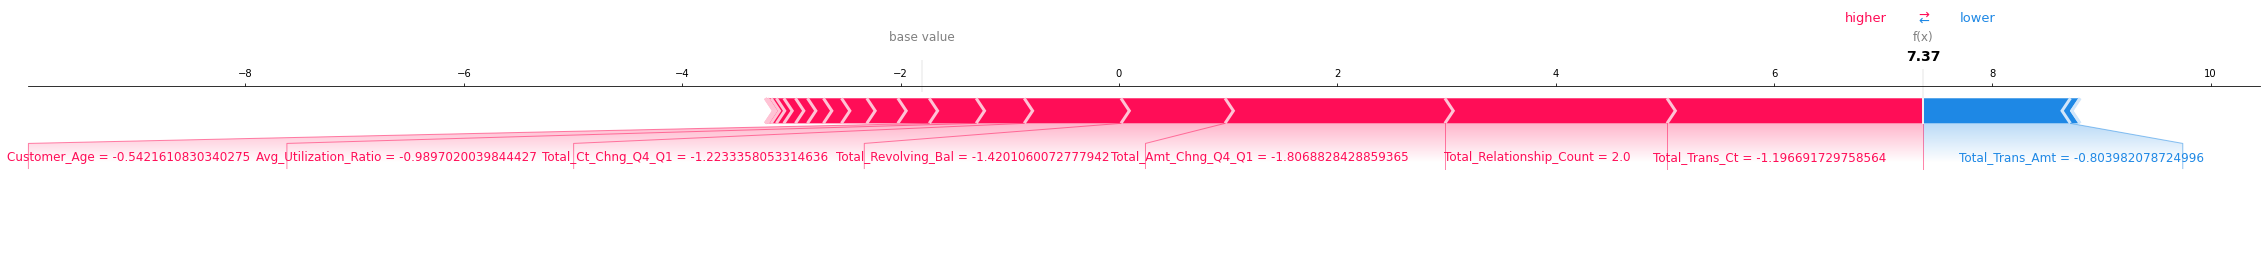

In [230]:
index_pos = sample(np.where(y_test == 1)[0].tolist(),1)
shap.force_plot(explainer.expected_value, shap_values[index_pos,:], features = X_test_prep[index_pos,:],feature_names = feature_names,
               show = False,matplotlib=True,figsize=(40,3))
fig_neg = plt.gcf()
plt.savefig(root_dir+"/figures/Feature contribution of an attited customer.png",transparent = True,bbox_inches='tight',dpi = 300)

For local feature importance, figure 7 has shown each feature’s contribution to the predictions of two different data points respectively. The base value -1.8 is the average model output over the test data set. The features in red push the prediction higher and those in blue push the prediction lower. And the higher the prediction, the more likely it is an attrited customer. The upper graph shows that the increasing effect of features such as 'Total_Trans_Ct' with value -1.3 is offset by the decreasing effect of features like 'Total_Trans_Amt' with value -0.9. The lower graph shows that 'Total_Trans_Ct', 'Total_Relationship_Count' and 'Total_Amt_Chng_Q4_Q1' with value -1.2, 2.0, -1.8 have the most increasing effect.

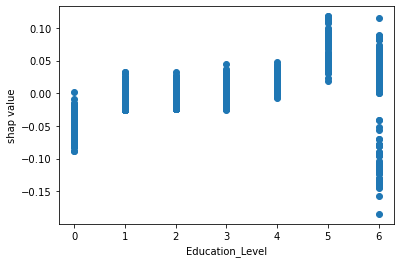

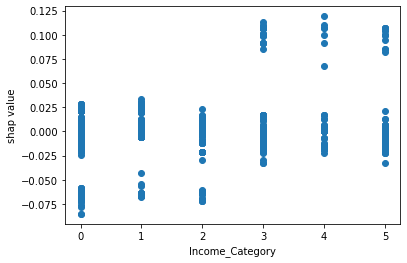

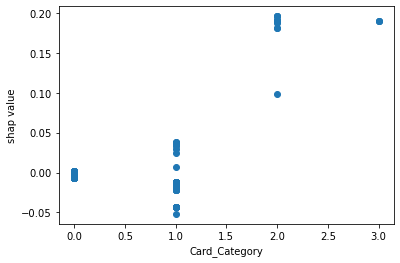

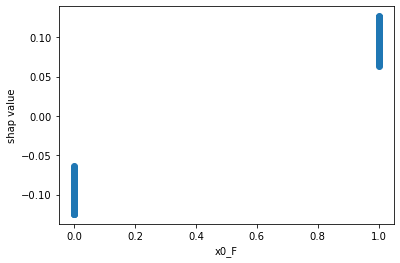

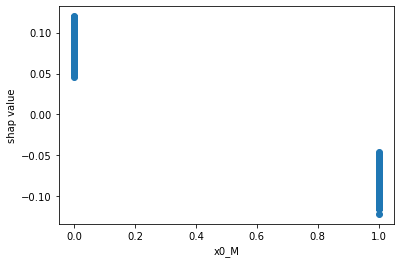

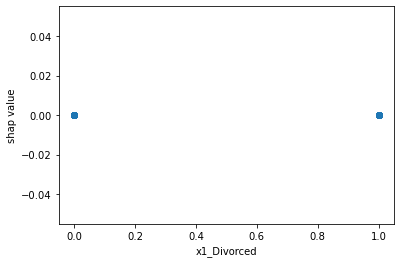

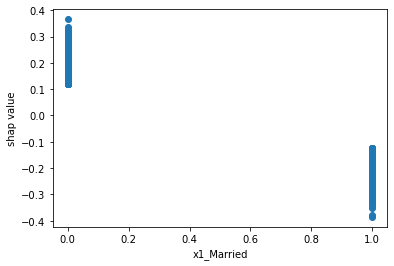

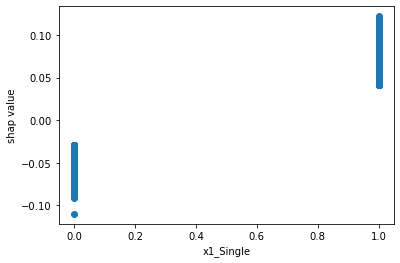

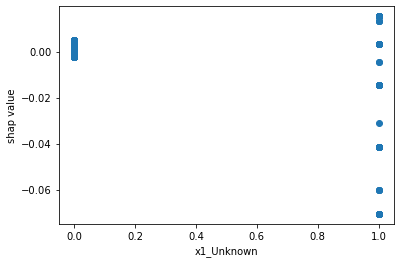

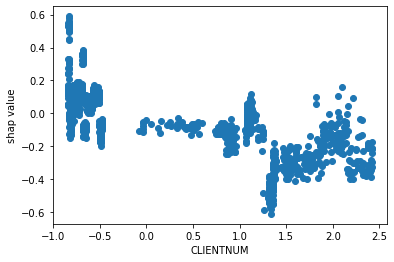

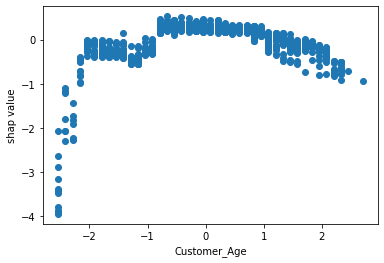

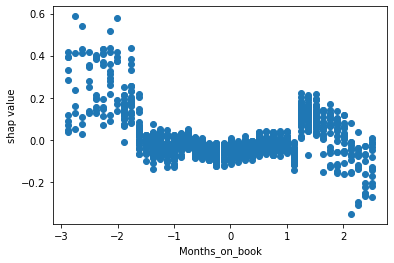

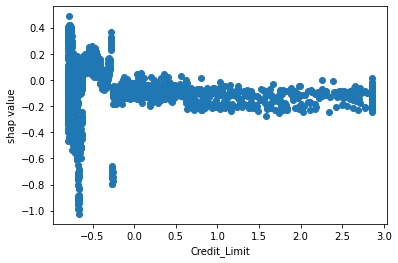

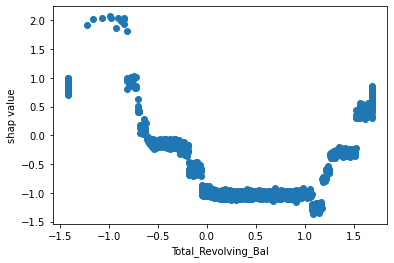

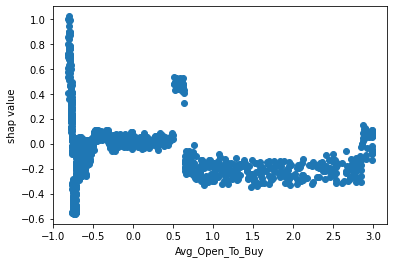

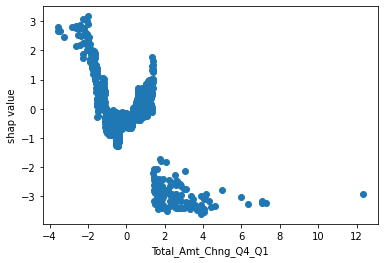

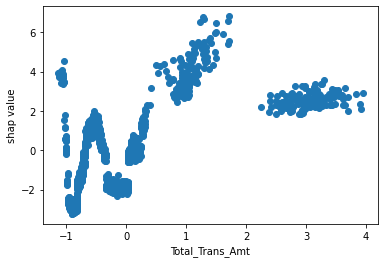

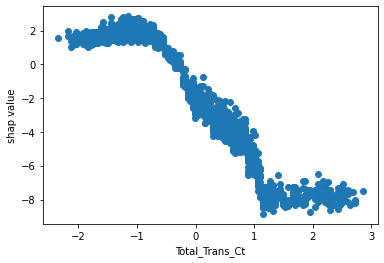

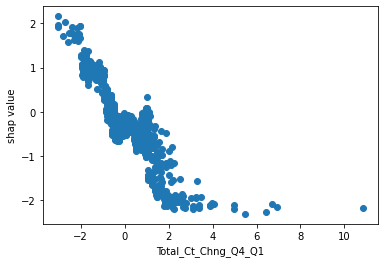

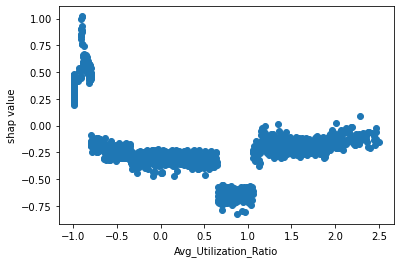

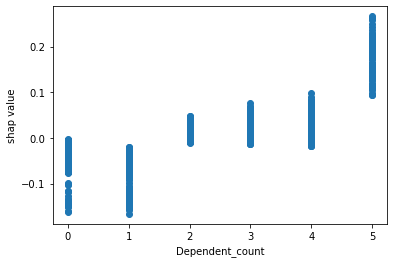

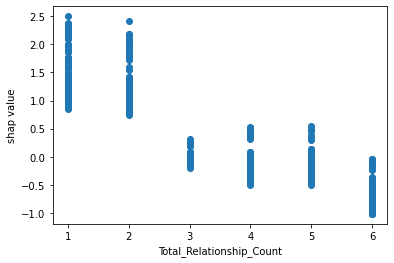

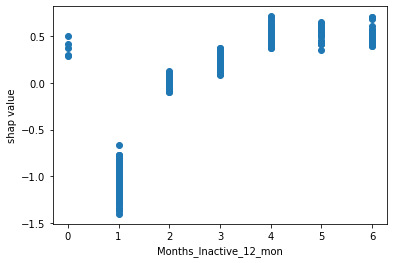

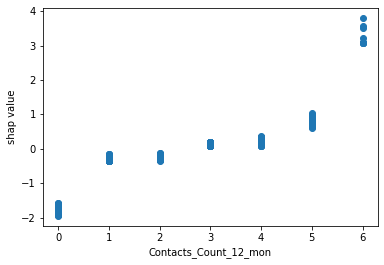

In [246]:
#explain a feature 
for ftr in feature_names:
    indx = np.argwhere(np.array(feature_names)==ftr)
    plt.scatter(X_test_prep[:,indx],shap_values[:,indx])
    plt.ylabel('shap value')
    plt.xlabel(ftr)
    plt.savefig(root_dir+"/figures/Shap_value_vs_Feature_value/Shap value of {}.png".format(ftr),transparent = True,bbox_inches='tight',dpi = 300)
    plt.show()

In [251]:
shap.plots.beeswarm(shap_values)

UnboundLocalError: local variable 'values' referenced before assignment

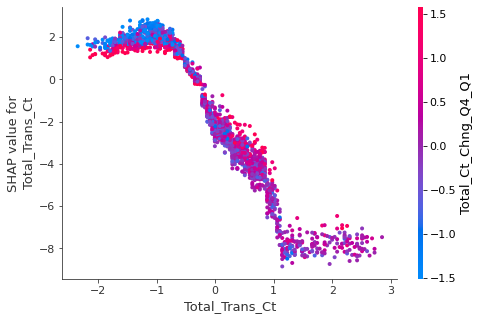

In [247]:
#dependence plot
shap.dependence_plot('Total_Trans_Ct', shap_values, X_test_prep, feature_names=feature_names)


# Outlook

**The outlook is the place to describe what else you could do to improve the model or the  interpretability, and what are the weak spots of your modeling approach. How would you improve this model? What additional techniques could you have used? What additional data could you collect to improve model performance?**

One thing that worth considering is the relationship between two features or among more features for better intepretability. There are some similar patterns in the scatter plot of shap values and feature values like 'Total_Trans_Ct' and 'Total_Ct_Change_Q4_Q1' or 'Avg_Open_To_Buy' and 'Credit_Limit'. In reality, these features are highly associated,  'Total_Trans_Ct' and 'Total_Ct_Change_Q4_Q1' are both related to the transaction counts while the average amount that left in customer's credit card plus the average amount that the customers paid using credit card is the credit limit of the credit cards. Besides, based on the relationship of 'Avg_Open_To_Buy' and 'Credit_Limit', we can come up with a new feature that represents the average amount that the customers paid using their credit card and this new feature may increase our model prediction. Except for feature engineering, there are two other strategies that may improve the model performance based on previous work. One it to use the LightGBM model because previous work has shown that LightGBM can achieve around 95.7% f2 score.The other is to collect more data of "Attrited Customers" as It has shown that the SMOTE technique which is to oversmaple the minority class could increase the model performance. The evaluation score also needs more consideration. The actual loss of predicting an attrited customer as an existing customer may be more or less than twice of the loss of predicting an existing customer as an attrited customer. 
